# Dataset Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Make a project folder inside your Drive
!mkdir -p '/content/drive/MyDrive/REHAB24-6'
%cd '/content/drive/MyDrive/REHAB24-6'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/REHAB24-6


In [ ]:
import os, zipfile

!wget -c "https://zenodo.org/records/13305826/files/3d_joints.zip?download=1" -O SkeletonData.zip
!unzip -q SkeletonData.zip -d "/content/drive/MyDrive/REHAB24-6/3d_joints"

--2026-02-15 02:35:02--  https://zenodo.org/records/13305826/files/3d_joints.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.153.219, 188.184.103.118, 188.184.98.114, ...
Connecting to zenodo.org (zenodo.org)|137.138.153.219|:443... connected.
HTTP request sent, awaiting response... 416 REQUESTED_RANGE_NOT_SATISFIABLE

    The file is already fully retrieved; nothing to do.

Ex1/PM_000-c17-120fps.npy:  mismatching "local" filename (Ex1/PM_000-120fps.npy),
         continuing with "central" filename version
error: invalid zip file with overlapped components (possible zip bomb)


In [ ]:
import os, zipfile

!wget -c "https://zenodo.org/records/13305826/files/2d_joints.zip?download=1" -O SkeletonData.zip
!unzip -q SkeletonData.zip -d "/content/drive/MyDrive/REHAB24-6/2d_joints"

In [ ]:
# Check subfolders
!ls "/content/drive/MyDrive/REHAB24-6/2d_joints"

Ex1  Ex2  Ex3  Ex4  Ex5  Ex6


In [ ]:
REHAB_ROOT = "/content/drive/MyDrive/REHAB24-6"
JOINTS_DIR = f"{REHAB_ROOT}/2d_joints"      # you unzipped here
SEG_CSV    = f"{REHAB_ROOT}/Segmentation.csv"
JOINTS_TXT = f"{REHAB_ROOT}/joints_names.txt"

print("REHAB_ROOT:", REHAB_ROOT)
print("JOINTS_DIR:", JOINTS_DIR)

REHAB_ROOT: /content/drive/MyDrive/REHAB24-6
JOINTS_DIR: /content/drive/MyDrive/REHAB24-6/2d_joints


In [ ]:
import os, re, glob
import numpy as np
import pandas as pd

# ---- joint names (26) ----
with open(JOINTS_TXT, "r", encoding="utf-8") as f:
    joint_names = [line.strip() for line in f if line.strip()]

name_to_idx = {n:i for i,n in enumerate(joint_names)}
print("Num joints:", len(joint_names))
print("First 10:", joint_names[:10])

# ---- segmentation table ----
seg = pd.read_csv(SEG_CSV, sep=';')

print("Columns:", seg.columns.tolist())
print("Rows:", len(seg))
seg.head()

Num joints: 26
First 10: ['0: Hips', '1: Spine', '2: Spine1', '3: Neck', '4: Head', '5: Head_end', '6: LeftShoulder', '7: LeftArm', '8: LeftForeArm', '9: LeftHand']
Columns: ['video_id', 'repetition_number', 'exercise_id', 'person_id', 'first_frame', 'last_frame', 'cam17_orientation', 'mocap_erroneous', 'exercise_subtype', 'lights_on', 'extra_person_in_cam17', 'extra_person_in_cam18', 'correctness']
Rows: 1072


,video_id,repetition_number,exercise_id,person_id,first_frame,last_frame,cam17_orientation,mocap_erroneous,exercise_subtype,lights_on,extra_person_in_cam17,extra_person_in_cam18,correctness
0,PM_000,1,1,1,180,377,front,0,right arm,0,3,0,1
1,PM_000,2,1,1,378,620,front,0,right arm,0,3,0,1
2,PM_000,3,1,1,621,865,front,0,right arm,0,3,0,1
3,PM_000,4,1,1,866,1085,front,0,right arm,0,3,3,1
4,PM_000,5,1,1,1086,1265,front,0,right arm,0,3,3,1


In [ ]:
def find_joint_file(video_id, joints_dir=JOINTS_DIR):
    """
    Returns the most likely joint file for a given video_id by searching the directory tree.
    Supports: .npy, .npz, .txt, .csv
    """
    vid = str(video_id)

    # 1) exact match on filename stem
    patterns = [
        f"**/{vid}.npy", f"**/{vid}.npz", f"**/{vid}.txt", f"**/{vid}.csv",
        f"**/*{vid}*.npy", f"**/*{vid}*.npz", f"**/*{vid}*.txt", f"**/*{vid}*.csv",
    ]

    hits = []
    for pat in patterns:
        hits.extend(glob.glob(os.path.join(joints_dir, pat), recursive=True))

    # prefer binary (npy/npz) if available
    hits_sorted = sorted(
        hits,
        key=lambda p: (0 if p.endswith(".npy") else 1 if p.endswith(".npz") else 2, len(p))
    )
    return hits_sorted[0] if hits_sorted else None

# quick smoke test on first few unique video_ids
for vid in seg["video_id"].dropna().unique()[:5]:
    p = find_joint_file(vid)
    print(vid, "->", p)

PM_000 -> /content/drive/MyDrive/REHAB24-6/2d_joints/Ex1/PM_000-c17-30fps.npy
PM_001 -> /content/drive/MyDrive/REHAB24-6/2d_joints/Ex1/PM_001-c18-30fps.npy
PM_002 -> /content/drive/MyDrive/REHAB24-6/2d_joints/Ex1/PM_002-c17-30fps.npy
PM_012 -> /content/drive/MyDrive/REHAB24-6/2d_joints/Ex1/PM_012-c18-30fps.npy
PM_016 -> /content/drive/MyDrive/REHAB24-6/2d_joints/Ex1/PM_016-c17-30fps.npy


In [ ]:
import os
import numpy as np
import pandas as pd

def load_joints(path, n_joints=26, dims=None):
    """
    Load joints into shape (T, n_joints, D) where D is 2 or 3.

    Supports:
      - (T, J, 2/3/4)  -> keeps first D coords (drops extras)
      - (T, J*D) wide
      - long formats:
          [frame, joint, x, y] or [frame, joint, x, y, conf]  -> D=2
          [frame, joint, x, y, z] or [frame, joint, x, y, z, conf] -> D=3
      - .npy, .npz, .txt, .csv

    Args:
      dims:
        - None: auto-detect from file (prefers 2 if clearly 2D, else 3 if z exists)
        - 2: force output D=2
        - 3: force output D=3
    """
    if path is None or not os.path.exists(path):
        raise FileNotFoundError(f"Missing joints file: {path}")

    ext = os.path.splitext(path)[1].lower()

    # ---- load raw array ----
    if ext == ".npy":
        arr = np.array(np.load(path, allow_pickle=True))
    elif ext == ".npz":
        z = np.load(path, allow_pickle=True)
        key0 = list(z.keys())[0]
        arr = np.array(z[key0])
    else:
        try:
            df = pd.read_csv(path, header=None, sep=r"[\s,;]+", engine="python")
            arr = df.values
        except Exception:
            df = pd.read_csv(path, header=None)
            arr = df.values
        arr = arr.astype(np.float32)

    arr = np.array(arr)

    # ---- helper: choose dims ----
    def pick_dims_from_last(last_dim):
        if dims in (2, 3):
            return dims
        # auto: if last_dim has 2 -> 2D, else if >=3 -> 3D
        return 2 if last_dim == 2 else 3

    # ---- Case A: already (T, J, C) ----
    if arr.ndim == 3 and arr.shape[1] == n_joints:
        C = arr.shape[2]
        D = pick_dims_from_last(C)
        if C < D:
            raise ValueError(f"File has only {C} coords but dims={D} requested: {path}")
        return arr[:, :, :D].astype(np.float32)

    # ---- Case B: wide (T, J*C) ----
    if arr.ndim == 2 and arr.shape[1] % n_joints == 0:
        C = arr.shape[1] // n_joints
        D = pick_dims_from_last(C)
        if C < D:
            raise ValueError(f"Wide format has only {C} coords but dims={D} requested: {path}")
        T = arr.shape[0]
        reshaped = arr.reshape(T, n_joints, C)
        return reshaped[:, :, :D].astype(np.float32)

    # ---- Case C: long format ----
    if arr.ndim == 2 and arr.shape[1] >= 4:
        # assume columns start with [frame, joint, ...coords...]
        frame = arr[:, 0].astype(int)
        joint = arr[:, 1].astype(int)

        # coords begin at col 2
        remaining = arr.shape[1] - 2

        # infer whether 2D or 3D coords are present
        if dims in (2, 3):
            D = dims
        else:
            # auto: if at least 3 coords exist, treat as 3D; else 2D
            D = 3 if remaining >= 3 else 2

        if remaining < D:
            raise ValueError(f"Long format has only {remaining} coord cols but D={D} needed: {path}")

        coords = arr[:, 2:2+D].astype(np.float32)

        T = frame.max() + 1
        out = np.zeros((T, n_joints, D), dtype=np.float32)
        out[frame, joint, :] = coords
        return out

    raise ValueError(f"Unrecognized joints format for {path}. Got shape {arr.shape}.")

In [ ]:
import numpy as np

def angle_3pts(a, b, c, eps=1e-8):
    """
    Angle at point b formed by a-b-c in degrees.
    Works for a,b,c in R^2 or R^3 (or any D>=2).
    """
    a = np.asarray(a, dtype=np.float32)
    b = np.asarray(b, dtype=np.float32)
    c = np.asarray(c, dtype=np.float32)

    ba = a - b
    bc = c - b

    # guard: degenerate vectors (e.g., missing joints -> zeros)
    nba = np.linalg.norm(ba)
    nbc = np.linalg.norm(bc)
    if nba < eps or nbc < eps:
        return 0.0

    cosv = float(np.dot(ba, bc) / (nba * nbc + eps))
    cosv = np.clip(cosv, -1.0, 1.0)
    return float(np.degrees(np.arccos(cosv)))


def compute_10_angles(frames, name_to_idx):
    """
    frames: (T, 26, D) where D = 2 or 3
    returns: (T, 10)
    """
    # --- required joints ---
    # upper limbs
    LS = name_to_idx["LeftShoulder"]
    LE = name_to_idx["LeftForeArm"]   # elbow proxy
    LW = name_to_idx["LeftHand"]

    RS = name_to_idx["RightShoulder"]
    RE = name_to_idx["RightForeArm"]
    RW = name_to_idx["RightHand"]

    # lower limbs
    LH = name_to_idx["LeftUpLeg"]
    LK = name_to_idx["LeftLeg"]
    LA = name_to_idx["LeftFoot"]

    RH = name_to_idx["RightUpLeg"]
    RK = name_to_idx["RightLeg"]
    RA = name_to_idx["RightFoot"]

    # trunk
    HIP  = name_to_idx["Hips"]
    SP1  = name_to_idx["Spine1"]
    NECK = name_to_idx["Neck"]

    T = frames.shape[0]
    out = np.zeros((T, 10), dtype=np.float32)

    for t in range(T):
        J = frames[t]  # (26, D)

        # 1–2 elbows: Shoulder–Elbow–Wrist
        out[t, 0] = angle_3pts(J[LS], J[LE], J[LW])
        out[t, 1] = angle_3pts(J[RS], J[RE], J[RW])

        # 3–4 knees: Hip–Knee–Ankle
        out[t, 2] = angle_3pts(J[LH], J[LK], J[LA])
        out[t, 3] = angle_3pts(J[RH], J[RK], J[RA])

        # 5–6 hips: Shoulder–Hip–Knee (proxy)
        out[t, 4] = angle_3pts(J[LS], J[LH], J[LK])
        out[t, 5] = angle_3pts(J[RS], J[RH], J[RK])

        # 7–8 shoulder/armpit: Hip–Shoulder–Elbow (proxy)
        out[t, 6] = angle_3pts(J[HIP], J[LS], J[LE])
        out[t, 7] = angle_3pts(J[HIP], J[RS], J[RE])

        # 9 torso flex: Hips–Spine1–Neck
        out[t, 8] = angle_3pts(J[HIP], J[SP1], J[NECK])

        # 10 shoulder alignment: LeftShoulder–Spine1–RightShoulder
        out[t, 9] = angle_3pts(J[LS], J[SP1], J[RS])

    # replace NaNs/infs if any
    return np.nan_to_num(out, nan=0.0, posinf=0.0, neginf=0.0)

In [ ]:
def resample_timeseries(x, target_len=100):
    """
    x: (T, D) -> (target_len, D) via linear interpolation
    Robust to NaNs and degenerate cases.
    """
    x = np.asarray(x, dtype=np.float32)
    T, D = x.shape

    # remove NaNs early (important for 2D pose)
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

    if T == target_len:
        return x.astype(np.float32)

    if T < 2:
        return np.repeat(x[:1], target_len, axis=0).astype(np.float32)

    # use normalized time without duplicating endpoint bias
    old_idx = np.linspace(0, 1, T, endpoint=True)
    new_idx = np.linspace(0, 1, target_len, endpoint=True)

    # vectorized interpolation
    out = np.empty((target_len, D), dtype=np.float32)
    for d in range(D):
        out[:, d] = np.interp(new_idx, old_idx, x[:, d])

    return out

In [ ]:
import re

with open(JOINTS_TXT, "r", encoding="utf-8") as f:
    raw = [line.strip() for line in f if line.strip()]

def clean_joint_name(s):
    # removes patterns like "0: Hips" or "0 - Hips" or "0,Hips"
    s = re.sub(r"^\s*\d+\s*[:\-,]\s*", "", s)
    return s.strip()

joint_names = [clean_joint_name(s) for s in raw]
name_to_idx = {n: i for i, n in enumerate(joint_names)}

print("First 12 cleaned:", joint_names[:12])
print("Has LeftShoulder?", "LeftShoulder" in name_to_idx)
print("Keys containing 'Shoulder':", [k for k in name_to_idx.keys() if "Shoulder" in k])

First 12 cleaned: ['Hips', 'Spine', 'Spine1', 'Neck', 'Head', 'Head_end', 'LeftShoulder', 'LeftArm', 'LeftForeArm', 'LeftHand', 'LeftHand_end', 'RightShoulder']
Has LeftShoulder? True
Keys containing 'Shoulder': ['LeftShoulder', 'RightShoulder']


In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd

def build_rehab24_angles_dataset(
    seg_df,
    name_to_idx,
    target_len=100,
    drop_erroneous=True,
    use_2d=True,
    filter_orientation=None,   # e.g., "front" or ["front","profile"]
    max_extra_people=None,     # e.g., 1 (keep <=1)
    require_lights_on=None,    # True/False/None
):
    """
    Builds (N, target_len, 10) angle sequences from REHAB24 repetition segmentation.

    Args:
      use_2d:
        - True  -> expects JOINTS_DIR points to 2d_joints, loads dims=2
        - False -> expects JOINTS_DIR points to 3d_joints, loads dims=3
      filter_orientation:
        - None: keep all
        - str or list[str]: keep only those cam17 orientations
      max_extra_people:
        - None: keep all
        - int: keep rows where extra_person_in_cam17 <= max_extra_people AND extra_person_in_cam18 <= max_extra_people
      require_lights_on:
        - None: keep all
        - True/False: keep only those
    """
    rows = seg_df.copy()

    # --- basic noise filters ---
    if drop_erroneous and "mocap_erroneous" in rows.columns:
        rows = rows[rows["mocap_erroneous"] == 0].copy()

    if filter_orientation is not None and "cam17_orientation" in rows.columns:
        allowed = [filter_orientation] if isinstance(filter_orientation, str) else list(filter_orientation)
        rows = rows[rows["cam17_orientation"].isin(allowed)].copy()

    if max_extra_people is not None:
        if "extra_person_in_cam17" in rows.columns:
            rows = rows[rows["extra_person_in_cam17"] <= max_extra_people].copy()
        if "extra_person_in_cam18" in rows.columns:
            rows = rows[rows["extra_person_in_cam18"] <= max_extra_people].copy()

    if require_lights_on is not None and "lights_on" in rows.columns:
        rows = rows[rows["lights_on"] == int(require_lights_on)].copy()

    # --- outputs ---
    X_list, y_list, g_list, meta_list = [], [], [], []
    missing_files = 0
    bad_slices = 0

    D = 2 if use_2d else 3

    for _, r in tqdm(rows.iterrows(), total=len(rows)):
        video_id   = r["video_id"]
        person_id  = r["person_id"]
        exercise_id = r.get("exercise_id", None)

        f0 = int(r["first_frame"])
        f1 = int(r["last_frame"])
        y  = int(r["correctness"])  # 0/1

        path = find_joint_file(video_id, JOINTS_DIR)
        if path is None:
            missing_files += 1
            continue

        # ✅ use unified loader (2D or 3D)
        joints = load_joints(path, n_joints=len(name_to_idx), dims=D)  # (T,26,D)
        T = joints.shape[0]

        # bounds safety
        f0 = max(0, min(f0, T - 1))
        f1 = max(0, min(f1, T - 1))
        if f1 <= f0 + 1:
            bad_slices += 1
            continue

        rep = joints[f0:f1 + 1]                              # (Tr, 26, D)
        rep_ang = compute_10_angles(rep, name_to_idx)         # (Tr, 10)
        rep_ang = resample_timeseries(rep_ang, target_len)    # (target_len, 10)

        X_list.append(rep_ang)
        y_list.append(y)
        g_list.append(person_id)

        meta_list.append({
            "video_id": video_id,
            "person_id": person_id,
            "exercise_id": exercise_id,
            "repetition_number": r.get("repetition_number", None),
            "first_frame": int(r["first_frame"]),
            "last_frame": int(r["last_frame"]),
            "cam17_orientation": r.get("cam17_orientation", None),
            "exercise_subtype": r.get("exercise_subtype", None),
            "lights_on": r.get("lights_on", None),
            "extra_person_in_cam17": r.get("extra_person_in_cam17", None),
            "extra_person_in_cam18": r.get("extra_person_in_cam18", None),
            "source_path": path,
            "dims": D
        })

    X = np.stack(X_list).astype(np.float32)   # (N, target_len, 10)
    y = np.array(y_list).astype(np.int64)     # (N,)
    groups = np.array(g_list)                 # (N,)
    meta = pd.DataFrame(meta_list)

    print("Built dataset:")
    print("  X:", X.shape, "y:", y.shape, "groups:", groups.shape)
    print("  missing_files:", missing_files, "bad_slices:", bad_slices)
    print("  use_2d:", use_2d, "D:", D)
    print("  filters:",
          {"drop_erroneous": drop_erroneous,
           "filter_orientation": filter_orientation,
           "max_extra_people": max_extra_people,
           "require_lights_on": require_lights_on})

    return X, y, groups, meta

In [ ]:
X2, y2, groups2, meta2 = build_rehab24_angles_dataset(
    seg_df=seg,
    name_to_idx=name_to_idx,
    target_len=100,
    drop_erroneous=True,
    use_2d=True
)

meta2.head()

100%|██████████| 1057/1057 [02:22<00:00,  7.43it/s]


Built dataset:
  X: (1057, 100, 10) y: (1057,) groups: (1057,)
  missing_files: 0 bad_slices: 0
  use_2d: True D: 2
  filters: {'drop_erroneous': True, 'filter_orientation': None, 'max_extra_people': None, 'require_lights_on': None}


,video_id,person_id,exercise_id,repetition_number,first_frame,last_frame,cam17_orientation,exercise_subtype,lights_on,extra_person_in_cam17,extra_person_in_cam18,source_path,dims
0,PM_000,1,1,1,180,377,front,right arm,0,3,0,/content/drive/MyDrive/REHAB24-6/2d_joints/Ex1...,2
1,PM_000,1,1,2,378,620,front,right arm,0,3,0,/content/drive/MyDrive/REHAB24-6/2d_joints/Ex1...,2
2,PM_000,1,1,3,621,865,front,right arm,0,3,0,/content/drive/MyDrive/REHAB24-6/2d_joints/Ex1...,2
3,PM_000,1,1,4,866,1085,front,right arm,0,3,3,/content/drive/MyDrive/REHAB24-6/2d_joints/Ex1...,2
4,PM_000,1,1,5,1086,1265,front,right arm,0,3,3,/content/drive/MyDrive/REHAB24-6/2d_joints/Ex1...,2


In [ ]:
print("Mean:", X2.mean(axis=(0,1)))
print("Std :", X2.std(axis=(0,1)))
print("Label balance:", np.bincount(y2))
print("Unique subjects:", len(np.unique(groups2)))
print("Exercises:", meta2["exercise_id"].value_counts().sort_index())

Mean: [132.25494  129.0575   157.18092  154.0386   166.17836  162.95073
  58.667767  64.250404 174.92433   15.466859]
Std : [43.079758  43.343666  25.586603  28.28252   19.951206  22.967058
 43.11694   43.242874   4.4766417 10.423361 ]
Label balance: [499 558]
Unique subjects: 10
Exercises: exercise_id
1    178
2    208
3     96
4    210
5    174
6    191
Name: count, dtype: int64


# Section 1: Build Gesture-Wise Reference Templates

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import GroupKFold

REHAB_ROOT = Path("/content/drive/MyDrive/REHAB24-6")
SEG_CSV    = REHAB_ROOT / "Segmentation.csv"
JOINTS_TXT = REHAB_ROOT / "joints_names.txt"

# IMPORTANT: point to 2D joints folder
JOINTS_DIR = REHAB_ROOT / "2d_joints"

# load segmentation (semicolon-separated!)
seg = pd.read_csv(SEG_CSV, sep=";")

# build IRDS-like df: subject, gesture, correctness, trial_id
df = seg.copy()
df = df[df["correctness"].isin([0,1])].copy()  # already 0/1 in REHAB24
df["subject"] = df["person_id"].astype(int)
df["gesture"] = df["exercise_id"].astype(int)
df["trial_id"] = (
    df["video_id"].astype(str) + "_rep" + df["repetition_number"].astype(str)
)

print(df["correctness"].value_counts())
print("n trials:", len(df), "n subjects:", df["subject"].nunique(), "n exercises:", df["gesture"].nunique())

In [ ]:
import re

with open(JOINTS_TXT, "r", encoding="utf-8") as f:
    raw = [line.strip() for line in f if line.strip()]

def clean_joint_name(s):
    s = re.sub(r"^\s*\d+\s*[:\-,]\s*", "", s)
    return s.strip()

joint_names = [clean_joint_name(s) for s in raw]
name_to_idx = {n:i for i,n in enumerate(joint_names)}

print("Example names:", joint_names[:10])
print("Has LeftShoulder?", "LeftShoulder" in name_to_idx)

In [ ]:
# COCO17 indices we will fill (same semantic joints as IRDS mapping)
# COCO: 0 nose, 5 LShoulder, 6 RShoulder, 7 LElbow, 8 RElbow, 9 LWrist, 10 RWrist,
#       11 LHip, 12 RHip, 13 LKnee, 14 RKnee, 15 LAnkle, 16 RAnkle

REHAB24_TO_COCO = {
    "Head": 0,                 # nose proxy (closest available)
    "LeftShoulder": 5,
    "RightShoulder": 6,
    "LeftForeArm": 7,          # elbow proxy (consistent with your earlier choice)
    "RightForeArm": 8,
    "LeftHand": 9,
    "RightHand": 10,
    "LeftUpLeg": 11,
    "RightUpLeg": 12,
    "LeftLeg": 13,
    "RightLeg": 14,
    "LeftFoot": 15,
    "RightFoot": 16,
}

def map_rehab24_to_coco17(seq_26):
    """
    seq_26: (T,26,2)  -> (T,17,2)
    """
    T = seq_26.shape[0]
    out = np.zeros((T, 17, 2), dtype=np.float32)
    for rehab_name, coco_idx in REHAB24_TO_COCO.items():
        if rehab_name not in name_to_idx:
            continue
        out[:, coco_idx, :] = seq_26[:, name_to_idx[rehab_name], :].astype(np.float32)
    return out

In [ ]:
def load_rehab24_rep_as_coco(row):
    """
    Returns COCO17 joint sequence for a single repetition:
      (Tr,17,2)
    """
    video_id = row["video_id"]
    f0 = int(row["first_frame"])
    f1 = int(row["last_frame"])

    path = find_joint_file(video_id, str(JOINTS_DIR))
    if path is None:
        raise FileNotFoundError(f"No joint file for {video_id}")

    joints = load_joints(path, n_joints=26, dims=2)  # (T,26,2)
    T = joints.shape[0]

    f0 = max(0, min(f0, T-1))
    f1 = max(0, min(f1, T-1))
    if f1 <= f0 + 1:
        raise ValueError(f"Bad slice for {video_id}: {f0}-{f1} / T={T}")

    rep_26 = joints[f0:f1+1]              # (Tr,26,2)
    rep_17 = map_rehab24_to_coco17(rep_26) # (Tr,17,2)
    return rep_17

In [ ]:
def normalize_length(seq, target_len=100):
    old_len = seq.shape[0]
    if old_len == target_len:
        return seq.astype(np.float32)
    new_idx = np.linspace(0, old_len - 1, target_len)
    lo = np.floor(new_idx).astype(int)
    hi = np.clip(lo + 1, 0, old_len - 1)
    a = (new_idx - lo).astype(np.float32)
    out = (1 - a)[:, None, None] * seq[lo] + a[:, None, None] * seq[hi]
    return out.astype(np.float32)

def compute_psm(a, b):
    # a,b: (T,17,2)
    num = np.sum(a * b, axis=2)
    den = np.linalg.norm(a, axis=2) * np.linalg.norm(b, axis=2)
    sim = np.nan_to_num(num / (den + 1e-9))
    return float(np.mean(sim))

def compute_msi(seq):
    # seq: (T,17,2)
    vel = np.diff(seq, axis=0)
    acc = np.diff(vel, axis=0)
    return float(np.mean(np.linalg.norm(acc, axis=2)))

def compute_joint_deviation(seq, ref):
    d = np.linalg.norm(seq - ref, axis=2)
    return float(np.mean(d))

In [ ]:
USE_KEYFRAMES = True
TARGET_LEN = 100
K_ALIGN = 6

def keyframes_energy_peaks(seq, max_k=6):
    # seq: (T,17,2)
    X = seq.reshape(seq.shape[0], -1)
    e = np.linalg.norm(np.diff(X, axis=0), axis=1)  # (T-1,)
    if e.sum() == 0:
        return seq[[0, -1]] if seq.shape[0] > 1 else seq[:1]

    peak_idx = np.argsort(e)[::-1][:max(0, max_k-2)] + 1
    idx = np.unique(np.clip(np.concatenate([[0], peak_idx, [seq.shape[0]-1]]), 0, seq.shape[0]-1))
    idx = np.sort(idx)
    return seq[idx]

def resample_keyframes(kf, K=6):
    Keff = kf.shape[0]
    if Keff == K:
        return kf
    idx = np.linspace(0, Keff - 1, K)
    lo = np.floor(idx).astype(int)
    hi = np.clip(lo + 1, 0, Keff - 1)
    a = (idx - lo).astype(np.float32)[:, None, None]
    return (1 - a) * kf[lo] + a * kf[hi]

In [ ]:
keyframe_cache = {}

for _, row in tqdm(df.iterrows(), total=len(df), desc="Caching keyframes (REHAB24)"):
    tid = row["trial_id"]
    if tid in keyframe_cache:
        continue
    try:
        seq = load_rehab24_rep_as_coco(row)          # (Tr,17,2)
        seq = normalize_length(seq, TARGET_LEN)      # (100,17,2)
        kf  = keyframes_energy_peaks(seq, max_k=K_ALIGN)
        kf  = resample_keyframes(kf, K=K_ALIGN)      # (K,17,2)
        keyframe_cache[tid] = kf
    except Exception as e:
        # skip silently like your original code, but you can log if needed
        pass

print("Cached:", len(keyframe_cache), "out of", len(df))

Caching keyframes (REHAB24): 100%|██████████| 1072/1072 [01:21<00:00, 13.19it/s]

Cached: 1072 out of 1072


In [ ]:
def build_references(train_df, target_len=100, correct_only=True, min_trials=3):
    refs = {}
    for g in sorted(train_df["gesture"].unique()):
        sub = train_df[train_df["gesture"] == g]
        if correct_only:
            sub = sub[sub["correctness"] == 1]
        if len(sub) < min_trials:
            continue

        seqs = []
        for _, row in sub.iterrows():
            try:
                seq = load_rehab24_rep_as_coco(row)      # (Tr,17,2)
                seq = normalize_length(seq, target_len)  # (100,17,2)
                seqs.append(seq)
            except:
                pass

        if len(seqs) >= min_trials:
            refs[g] = np.mean(np.stack(seqs, axis=0), axis=0).astype(np.float32)

    return refs

In [ ]:
def compute_metrics_df(split_df, refs):
    rows = []
    for _, row in split_df.iterrows():
        g = row["gesture"]
        if g not in refs:
            continue

        tid = row["trial_id"]

        if USE_KEYFRAMES:
            if tid not in keyframe_cache:
                continue
            seq = keyframe_cache[tid]          # (K,17,2)

            ref = refs[g]                      # (100,17,2)
            ref_kf = resample_keyframes(keyframes_energy_peaks(ref, max_k=K_ALIGN), K=K_ALIGN)

            psm = compute_psm(seq, ref_kf)
            msi = compute_msi(seq)
            jd  = compute_joint_deviation(seq, ref_kf)
        else:
            try:
                seq = load_rehab24_rep_as_coco(row)
                seq = normalize_length(seq, TARGET_LEN)  # (100,17,2)
            except:
                continue

            ref = refs[g]
            psm = compute_psm(seq, ref)
            msi = compute_msi(seq)
            jd  = compute_joint_deviation(seq, ref)

        rows.append({
            "trial_id": tid,
            "subject": row["subject"],
            "gesture": g,
            "correctness": int(row["correctness"]),
            "PSM": psm,
            "MSI": msi,
            "JD": jd
        })

    return pd.DataFrame(rows)

In [ ]:
N_SPLITS = 5
gkf = GroupKFold(n_splits=N_SPLITS)

all_folds = []
for fold, (tr_idx, te_idx) in enumerate(gkf.split(df, groups=df["subject"]), start=1):
    train_df = df.iloc[tr_idx].reset_index(drop=True)
    test_df  = df.iloc[te_idx].reset_index(drop=True)

    refs = build_references(train_df, target_len=TARGET_LEN, correct_only=True, min_trials=3)

    train_metrics = compute_metrics_df(train_df, refs)
    test_metrics  = compute_metrics_df(test_df,  refs)

    train_metrics["fold"] = fold
    train_metrics["split"] = "train"
    test_metrics["fold"] = fold
    test_metrics["split"] = "test"

    print(f"[Fold {fold}] refs={len(refs)} | train={len(train_metrics)} | test={len(test_metrics)}")

    all_folds.append(train_metrics)
    all_folds.append(test_metrics)

cv_metrics_rehab = pd.concat(all_folds, ignore_index=True)
cv_metrics_rehab.head()

[Fold 1] refs=6 | train=937 | test=135
[Fold 2] refs=6 | train=834 | test=238
[Fold 3] refs=6 | train=843 | test=229
[Fold 4] refs=6 | train=835 | test=237
[Fold 5] refs=6 | train=839 | test=233


,trial_id,subject,gesture,correctness,PSM,MSI,JD,fold,split
0,PM_000_rep1,1,1,1,0.734662,12.382800,248.833969,1,train
1,PM_000_rep2,1,1,1,0.734385,13.789624,249.519836,1,train
2,PM_000_rep3,1,1,1,0.732681,16.565796,254.212738,1,train
3,PM_000_rep4,1,1,1,0.732711,16.447954,254.439163,1,train
4,PM_000_rep5,1,1,1,0.733839,14.121261,251.575394,1,train


In [ ]:
cv_metrics_rehab.to_csv("/content/drive/MyDrive/REHAB24-6/cv_metrics.csv", index=False)

In [ ]:
print(cv_metrics_rehab["gesture"].value_counts().sort_index())
print(cv_metrics_rehab.groupby(["split"])["correctness"].value_counts())
print(cv_metrics_rehab[["PSM","MSI","JD"]].describe())

gesture
1     890
2    1040
3     535
4    1050
5     870
6     975
Name: count, dtype: int64
split  correctness
test   1               568
       0               504
train  1              2272
       0              2016
Name: count, dtype: int64
               PSM          MSI           JD
count  5360.000000  5360.000000  5360.000000
mean      0.739607    24.814700   217.443645
std       0.024305    14.862792    89.639997
min       0.646395     2.793848    47.312988
25%       0.730606    14.021117   151.640064
50%       0.748444    20.312760   202.512062
75%       0.757543    32.285359   272.224701
max       0.764440    87.180435   489.139404


In [ ]:
cv_metrics_rehab.groupby("correctness")[["PSM","MSI","JD"]].mean()

,PSM,MSI,JD
correctness,,,
0,0.738638,26.460015,224.660950
1,0.740467,23.354772,211.039559


In [ ]:
from sklearn.model_selection import GroupKFold

N_SPLITS = 5
gkf = GroupKFold(n_splits=N_SPLITS)

folds = []
for fold, (tr_idx, te_idx) in enumerate(gkf.split(X2, y2, groups=groups2), start=1):
    folds.append((fold, tr_idx, te_idx))

print("Prepared folds:", len(folds))
print("Fold 1 sizes:", len(folds[0][1]), len(folds[0][2]))

Prepared folds: 5
Fold 1 sizes: 922 135


In [ ]:
import pandas as pd
cv_metrics_rehab = pd.read_csv("/content/drive/MyDrive/REHAB24-6/cv_metrics.csv")

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon

df = cv_metrics_rehab.copy()

# Use only TEST repetitions
df_test = df[df["split"] == "test"].copy()

print("Total test repetitions:", len(df_test))
print(df_test["correctness"].value_counts())

Total test repetitions: 1072
correctness
1    568
0    504
Name: count, dtype: int64


In [ ]:
summary = (
    df_test
    .groupby(["gesture", "correctness"])[["PSM", "MSI", "JD"]]
    .agg(["mean", "std", "count"])
    .reset_index()
)

summary

gesture correctness       PSM                        MSI                   \
                            mean       std count       mean        std count   
0        1           0  0.741662  0.012627    88  12.220837   3.320178    88   
1        1           1  0.741934  0.013578    90  13.020589   3.778953    90   
2        2           0  0.724589  0.028941   114  21.241899   6.390800   114   
3        2           1  0.730487  0.027235    94  18.222108   6.739541    94   
4        3           0  0.730439  0.018007    55  17.821714   8.489902    55   
5        3           1  0.729935  0.018642    52  20.809123  10.489235    52   
6        4           0  0.728843  0.035614    90  24.812104   9.780117    90   
7        4           1  0.730759  0.036502   120  15.991029   5.199834   120   
8        5           0  0.733052  0.025082    96  35.947369  13.788733    96   
9        5           1  0.731926  0.024184    78  28.882180  12.883134    78   
10       6           0  0.748957  0.030018    61  52.042725  17.826302    61   
11       6           1  0.741062  0.037595   134  38.260981  14.255485   134   

            JD                    
          mean         std count  
0   232.126330   42.476099    88  
1   230.879233   45.250108    90  
2   271.018562   73.630399   114  
3   251.690421   67.520219    94  
4   278.879602   64.346916    55  
5   284.673838   69.922324    52  
6   236.197625  121.948745    90  
7   232.570308  120.894051   120  
8   264.357017   89.472785    96  
9   267.407350   92.601588    78  
10  164.815990  107.884942    61  
11  186.230355  130.122567   134

In [ ]:
stats_rows = []

for g in sorted(df_test["gesture"].unique()):
    df_g = df_test[df_test["gesture"] == g]

    corr = df_g[df_g["correctness"] == 1]
    inc  = df_g[df_g["correctness"] == 0]

    if len(corr) > 0 and len(inc) > 0:
        # Use Wilcoxon on paired? No.
        # These are independent repetitions → use Mann–Whitney U
        from scipy.stats import mannwhitneyu

        p_psm = mannwhitneyu(corr["PSM"], inc["PSM"], alternative="two-sided").pvalue
        p_msi = mannwhitneyu(corr["MSI"], inc["MSI"], alternative="two-sided").pvalue
        p_jd  = mannwhitneyu(corr["JD"],  inc["JD"],  alternative="two-sided").pvalue

        stats_rows.append({
            "gesture": g,
            "p_psm": p_psm,
            "p_msi": p_msi,
            "p_jd": p_jd,
            "mean_psm_corr": corr["PSM"].mean(),
            "mean_psm_inc": inc["PSM"].mean(),
            "mean_msi_corr": corr["MSI"].mean(),
            "mean_msi_inc": inc["MSI"].mean(),
            "mean_jd_corr": corr["JD"].mean(),
            "mean_jd_inc": inc["JD"].mean(),
        })

stats_df = pd.DataFrame(stats_rows)
stats_df

,gesture,p_psm,p_msi,p_jd,mean_psm_corr,mean_psm_inc,mean_msi_corr,mean_msi_inc,mean_jd_corr,mean_jd_inc
0,1,0.630159,1.870331e-01,0.617808,0.741934,0.741662,13.020589,12.220837,230.879233,232.126330
1,2,0.061281,7.662326e-05,0.020064,0.730487,0.724589,18.222108,21.241899,251.690421,271.018562
2,3,0.898326,1.306617e-01,0.384573,0.729935,0.730439,20.809123,17.821714,284.673838,278.879602
3,4,0.406790,1.130357e-13,0.642154,0.730759,0.728843,15.991029,24.812104,232.570308,236.197625
4,5,0.717633,4.203548e-04,0.852360,0.731926,0.733052,28.882180,35.947369,267.407350,264.357017
5,6,0.012904,2.652804e-07,0.611678,0.741062,0.748957,38.260981,52.042725,186.230355,164.815990


In [ ]:
corr_all = df_test[df_test["correctness"] == 1]
inc_all  = df_test[df_test["correctness"] == 0]

from scipy.stats import mannwhitneyu

p_psm_all = mannwhitneyu(corr_all["PSM"], inc_all["PSM"]).pvalue
p_msi_all = mannwhitneyu(corr_all["MSI"], inc_all["MSI"]).pvalue
p_jd_all  = mannwhitneyu(corr_all["JD"],  inc_all["JD"]).pvalue

print("Global PSM p:", p_psm_all)
print("Global MSI p:", p_msi_all)
print("Global JD  p:", p_jd_all)

print("Mean PSM correct vs incorrect:", corr_all["PSM"].mean(), inc_all["PSM"].mean())
print("Mean MSI correct vs incorrect:", corr_all["MSI"].mean(), inc_all["MSI"].mean())
print("Mean JD  correct vs incorrect:", corr_all["JD"].mean(),  inc_all["JD"].mean())

Global PSM p: 0.035283198453849085
Global MSI p: 0.0008020684850671959
Global JD  p: 0.012363939200149512
Mean PSM correct vs incorrect: 0.7350001244897574 0.7335293142805024
Mean MSI correct vs incorrect: 23.354772066146555 26.460014797392347
Mean JD  correct vs incorrect: 234.08828879074312 244.74493334028455


# Dual Attention

In [ ]:
import numpy as np

def angle_abc(A, B, C, eps=1e-8):
    """
    A,B,C: (...,D) where D=2 or 3
    Returns angle at B in radians (...,)
    """
    BA = A - B
    BC = C - B
    dot = np.sum(BA * BC, axis=-1)
    n1 = np.linalg.norm(BA, axis=-1)
    n2 = np.linalg.norm(BC, axis=-1)
    cos = dot / (n1 * n2 + eps)
    cos = np.clip(cos, -1.0, 1.0)
    return np.arccos(cos)

def safe_vec(u, v, eps=1e-8):
    """Unit vector from u->v, works in 2D/3D."""
    d = v - u
    n = np.linalg.norm(d, axis=-1, keepdims=True)
    return d / (n + eps)

def compute_angle_timeseries(seq):
    """
    seq: (T,17,D) COCO-like (D=2 or 3)
    Returns: (T, 10) angles in radians
    """
    S = seq

    # COCO joints used
    LS, RS = S[:,5], S[:,6]
    LE, RE = S[:,7], S[:,8]
    LW, RW = S[:,9], S[:,10]
    LH, RH = S[:,11], S[:,12]
    LK, RK = S[:,13], S[:,14]
    LA, RA = S[:,15], S[:,16]

    angles = []

    # 1–2 Elbows
    angles.append(angle_abc(LS, LE, LW))  # L elbow
    angles.append(angle_abc(RS, RE, RW))  # R elbow

    # 3–4 Knees
    angles.append(angle_abc(LH, LK, LA))  # L knee
    angles.append(angle_abc(RH, RK, RA))  # R knee

    # 5–6 Shoulders (proxy using elbow-shoulder-hip)
    angles.append(angle_abc(LE, LS, LH))  # L shoulder proxy
    angles.append(angle_abc(RE, RS, RH))  # R shoulder proxy

    # 7–8 Hips (proxy using shoulder-hip-knee)
    angles.append(angle_abc(LS, LH, LK))  # L hip proxy
    angles.append(angle_abc(RS, RH, RK))  # R hip proxy

    # 9–10 Torso asymmetry: left/right torso vs mid torso
    vL = safe_vec(LH, LS)
    vR = safe_vec(RH, RS)
    vM = safe_vec((LH+RH)/2.0, (LS+RS)/2.0)

    angles.append(np.arccos(np.clip(np.sum(vL * vM, axis=-1), -1, 1)))  # torso_L_dev
    angles.append(np.arccos(np.clip(np.sum(vR * vM, axis=-1), -1, 1)))  # torso_R_dev

    X = np.stack(angles, axis=1)  # (T,10)
    return X.astype(np.float32)

## DA-TCN model

In [ ]:
from tqdm import tqdm
import pandas as pd

TARGET_LEN = 100

angles_cache = {}   # trial_id -> (100,10)
meta_rows = []

for _, row in tqdm(df.iterrows(), total=len(df), desc="Building angle dataset (REHAB24)"):
    tid = row["trial_id"]
    if tid in angles_cache:
        continue

    try:
        # 1) load repetition joints in COCO17 space (Tr,17,2)
        coco = load_rehab24_rep_as_coco(row)

        # 2) normalize to fixed length (100,17,2)
        coco = normalize_length(coco, TARGET_LEN)

        # 3) compute angle time series (100,10)
        X = compute_angle_timeseries(coco)

        angles_cache[tid] = X

        meta_rows.append({
            "trial_id": tid,
            "subject": int(row["subject"]),
            "gesture": int(row["gesture"]),
            "y": int(row["correctness"]),
        })

    except Exception as e:
        # keep same spirit as your IRDS code: skip bad trials
        # (optionally: print(tid, e) for debugging)
        pass

meta_df = pd.DataFrame(meta_rows).drop_duplicates("trial_id").reset_index(drop=True)

print("Angle trials:", len(meta_df),
      "Angles per frame:", angles_cache[meta_df.loc[0,'trial_id']].shape[1])
print(meta_df["y"].value_counts())
print("n subjects:", meta_df["subject"].nunique(), "n gestures:", meta_df["gesture"].nunique())

Building angle dataset (REHAB24): 100%|██████████| 1072/1072 [01:17<00:00, 13.81it/s]

Angle trials: 1072 Angles per frame: 10
y
1    568
0    504
Name: count, dtype: int64
n subjects: 10 n gestures: 6


In [ ]:
ANGLE_NAMES = [
    "L_elbow", "R_elbow",
    "L_knee", "R_knee",
    "L_shoulder", "R_shoulder",
    "L_hip", "R_hip",
    "torso_L_dev", "torso_R_dev"
]

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# -------------------------
# Dataset
# -------------------------
class AngleDataset(Dataset):
    def __init__(self, meta_df, angles_cache, trial_ids):
        self.meta = meta_df[meta_df["trial_id"].isin(trial_ids)].reset_index(drop=True)
        self.cache = angles_cache

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        tid = row["trial_id"]
        X = self.cache[tid]  # (T=100, A=10)
        y = int(row["y"])
        # torch expects float32
        X = torch.from_numpy(X).float()          # (T,A)
        y = torch.tensor(y).long()
        return X, y, tid


# -------------------------
# Model blocks
# -------------------------
class Chomp1d(nn.Module):
    """Keeps causal conv output length = input length."""
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size] if self.chomp_size > 0 else x

class TemporalBlock(nn.Module):
    """TCN residual block with causal dilated convs."""
    def __init__(self, in_ch, out_ch, k=3, d=1, dropout=0.1):
        super().__init__()
        padding = (k - 1) * d

        self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size=k, dilation=d, padding=padding)
        self.chomp1 = Chomp1d(padding)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size=k, dilation=d, padding=padding)
        self.chomp2 = Chomp1d(padding)
        self.act2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout)

        self.down = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else None
        self.act_out = nn.ReLU()

    def forward(self, x):
        # x: (B,C,T)
        y = self.drop1(self.act1(self.chomp1(self.conv1(x))))
        y = self.drop2(self.act2(self.chomp2(self.conv2(y))))
        res = x if self.down is None else self.down(x)
        return self.act_out(y + res)

class DualAttentionTCN(nn.Module):
    """
    DA-TCN:
    - Angle attention: learns beta over A angles (feature-wise gate)
    - TCN over time
    - Temporal attention: learns alpha over T frames (attention pooling)
    - Classifier head
    Returns: logits, alpha (B,T), beta (B,A)
    """
    def __init__(self, A=10, T=100, hidden=64, levels=4, k=3, dropout=0.15):
        super().__init__()
        self.A = A
        self.T = T

        # Angle-attention (feature gate):
        # compute beta from a global summary of the sequence
        self.beta_mlp = nn.Sequential(
            nn.Linear(A, 32),
            nn.ReLU(),
            nn.Linear(32, A)
        )

        # Input projection to hidden channels
        self.in_proj = nn.Conv1d(A, hidden, kernel_size=1)

        # TCN stack
        blocks = []
        for i in range(levels):
            d = 2 ** i
            blocks.append(TemporalBlock(hidden, hidden, k=k, d=d, dropout=dropout))
        self.tcn = nn.Sequential(*blocks)

        # Temporal attention (frame importance)
        self.alpha_fc = nn.Linear(hidden, 1)

        # Classifier
        self.head = nn.Sequential(
            nn.Linear(hidden, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 2)
        )

    def forward(self, X):
        """
        X: (B,T,A)
        """
        B, T, A = X.shape

        # -------- Angle attention (beta) --------
        # global summary per angle: mean over time
        s = X.mean(dim=1)                 # (B,A)
        beta_logits = self.beta_mlp(s)    # (B,A)
        beta = torch.softmax(beta_logits, dim=1)  # (B,A), sums to 1

        # apply feature gate (broadcast over time)
        Xg = X * beta.unsqueeze(1)        # (B,T,A)

        # -------- TCN --------
        h = Xg.permute(0, 2, 1)           # (B,A,T)
        h = self.in_proj(h)               # (B,H,T)
        h = self.tcn(h)                   # (B,H,T)

        # -------- Temporal attention (alpha) --------
        ht = h.permute(0, 2, 1)           # (B,T,H)
        alpha_logits = self.alpha_fc(ht).squeeze(-1)  # (B,T)
        alpha = torch.softmax(alpha_logits, dim=1)    # (B,T), sums to 1

        # attention pooling
        z = torch.sum(ht * alpha.unsqueeze(-1), dim=1)  # (B,H)

        logits = self.head(z)             # (B,2)
        return logits, alpha, beta

device: cuda


## Optuna Optimized

In [ ]:
!pip install optuna --quiet

In [ ]:
try:
    import optuna
    OPTUNA_OK = True
    print("Optuna available ✅")
except Exception as e:
    OPTUNA_OK = False
    print("Optuna not available ❌ -> will use random search fallback.")

Optuna available ✅


In [ ]:
def pm(x):
    return f"{np.nanmean(x):.3f} ± {np.nanstd(x):.3f}"

In [ ]:
import random, math
import numpy as np
import torch
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

def make_loaders_from_meta(meta_df, angles_cache, trial_ids, batch, shuffle):
    ds = AngleDataset(meta_df, angles_cache, trial_ids)
    loader = DataLoader(ds, batch_size=batch, shuffle=shuffle, drop_last=False)
    return loader, ds

def train_eval_once(meta_df, angles_cache, tr_ids, val_ids, params, epochs=40):
    # build loaders
    train_loader, _ = make_loaders_from_meta(meta_df, angles_cache, tr_ids, batch=params["batch"], shuffle=True)
    val_loader, _   = make_loaders_from_meta(meta_df, angles_cache, val_ids, batch=params["batch"], shuffle=False)

    model = DualAttentionTCN(
        A=10, T=100,
        hidden=params["hidden"],
        levels=params["levels"],
        k=params["kernel"],
        dropout=params["dropout"]
    )

    # class-weighted loss from TRAIN labels
    ys = []
    for _, y, _ in train_loader:
        ys.append(y.numpy())
    y_all = np.concatenate(ys)
    pos = (y_all == 1).sum()
    neg = (y_all == 0).sum()
    w0 = (pos + neg) / (2 * max(neg, 1))
    w1 = (pos + neg) / (2 * max(pos, 1))
    loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([w0, w1], dtype=torch.float32).to(device))

    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=params["lr"], weight_decay=params["wd"])

    best_bal = -1.0
    best_state = None
    patience = 6
    bad = 0

    for ep in range(epochs):
        model.train()
        for X, y, _ in train_loader:
            X, y = X.to(device), y.to(device)
            opt.zero_grad()
            logits, _, _ = model(X)
            loss = loss_fn(logits, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        # validate
        model.eval()
        y_true, y_hat, p1 = [], [], []
        with torch.no_grad():
            for X, y, _ in val_loader:
                X = X.to(device)
                logits, _, _ = model(X)
                prob1 = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
                pred = torch.argmax(logits, dim=1).cpu().numpy()
                y_true.append(y.numpy()); y_hat.append(pred); p1.append(prob1)

        y_true = np.concatenate(y_true)
        y_hat  = np.concatenate(y_hat)
        p1     = np.concatenate(p1)

        if len(np.unique(y_true)) < 2:
            # degenerate val (rare); treat as low score
            bal = 0.5
            auc = 0.5
        else:
            bal = balanced_accuracy_score(y_true, y_hat)
            auc = roc_auc_score(y_true, p1)

        # choose optimization target (balanced acc is safer under imbalance)
        score = bal

        if score > best_bal + 1e-4:
            best_bal = score
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    # restore best and return best_bal (on val)
    if best_state is not None:
        model.load_state_dict(best_state)
    return best_bal


def sample_params_optuna(trial):
    return {
        "hidden": trial.suggest_categorical("hidden", [32, 64, 96, 128]),
        "levels": trial.suggest_categorical("levels", [3, 4, 5]),
        "kernel": trial.suggest_categorical("kernel", [3, 5, 7]),
        "dropout": trial.suggest_float("dropout", 0.05, 0.35),
        "lr": trial.suggest_float("lr", 1e-4, 3e-3, log=True),
        "wd": trial.suggest_float("wd", 1e-6, 1e-3, log=True),
        "batch": trial.suggest_categorical("batch", [32, 64, 128]),
    }


def tune_params_for_fold(meta_train, angles_cache, n_trials=25, seed=42):
    # inner split by subject
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    inner_tr_idx, inner_val_idx = next(gss.split(meta_train, groups=meta_train["subject"]))

    inner_tr = meta_train.iloc[inner_tr_idx].reset_index(drop=True)
    inner_val = meta_train.iloc[inner_val_idx].reset_index(drop=True)

    tr_ids = inner_tr["trial_id"].tolist()
    val_ids = inner_val["trial_id"].tolist()

    if OPTUNA_OK:
        def objective(trial):
            params = sample_params_optuna(trial)
            score = train_eval_once(meta_train, angles_cache, tr_ids, val_ids, params, epochs=40)
            return score

        sampler = optuna.samplers.TPESampler(seed=seed)
        study = optuna.create_study(direction="maximize", sampler=sampler)
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

        best_params = study.best_params
        # optuna returns ints as ints already
        return best_params, study.best_value

    # fallback: random search (still defensible if you say "random search")
    best_params, best_score = None, -1
    rng = np.random.RandomState(seed)

    space = {
        "hidden": [32, 64, 96, 128],
        "levels": [3, 4, 5],
        "kernel": [3, 5, 7],
        "batch": [32, 64, 128],
    }

    for _ in range(n_trials):
        params = {
            "hidden": int(rng.choice(space["hidden"])),
            "levels": int(rng.choice(space["levels"])),
            "kernel": int(rng.choice(space["kernel"])),
            "batch": int(rng.choice(space["batch"])),
            "dropout": float(rng.uniform(0.05, 0.35)),
            "lr": float(10 ** rng.uniform(math.log10(1e-4), math.log10(3e-3))),
            "wd": float(10 ** rng.uniform(math.log10(1e-6), math.log10(1e-3))),
        }
        score = train_eval_once(meta_train, angles_cache, tr_ids, val_ids, params, epochs=40)
        if score > best_score:
            best_score = score
            best_params = params

    return best_params, best_score

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

def train_final_and_eval(meta_train, meta_test, angles_cache, params, epochs=60):
    train_loader, _ = make_loaders_from_meta(meta_df, angles_cache, meta_train["trial_id"].tolist(), batch=params["batch"], shuffle=True)
    test_loader, test_ds = make_loaders_from_meta(meta_df, angles_cache, meta_test["trial_id"].tolist(), batch=params["batch"], shuffle=False)

    model = DualAttentionTCN(A=10, T=100, hidden=params["hidden"], levels=params["levels"], k=params["kernel"], dropout=params["dropout"]).to(device)

    # class-weighted CE
    ys = []
    for _, y, _ in train_loader:
        ys.append(y.numpy())
    y_all = np.concatenate(ys)
    pos = (y_all == 1).sum()
    neg = (y_all == 0).sum()
    w0 = (pos + neg) / (2 * max(neg, 1))
    w1 = (pos + neg) / (2 * max(pos, 1))
    loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([w0, w1], dtype=torch.float32).to(device))

    opt = torch.optim.AdamW(model.parameters(), lr=params["lr"], weight_decay=params["wd"])

    best_bal = -1.0
    best_state = None
    patience = 8
    bad = 0

    for ep in range(epochs):
        model.train()
        for X, y, _ in train_loader:
            X, y = X.to(device), y.to(device)
            opt.zero_grad()
            logits, _, _ = model(X)
            loss = loss_fn(logits, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        # optional: light early stopping using train predictions (no val now)
        # We’ll keep it simple: no stopping, or you can reuse an inner-val split.
        # If you want stopping without leakage, keep a small val split here too.
        # For now: train full epochs.

    # eval
    model.eval()
    y_true, y_hat, p1 = [], [], []
    with torch.no_grad():
        for X, y, _ in test_loader:
            X = X.to(device)
            logits, _, _ = model(X)
            prob1 = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            pred = torch.argmax(logits, dim=1).cpu().numpy()
            y_true.append(y.numpy()); y_hat.append(pred); p1.append(prob1)

    y_true = np.concatenate(y_true)
    y_hat  = np.concatenate(y_hat)
    p1     = np.concatenate(p1)

    bal = balanced_accuracy_score(y_true, y_hat)
    f1  = f1_score(y_true, y_hat)
    auc = roc_auc_score(y_true, p1) if len(np.unique(y_true)) == 2 else np.nan
    cm  = confusion_matrix(y_true, y_hat)

    return {"bal_acc": bal, "f1": f1, "auc": auc, "cm": cm, "n_test": len(test_ds)}, model

# Generalized Biomechanical Failure Signatures

## Section A: Via Dual Attention

### A1) Re-run outer CV loop but store models + test IDs

In [ ]:
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=5)

fold_reports = []
best_params_per_fold = []
fold_models = {}
fold_splits = {}   # fold -> {"train_ids": [...], "test_ids":[...], "train_meta":..., "test_meta":...}

for fold, (tr_idx, te_idx) in enumerate(gkf.split(meta_df, groups=meta_df["subject"]), start=1):
    meta_train = meta_df.iloc[tr_idx].reset_index(drop=True)
    meta_test  = meta_df.iloc[te_idx].reset_index(drop=True)

    best_params, best_val_score = tune_params_for_fold(meta_train, angles_cache, n_trials=25, seed=42+fold)
    best_params_per_fold.append({"fold": fold, "best_val_bal": best_val_score, **best_params})

    rep, model = train_final_and_eval(meta_train, meta_test, angles_cache, best_params, epochs=60)
    rep["fold"] = fold
    fold_reports.append(rep)

    fold_models[fold] = model
    fold_splits[fold] = {
        "train_ids": meta_train["trial_id"].tolist(),
        "test_ids": meta_test["trial_id"].tolist(),
        "train_meta": meta_train,
        "test_meta": meta_test,
        "best_params": best_params,
        "best_val_bal": best_val_score
    }

    print(f"\n[Fold {fold}] tuned_val_bal={best_val_score:.3f}")
    print("best_params:", best_params)
    print(f"TEST bal={rep['bal_acc']:.3f} f1={rep['f1']:.3f} auc={rep['auc']:.3f} n={rep['n_test']}")
    print("CM:\n", rep["cm"])

fold_df = pd.DataFrame(fold_reports)
param_df = pd.DataFrame(best_params_per_fold)
fold_df, param_df

[I 2026-02-16 01:57:40,480] A new study created in memory with name: no-name-3a0387a0-e886-4d08-bd8c-2d5a28036476


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:57:43,080] Trial 0 finished with value: 0.5171785714285714 and parameters: {'hidden': 64, 'levels': 4, 'kernel': 7, 'dropout': 0.16848500552930173, 'lr': 0.0015301036326297482, 'wd': 5.797801971205838e-06, 'batch': 64}. Best is trial 0 with value: 0.5171785714285714.
[I 2026-02-16 01:57:44,759] Trial 1 finished with value: 0.5223214285714286 and parameters: {'hidden': 128, 'levels': 4, 'kernel': 3, 'dropout': 0.07475001490914662, 'lr': 0.0021140895528054034, 'wd': 7.834485878135568e-06, 'batch': 128}. Best is trial 1 with value: 0.5223214285714286.
[I 2026-02-16 01:57:45,966] Trial 2 finished with value: 0.54 and parameters: {'hidden': 96, 'levels': 3, 'kernel': 5, 'dropout': 0.30950513618215447, 'lr': 0.000983755891916399, 'wd': 7.697636301173465e-05, 'batch': 64}. Best is trial 2 with value: 0.54.
[I 2026-02-16 01:57:47,186] Trial 3 finished with value: 0.5 and parameters: {'hidden': 64, 'levels': 5, 'kernel': 7, 'dropout': 0.2328679613777137, 'lr': 0.000627619437519

[I 2026-02-16 01:58:31,243] A new study created in memory with name: no-name-036bcfbb-d458-46fb-aa0b-c28f0161d87f



[Fold 1] tuned_val_bal=0.645
best_params: {'hidden': 32, 'levels': 5, 'kernel': 5, 'dropout': 0.15747782473450045, 'lr': 0.00010853429286639914, 'wd': 0.0008902204959039573, 'batch': 128}
TEST bal=0.484 f1=0.474 auc=0.536 n=135
CM:
 [[32 26]
 [45 32]]


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:58:31,980] Trial 0 finished with value: 0.5 and parameters: {'hidden': 32, 'levels': 4, 'kernel': 7, 'dropout': 0.3381578675617002, 'lr': 0.00047259023683234096, 'wd': 1.9184680159538708e-05, 'batch': 128}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:58:33,204] Trial 1 finished with value: 0.5 and parameters: {'hidden': 32, 'levels': 3, 'kernel': 3, 'dropout': 0.3088023008110878, 'lr': 0.0001659077362770727, 'wd': 4.8848347275485485e-05, 'batch': 64}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:58:34,552] Trial 2 finished with value: 0.504 and parameters: {'hidden': 128, 'levels': 3, 'kernel': 5, 'dropout': 0.3147834745789639, 'lr': 0.0011816134776603154, 'wd': 0.00031629959608777834, 'batch': 128}. Best is trial 2 with value: 0.504.
[I 2026-02-16 01:58:35,801] Trial 3 finished with value: 0.5 and parameters: {'hidden': 32, 'levels': 5, 'kernel': 5, 'dropout': 0.08970748842155914, 'lr': 0.0002942859012985308, 'wd': 8.361181991168505e-06, 'batch': 128}. Best

[I 2026-02-16 01:59:47,750] A new study created in memory with name: no-name-063b769a-b103-41b3-8dc5-d814ac33a543



[Fold 2] tuned_val_bal=0.629
best_params: {'hidden': 96, 'levels': 4, 'kernel': 7, 'dropout': 0.2749242138477617, 'lr': 0.0006880111565522569, 'wd': 5.0924165146056744e-05, 'batch': 32}
TEST bal=0.522 f1=0.620 auc=0.527 n=238
CM:
 [[40 57]
 [52 89]]


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:59:49,171] Trial 0 finished with value: 0.5218214285714285 and parameters: {'hidden': 32, 'levels': 4, 'kernel': 7, 'dropout': 0.3068546145786873, 'lr': 0.0009125992424601813, 'wd': 0.0009379183965007395, 'batch': 64}. Best is trial 0 with value: 0.5218214285714285.
[I 2026-02-16 01:59:51,108] Trial 1 finished with value: 0.6573571428571429 and parameters: {'hidden': 32, 'levels': 3, 'kernel': 3, 'dropout': 0.29566202826961296, 'lr': 0.00012885633599480425, 'wd': 0.0005880965302451701, 'batch': 64}. Best is trial 1 with value: 0.6573571428571429.
[I 2026-02-16 01:59:54,172] Trial 2 finished with value: 0.6097857142857143 and parameters: {'hidden': 96, 'levels': 4, 'kernel': 5, 'dropout': 0.2977261896491616, 'lr': 0.0004646931028398849, 'wd': 1.9160938956947734e-06, 'batch': 32}. Best is trial 1 with value: 0.6573571428571429.
[I 2026-02-16 01:59:55,728] Trial 3 finished with value: 0.5183214285714286 and parameters: {'hidden': 32, 'levels': 3, 'kernel': 5, 'dropout': 0

[I 2026-02-16 02:00:47,742] A new study created in memory with name: no-name-325ab0a6-a9d6-4ce0-9c6f-6870d7ebccb8



[Fold 3] tuned_val_bal=0.657
best_params: {'hidden': 32, 'levels': 3, 'kernel': 3, 'dropout': 0.29566202826961296, 'lr': 0.00012885633599480425, 'wd': 0.0005880965302451701, 'batch': 64}
TEST bal=0.442 f1=0.437 auc=0.429 n=229
CM:
 [[50 77]
 [52 50]]


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 02:00:49,587] Trial 0 finished with value: 0.5062578222778473 and parameters: {'hidden': 32, 'levels': 4, 'kernel': 5, 'dropout': 0.2023803022111375, 'lr': 0.00013348096715085585, 'wd': 1.9012944181687062e-05, 'batch': 64}. Best is trial 0 with value: 0.5062578222778473.
[I 2026-02-16 02:00:51,122] Trial 1 finished with value: 0.5 and parameters: {'hidden': 64, 'levels': 4, 'kernel': 7, 'dropout': 0.1685436044309181, 'lr': 0.00028462482817605007, 'wd': 4.605782327409013e-06, 'batch': 32}. Best is trial 0 with value: 0.5062578222778473.
[I 2026-02-16 02:00:52,741] Trial 2 finished with value: 0.5 and parameters: {'hidden': 64, 'levels': 5, 'kernel': 3, 'dropout': 0.06741539486487584, 'lr': 0.0013068010490386518, 'wd': 1.562459015434422e-06, 'batch': 32}. Best is trial 0 with value: 0.5062578222778473.
[I 2026-02-16 02:00:54,701] Trial 3 finished with value: 0.5502711722987067 and parameters: {'hidden': 128, 'levels': 5, 'kernel': 5, 'dropout': 0.09449686854301688, 'lr': 0.

[I 2026-02-16 02:01:54,898] A new study created in memory with name: no-name-610635d4-d565-4e68-b2c8-4ed4d8454f08



[Fold 4] tuned_val_bal=0.557
best_params: {'hidden': 128, 'levels': 5, 'kernel': 5, 'dropout': 0.05236405670093178, 'lr': 0.0025006139026300467, 'wd': 9.421386977219766e-06, 'batch': 32}
TEST bal=0.426 f1=0.386 auc=0.462 n=237
CM:
 [[57 55]
 [82 43]]


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 02:01:57,095] Trial 0 finished with value: 0.5196732954545454 and parameters: {'hidden': 64, 'levels': 4, 'kernel': 5, 'dropout': 0.1267977293893887, 'lr': 0.0001085094798265882, 'wd': 1.977779470395541e-06, 'batch': 64}. Best is trial 0 with value: 0.5196732954545454.
[I 2026-02-16 02:01:58,062] Trial 1 finished with value: 0.5 and parameters: {'hidden': 64, 'levels': 3, 'kernel': 5, 'dropout': 0.21590771127036462, 'lr': 0.0024068923944079385, 'wd': 3.450409089645336e-05, 'batch': 64}. Best is trial 0 with value: 0.5196732954545454.
[I 2026-02-16 02:01:59,612] Trial 2 finished with value: 0.5917613636363637 and parameters: {'hidden': 128, 'levels': 3, 'kernel': 5, 'dropout': 0.10239090417594274, 'lr': 0.0003410458648755993, 'wd': 2.63358170052725e-06, 'batch': 128}. Best is trial 2 with value: 0.5917613636363637.
[I 2026-02-16 02:02:01,388] Trial 3 finished with value: 0.5112926136363636 and parameters: {'hidden': 96, 'levels': 4, 'kernel': 3, 'dropout': 0.21859975313294

(    bal_acc        f1       auc                     cm  n_test  fold
 0  0.483654  0.474074  0.535826   [[32, 26], [45, 32]]     135     1
 1  0.521788  0.620209  0.526724   [[40, 57], [52, 89]]     238     2
 2  0.441948  0.436681  0.429288   [[50, 77], [52, 50]]     229     3
 3  0.426464  0.385650  0.462357   [[57, 55], [82, 43]]     237     4
 4  0.492129  0.662687  0.561197  [[9, 101], [12, 111]]     233     5,
    fold  best_val_bal  hidden  levels  kernel   dropout        lr        wd  \
 0     1      0.644857      32       5       5  0.157478  0.000109  0.000890   
 1     2      0.629321      96       4       7  0.274924  0.000688  0.000051   
 2     3      0.657357      32       3       3  0.295662  0.000129  0.000588   
 3     4      0.556738     128       5       5  0.052364  0.002501  0.000009   
 4     5      0.596378      32       3       5  0.338003  0.000219  0.000001   
 
    batch  
 0    128  
 1     32  
 2     64  
 3     32  
 4    128  )

In [ ]:
fold_df

,bal_acc,f1,auc,cm,n_test,fold
0,0.483654,0.474074,0.535826,"[[32, 26], [45, 32]]",135,1
1,0.521788,0.620209,0.526724,"[[40, 57], [52, 89]]",238,2
2,0.441948,0.436681,0.429288,"[[50, 77], [52, 50]]",229,3
3,0.426464,0.385650,0.462357,"[[57, 55], [82, 43]]",237,4
4,0.492129,0.662687,0.561197,"[[9, 101], [12, 111]]",233,5


In [ ]:
param_df

,fold,best_val_bal,hidden,levels,kernel,dropout,lr,wd,batch
0,1,0.602071,32,5,5,0.258578,0.000142,0.000678,64
1,2,0.554607,128,5,7,0.259738,0.000416,0.000009,128
2,3,0.607357,96,3,7,0.197429,0.000969,0.000500,64
3,4,0.554130,96,3,5,0.050145,0.001518,0.000027,128
4,5,0.588636,64,3,3,0.073914,0.000105,0.000003,64


In [ ]:
fold_df.to_csv("/content/drive/MyDrive/REHAB24-6/fold_reports.csv", index=False)

In [ ]:
param_df.to_csv("/content/drive/MyDrive/REHAB24-6/best_params_per_fold.csv", index=False)

### A2) Extract attention for each fold test set

In [ ]:
ANGLE_NAMES = [
    "L_elbow", "R_elbow",
    "L_knee", "R_knee",
    "L_shoulder", "R_shoulder",
    "L_hip", "R_hip",
    "torso_L_dev", "torso_R_dev"
]

def get_test_attention_for_fold(fold, batch=128):
    model = fold_models[fold].to(device)
    model.eval()

    test_ids = fold_splits[fold]["test_ids"]
    test_ds = AngleDataset(meta_df, angles_cache, test_ids)
    test_loader = DataLoader(test_ds, batch_size=batch, shuffle=False, drop_last=False)

    rows = []
    with torch.no_grad():
        for X, y, tids in test_loader:
            X = X.to(device)
            logits, alpha, beta = model(X)    # logits (B,2), alpha(B,T), beta(B,A)

            p1 = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            y_hat = torch.argmax(logits, dim=1).cpu().numpy()

            alpha_np = alpha.cpu().numpy()  # (B,100)
            beta_np  = beta.cpu().numpy()   # (B,10)

            y_np = y.numpy()
            tids = list(tids)

            for i in range(len(tids)):
                r = {
                    "fold": fold,
                    "trial_id": tids[i],
                    "y_true": int(y_np[i]),
                    "y_hat": int(y_hat[i]),
                    "p_correct": float(p1[i])
                }
                # beta
                for a, name in enumerate(ANGLE_NAMES):
                    r[f"beta_{name}"] = float(beta_np[i, a])
                # alpha
                for t in range(alpha_np.shape[1]):
                    r[f"alpha_t{t:03d}"] = float(alpha_np[i, t])
                rows.append(r)

    return pd.DataFrame(rows)

att_dfs = []
for fold in range(1, 6):
    print("Extracting fold", fold)
    att_dfs.append(get_test_attention_for_fold(fold, batch=256))

att_df = pd.concat(att_dfs, axis=0).reset_index(drop=True)
print("att_df shape:", att_df.shape)
att_df.head()

Extracting fold 1
Extracting fold 2
Extracting fold 3
Extracting fold 4
Extracting fold 5
att_df shape: (1072, 115)


,fold,trial_id,y_true,y_hat,p_correct,beta_L_elbow,beta_R_elbow,beta_L_knee,beta_R_knee,beta_L_shoulder,...,alpha_t090,alpha_t091,alpha_t092,alpha_t093,alpha_t094,alpha_t095,alpha_t096,alpha_t097,alpha_t098,alpha_t099
0,1,PM_114_rep1,1,0,0.412042,0.170055,0.078428,0.045244,0.175386,0.033784,...,0.009052,0.009043,0.009032,0.009041,0.009053,0.009061,0.009085,0.009106,0.009123,0.009123
1,1,PM_114_rep2,1,0,0.412991,0.171589,0.078143,0.045287,0.174931,0.033880,...,0.009116,0.009112,0.009105,0.009113,0.009122,0.009122,0.009136,0.009150,0.009158,0.009157
2,1,PM_114_rep3,1,0,0.412788,0.170892,0.078142,0.045464,0.175167,0.034027,...,0.009133,0.009135,0.009133,0.009144,0.009152,0.009152,0.009157,0.009168,0.009175,0.009169
3,1,PM_114_rep4,1,0,0.411182,0.167571,0.078766,0.045593,0.176424,0.034035,...,0.009089,0.009083,0.009075,0.009083,0.009088,0.009086,0.009101,0.009113,0.009122,0.009116
4,1,PM_114_rep5,1,0,0.413318,0.171873,0.077791,0.045454,0.174722,0.033983,...,0.009172,0.009171,0.009167,0.009176,0.009184,0.009181,0.009185,0.009197,0.009204,0.009199


### A3) Aggregate explanations (this is what goes into the paper)

In [ ]:
beta_cols = [f"beta_{n}" for n in ANGLE_NAMES]

beta_summary = att_df.groupby("y_true")[beta_cols].mean().T
beta_summary.columns = ["mean_beta_incorrect", "mean_beta_correct"]  # because y_true: 0/1
beta_summary["delta(correct - incorrect)"] = beta_summary["mean_beta_correct"] - beta_summary["mean_beta_incorrect"]
beta_summary = beta_summary.sort_values("delta(correct - incorrect)", ascending=False)
beta_summary


,mean_beta_incorrect,mean_beta_correct,delta(correct - incorrect)
beta_R_hip,0.128293,0.139678,0.011385
beta_R_shoulder,0.118298,0.122117,0.003820
beta_torso_L_dev,0.041604,0.044751,0.003147
beta_R_knee,0.080392,0.081795,0.001403
beta_L_hip,0.046399,0.047145,0.000746
beta_torso_R_dev,0.059522,0.059502,-0.000020
beta_L_elbow,0.131750,0.129806,-0.001944
beta_L_shoulder,0.096408,0.091756,-0.004651
beta_L_knee,0.164591,0.158239,-0.006352
beta_R_elbow,0.132743,0.125210,-0.007533


In [ ]:
alpha_cols = [c for c in att_df.columns if c.startswith("alpha_t")]
T = len(alpha_cols)

def alpha_phase_bins(row, n_bins=5):
    a = row[alpha_cols].values.astype(np.float32)
    bins = np.array_split(a, n_bins)
    return np.array([b.sum() for b in bins], dtype=np.float32)

phase_names = [f"phase_{i+1}" for i in range(5)]

phase_mat = np.vstack(att_df.apply(alpha_phase_bins, axis=1).values)  # (N,5)
phase_df = pd.DataFrame(phase_mat, columns=phase_names)
phase_df["y_true"] = att_df["y_true"].values

phase_summary = phase_df.groupby("y_true")[phase_names].mean().T
phase_summary.columns = ["mean_alpha_incorrect", "mean_alpha_correct"]
phase_summary["delta(correct - incorrect)"] = phase_summary["mean_alpha_correct"] - phase_summary["mean_alpha_incorrect"]
phase_summary

,mean_alpha_incorrect,mean_alpha_correct,delta(correct - incorrect)
phase_1,0.159874,0.161425,0.001551
phase_2,0.153677,0.173067,0.019390
phase_3,0.213209,0.213592,0.000382
phase_4,0.256288,0.245486,-0.010803
phase_5,0.216951,0.206431,-0.010520


In [ ]:
# merge gesture info
gesture_map = meta_df.set_index("trial_id")["gesture"].to_dict()
att_df["gesture"] = att_df["trial_id"].map(gesture_map)

def topk_beta_angles(row, k=3):
    vals = row[beta_cols].values
    idx = np.argsort(vals)[::-1][:k]
    return [ANGLE_NAMES[i] for i in idx]

att_df["top3_angles"] = att_df.apply(topk_beta_angles, axis=1)

# For incorrect trials: most frequent top angles per gesture
incorrect = att_df[att_df["y_true"] == 0].copy()

sig = (incorrect
       .explode("top3_angles")
       .groupby(["gesture", "top3_angles"])
       .size()
       .reset_index(name="count"))

# get top 3 per gesture
sig = sig.sort_values(["gesture", "count"], ascending=[True, False])
sig_top = sig.groupby("gesture").head(3).reset_index(drop=True)
sig_top

,gesture,top3_angles,count
0,1,L_knee,77
1,1,L_elbow,42
2,1,R_hip,41
3,2,R_hip,88
4,2,R_elbow,74
5,2,L_shoulder,49
6,3,L_knee,37
7,3,R_elbow,27
8,3,R_shoulder,24
9,4,L_knee,78


In [ ]:
# Save to disk in Colab
att_df.to_csv("/content/drive/MyDrive/REHAB24-6/att_df_foldwise.csv", index=False)
beta_summary.to_csv("/content/drive/MyDrive/REHAB24-6/beta_summary.csv")
phase_summary.to_csv("/content/drive/MyDrive/REHAB24-6/phase_summary.csv")
sig_top.to_csv("/content/drive/MyDrive/REHAB24-6/failure_signatures_top_angles.csv", index=False)

print("Saved: att_df_foldwise.csv, beta_summary.csv, phase_summary.csv, failure_signatures_top_angles.csv")


Saved: att_df_foldwise.csv, beta_summary.csv, phase_summary.csv, failure_signatures_top_angles.csv


### Entropy + fold-consistency + biomechanics link

#### 1) Entropy of β and α (per trial)

In [ ]:
import numpy as np

beta_cols = [f"beta_{n}" for n in ANGLE_NAMES]
alpha_cols = [c for c in att_df.columns if c.startswith("alpha_t")]

def entropy(p, eps=1e-12):
    p = np.clip(p, eps, 1.0)
    return -np.sum(p * np.log(p), axis=-1)

# Entropies
att_df["H_beta"] = entropy(att_df[beta_cols].values)
att_df["H_alpha"] = entropy(att_df[alpha_cols].values)

att_df.groupby("y_true")[["H_beta","H_alpha"]].agg(["mean","std","median"])

H_beta                       H_alpha                    
            mean       std    median      mean       std    median
y_true                                                            
0       2.118484  0.062025  2.118520  4.320736  0.567095  4.592125
1       2.126877  0.065881  2.129085  4.413186  0.434770  4.593268

#### 2) Fold consistency of “top3 angles” per gesture

In [ ]:
# already have gesture + top3_angles
cons = (att_df[att_df["y_true"]==0]
        .explode("top3_angles")
        .groupby(["fold","gesture","top3_angles"])
        .size()
        .reset_index(name="count"))

# normalize within fold+gesture
cons["freq"] = cons.groupby(["fold","gesture"])["count"].transform(lambda x: x / x.sum())

# show top-1 per fold per gesture
top1 = cons.sort_values(["fold","gesture","freq"], ascending=[True,True,False]).groupby(["fold","gesture"]).head(1)
top1.head(20)

,fold,gesture,top3_angles,count,freq
0,1,1,L_elbow,11,0.333333
5,1,2,R_knee,12,0.333333
7,1,3,L_elbow,9,0.333333
10,1,4,L_elbow,10,0.333333
13,1,5,L_elbow,11,0.333333
18,1,6,R_knee,5,0.333333
20,2,1,L_knee,20,0.333333
25,2,2,R_hip,25,0.333333
28,2,3,R_elbow,10,0.333333
32,2,4,R_elbow,16,0.333333


#### 3) Biomechanics link: ROM/velocity/jerk per angle (for top angles)

In [ ]:
def angle_stats(X):  # X: (T,A)
    # ROM
    rom = X.max(axis=0) - X.min(axis=0)
    # velocity magnitude (mean abs diff)
    vel = np.mean(np.abs(np.diff(X, axis=0)), axis=0)
    # jerk proxy (mean abs second diff)
    jerk = np.mean(np.abs(np.diff(X, n=2, axis=0)), axis=0)
    return rom, vel, jerk

# Build per-trial stats
stats_rows = []
for tid in meta_df["trial_id"].values:
    X = angles_cache[tid]  # (100,10)
    rom, vel, jerk = angle_stats(X)
    r = {"trial_id": tid}
    for i,name in enumerate(ANGLE_NAMES):
        r[f"rom_{name}"] = float(rom[i])
        r[f"vel_{name}"] = float(vel[i])
        r[f"jerk_{name}"] = float(jerk[i])
    stats_rows.append(r)

stats_df = pd.DataFrame(stats_rows)
att2 = att_df.merge(stats_df, on="trial_id", how="left")

In [ ]:
focus = ["L_shoulder","R_shoulder","L_elbow","R_elbow"]
cols = []
for n in focus:
    cols += [f"rom_{n}", f"vel_{n}", f"jerk_{n}"]

att2.groupby("y_true")[cols].mean().T

y_true,0,1
rom_L_shoulder,0.883196,0.773263
vel_L_shoulder,0.019333,0.017601
jerk_L_shoulder,0.004688,0.004076
rom_R_shoulder,1.143280,1.095365
vel_R_shoulder,0.023954,0.023042
jerk_R_shoulder,0.005070,0.005377
rom_L_elbow,0.945353,0.792385
vel_L_elbow,0.021069,0.017351
jerk_L_elbow,0.005824,0.005069
rom_R_elbow,1.029167,0.902955


#### Statistical Validation of Kinematic Differences

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

ANGLE_NAMES_10 = [
    "L_shoulder", "R_shoulder",
    "L_elbow", "R_elbow",
    "L_hip", "R_hip",
    "L_knee", "R_knee",
    "torso_L_dev", "torso_R_dev"
]

def compute_biomech_features(angle_seq):
    vel = np.diff(angle_seq, axis=0)
    acc = np.diff(vel, axis=0)
    jerk = np.diff(acc, axis=0)

    feats = {}
    for i, name in enumerate(ANGLE_NAMES_10):
        ang = angle_seq[:, i]
        feats[f"rom_{name}"] = float(np.max(ang) - np.min(ang))
        feats[f"vel_{name}"] = float(np.mean(np.abs(vel[:, i]))) if vel.shape[0] > 0 else 0.0
        feats[f"jerk_{name}"] = float(np.mean(np.abs(jerk[:, i]))) if jerk.shape[0] > 0 else 0.0
    return feats

# trial_id -> label
label_map = meta_df.set_index("trial_id")["y"].to_dict()

rows = []
print("Building biomechanical dataset...")

for trial_id, angle_seq in tqdm(angles_cache.items(), total=len(angles_cache)):
    if trial_id not in label_map:
        continue
    feats = compute_biomech_features(angle_seq)
    feats["trial_id"] = trial_id
    feats["y_true"] = int(label_map[trial_id])   # keep naming consistent downstream
    rows.append(feats)

biomech_df = pd.DataFrame(rows)
print("Done. biomech_df shape:", biomech_df.shape)
biomech_df.head()

Building biomechanical dataset...


100%|██████████| 1072/1072 [00:00<00:00, 2145.85it/s]


Done. biomech_df shape: (1072, 32)


,rom_L_shoulder,vel_L_shoulder,jerk_L_shoulder,rom_R_shoulder,vel_R_shoulder,jerk_R_shoulder,rom_L_elbow,vel_L_elbow,jerk_L_elbow,rom_R_elbow,...,vel_R_knee,jerk_R_knee,rom_torso_L_dev,vel_torso_L_dev,jerk_torso_L_dev,rom_torso_R_dev,vel_torso_R_dev,jerk_torso_R_dev,trial_id,y_true
0,0.132097,0.002871,0.001735,0.221396,0.007467,0.005096,0.009233,0.000528,0.001083,0.003780,...,0.000831,0.000766,0.004803,0.000169,0.000219,0.004647,0.000169,0.000218,PM_000_rep1,1
1,0.133185,0.002876,0.002533,0.757553,0.017653,0.007113,0.015037,0.000635,0.001063,0.008877,...,0.000909,0.000892,0.006622,0.000218,0.000227,0.006989,0.000220,0.000227,PM_000_rep2,1
2,0.117349,0.002837,0.002639,0.580228,0.015583,0.008848,0.011554,0.000837,0.001603,0.009681,...,0.001217,0.000953,0.005242,0.000252,0.000356,0.005715,0.000252,0.000354,PM_000_rep3,1
3,0.107726,0.002486,0.001836,0.471247,0.014535,0.008355,0.013384,0.000585,0.001106,0.005789,...,0.000859,0.000870,0.005871,0.000215,0.000211,0.006206,0.000216,0.000210,PM_000_rep4,1
4,0.113480,0.002631,0.002674,0.485999,0.015309,0.007059,0.016121,0.000707,0.001275,0.007973,...,0.000760,0.000957,0.005360,0.000169,0.000177,0.005660,0.000172,0.000179,PM_000_rep5,1


In [ ]:
from scipy.stats import mannwhitneyu

def cohens_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled = np.sqrt(((nx-1)*np.var(x, ddof=1) + (ny-1)*np.var(y, ddof=1)) / (dof + 1e-9))
    return (np.mean(x) - np.mean(y)) / (pooled + 1e-9)

def cliffs_delta_fast(x, y):
    # vectorized version (much faster)
    x = x.reshape(-1, 1)
    return float((np.sum(x > y) - np.sum(x < y)) / (len(x) * len(y) + 1e-9))

features_to_test = [
    "rom_L_shoulder","jerk_L_shoulder",
    "rom_R_shoulder","jerk_R_shoulder",
    "rom_L_elbow","jerk_L_elbow",
    "rom_R_elbow","jerk_R_elbow",
]

results = []
for feat in features_to_test:
    x = biomech_df[biomech_df["y_true"] == 1][feat].values  # correct
    y = biomech_df[biomech_df["y_true"] == 0][feat].values  # incorrect

    u, p = mannwhitneyu(x, y, alternative="two-sided")
    d = cohens_d(x, y)
    cd = cliffs_delta_fast(x, y)

    results.append({
        "feature": feat,
        "mean_correct": float(np.mean(x)),
        "mean_incorrect": float(np.mean(y)),
        "p_value": float(p),
        "cohens_d (correct - incorrect)": float(d),
        "cliffs_delta": float(cd)
    })

stat_df = pd.DataFrame(results).sort_values("p_value")
stat_df

,feature,mean_correct,mean_incorrect,p_value,cohens_d (correct - incorrect),cliffs_delta
1,jerk_L_shoulder,0.005271,0.005442,0.009463,-0.016541,-0.091724
0,rom_L_shoulder,0.792385,0.945353,0.020312,-0.172523,-0.082027
2,rom_R_shoulder,0.902955,1.029167,0.029082,-0.143402,-0.077143
3,jerk_R_shoulder,0.008666,0.009288,0.163037,-0.029600,-0.049310
6,rom_R_elbow,0.559050,0.517870,0.690651,0.058672,0.014071
4,rom_L_elbow,0.480021,0.521929,0.730093,-0.063419,-0.012198
5,jerk_L_elbow,0.002034,0.002121,0.786862,-0.038807,-0.009561
7,jerk_R_elbow,0.001887,0.002133,0.966577,-0.057161,0.001485


### B1) Pick global hyperparameters (median/mode from param_df)

In [ ]:
import numpy as np
import pandas as pd

# param_df columns: hidden, levels, kernel, dropout, lr, wd, batch
def mode(series):
    return series.value_counts().idxmax()

global_params = {
    "hidden": int(mode(param_df["hidden"])),
    "levels": int(mode(param_df["levels"])),
    "kernel": int(mode(param_df["kernel"])),
    "batch": int(mode(param_df["batch"])),
    "dropout": float(param_df["dropout"].median()),
    "lr": float(param_df["lr"].median()),
    "wd": float(param_df["wd"].median()),
}
global_params

{'hidden': 96,
 'levels': 3,
 'kernel': 5,
 'batch': 64,
 'dropout': 0.19742908096550207,
 'lr': 0.0004157352997556902,
 'wd': 2.7329955528171055e-05}

### B2) Train one final model (subject-disjoint holdout for early stopping)

In [ ]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

def make_loader(trial_ids, batch, shuffle):
    ds = AngleDataset(meta_df, angles_cache, trial_ids)
    return DataLoader(ds, batch_size=batch, shuffle=shuffle, drop_last=False), ds

# subject-disjoint holdout
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr_idx, va_idx = next(gss.split(meta_df, groups=meta_df["subject"]))
meta_tr = meta_df.iloc[tr_idx].reset_index(drop=True)
meta_va = meta_df.iloc[va_idx].reset_index(drop=True)

train_ids = meta_tr["trial_id"].tolist()
val_ids   = meta_va["trial_id"].tolist()

train_loader, _ = make_loader(train_ids, batch=global_params["batch"], shuffle=True)
val_loader, val_ds = make_loader(val_ids, batch=global_params["batch"], shuffle=False)

final_model = DualAttentionTCN(
    A=10, T=100,
    hidden=global_params["hidden"],
    levels=global_params["levels"],
    k=global_params["kernel"],
    dropout=global_params["dropout"]
).to(device)

# class-weighted CE computed from TRAIN
y_train = meta_tr["y"].values
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
w0 = (pos + neg) / (2 * max(neg, 1))
w1 = (pos + neg) / (2 * max(pos, 1))
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([w0, w1], dtype=torch.float32).to(device))

opt = torch.optim.AdamW(final_model.parameters(), lr=global_params["lr"], weight_decay=global_params["wd"])

def eval_on_loader(model, loader):
    model.eval()
    y_true, y_hat, p1 = [], [], []
    with torch.no_grad():
        for X, y, _ in loader:
            X = X.to(device)
            logits, alpha, beta = model(X)
            prob1 = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            pred  = torch.argmax(logits, dim=1).cpu().numpy()
            y_true.append(y.numpy()); y_hat.append(pred); p1.append(prob1)
    y_true = np.concatenate(y_true)
    y_hat  = np.concatenate(y_hat)
    p1     = np.concatenate(p1)
    bal = balanced_accuracy_score(y_true, y_hat)
    f1  = f1_score(y_true, y_hat)
    auc = roc_auc_score(y_true, p1) if len(np.unique(y_true)) == 2 else np.nan
    cm  = confusion_matrix(y_true, y_hat)
    return bal, f1, auc, cm, y_true, y_hat, p1

# train with early stopping on val balanced accuracy
best_state = None
best_bal = -1
patience = 10
bad = 0
EPOCHS = 80

for ep in range(1, EPOCHS + 1):
    final_model.train()
    for X, y, _ in train_loader:
        X, y = X.to(device), y.to(device)
        opt.zero_grad()
        logits, alpha, beta = final_model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        nn.utils.clip_grad_norm_(final_model.parameters(), 1.0)
        opt.step()

    bal, f1, auc, cm, *_ = eval_on_loader(final_model, val_loader)
    print(f"Epoch {ep:03d} | VAL bal={bal:.3f} f1={f1:.3f} auc={auc:.3f}")

    if bal > best_bal + 1e-4:
        best_bal = bal
        best_state = {k: v.detach().cpu().clone() for k, v in final_model.state_dict().items()}
        bad = 0
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break

# restore best
final_model.load_state_dict(best_state)
bal, f1, auc, cm, y_true_val, y_hat_val, p1_val = eval_on_loader(final_model, val_loader)
print("\nFINAL VAL:", {"bal": bal, "f1": f1, "auc": auc, "cm": cm, "n": len(val_ds)})

Epoch 001 | VAL bal=0.500 f1=0.000 auc=0.435
Epoch 002 | VAL bal=0.482 f1=0.718 auc=0.440
Epoch 003 | VAL bal=0.500 f1=0.000 auc=0.435
Epoch 004 | VAL bal=0.468 f1=0.308 auc=0.443
Epoch 005 | VAL bal=0.495 f1=0.000 auc=0.479
Epoch 006 | VAL bal=0.481 f1=0.266 auc=0.461
Epoch 007 | VAL bal=0.452 f1=0.400 auc=0.477
Epoch 008 | VAL bal=0.500 f1=0.000 auc=0.513
Epoch 009 | VAL bal=0.504 f1=0.014 auc=0.542
Epoch 010 | VAL bal=0.515 f1=0.740 auc=0.563
Epoch 011 | VAL bal=0.507 f1=0.028 auc=0.589
Epoch 012 | VAL bal=0.584 f1=0.434 auc=0.587
Epoch 013 | VAL bal=0.546 f1=0.687 auc=0.583
Epoch 014 | VAL bal=0.533 f1=0.577 auc=0.571
Epoch 015 | VAL bal=0.588 f1=0.757 auc=0.557
Epoch 016 | VAL bal=0.531 f1=0.430 auc=0.534
Epoch 017 | VAL bal=0.529 f1=0.746 auc=0.571
Epoch 018 | VAL bal=0.500 f1=0.000 auc=0.538
Epoch 019 | VAL bal=0.522 f1=0.739 auc=0.593
Epoch 020 | VAL bal=0.550 f1=0.420 auc=0.572
Epoch 021 | VAL bal=0.533 f1=0.602 auc=0.569
Epoch 022 | VAL bal=0.512 f1=0.398 auc=0.555
Epoch 023 

### B3) Figures (matplotlib only, ready to save)

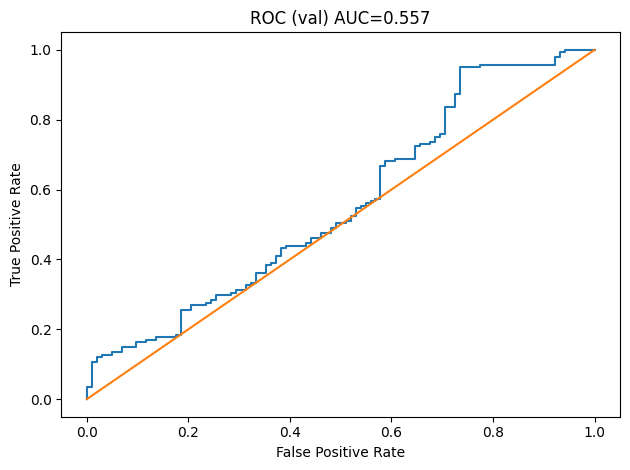

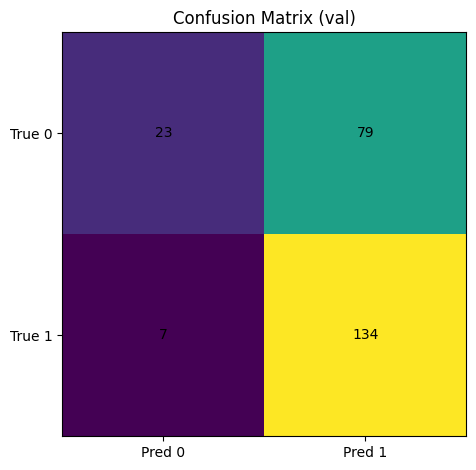

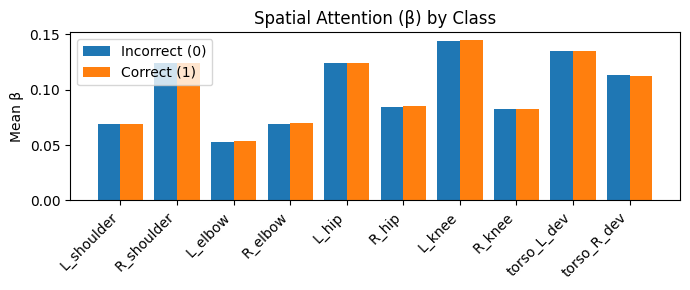

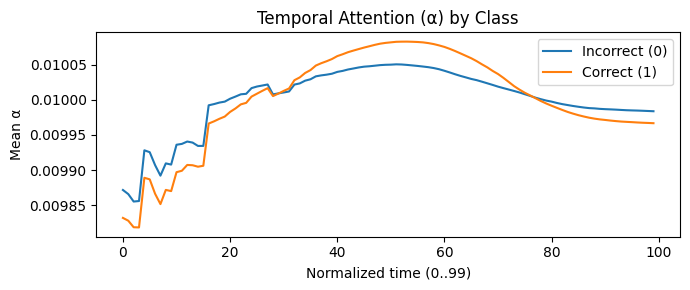

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc as sk_auc

# --- 1) ROC ---
fpr, tpr, _ = roc_curve(y_true_val, p1_val)
roc_auc = sk_auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC (val) AUC={roc_auc:.3f}")
plt.tight_layout()
plt.savefig("Fig_ROC_val.png", dpi=200)
plt.show()

# --- 2) Confusion matrix ---
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (val)")
plt.xticks([0,1], ["Pred 0","Pred 1"])
plt.yticks([0,1], ["True 0","True 1"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i,j]), ha="center", va="center")
plt.tight_layout()
plt.savefig("Fig_CM_val.png", dpi=200)
plt.show()

# --- helpers to extract alpha/beta on a set of trial_ids ---
ANGLE_NAMES_10 = [
    "L_shoulder", "R_shoulder",
    "L_elbow", "R_elbow",
    "L_hip", "R_hip",
    "L_knee", "R_knee",
    "torso_L_dev", "torso_R_dev"
]

def infer_attention(model, trial_ids, batch=256):
    loader, _ = make_loader(trial_ids, batch=batch, shuffle=False)
    model.eval()
    rows = []
    with torch.no_grad():
        for X, y, tids in loader:
            X = X.to(device)
            logits, alpha, beta = model(X)
            prob1 = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
            pred  = torch.argmax(logits, dim=1).cpu().numpy()
            alpha = alpha.cpu().numpy()  # (B,100)
            beta  = beta.cpu().numpy()   # (B,10)
            y = y.numpy()
            tids = list(tids)
            for i in range(len(tids)):
                rows.append({
                    "trial_id": tids[i],
                    "y_true": int(y[i]),
                    "y_hat": int(pred[i]),
                    "p_correct": float(prob1[i]),
                    "alpha": alpha[i],
                    "beta": beta[i],
                })
    return rows

# use ALL data for visualization (not for official performance claims)
all_ids = meta_df["trial_id"].tolist()
rows_all = infer_attention(final_model, all_ids, batch=256)

# split by class
beta_correct = np.stack([r["beta"] for r in rows_all if r["y_true"]==1], axis=0)
beta_incor   = np.stack([r["beta"] for r in rows_all if r["y_true"]==0], axis=0)

alpha_correct = np.stack([r["alpha"] for r in rows_all if r["y_true"]==1], axis=0)
alpha_incor   = np.stack([r["alpha"] for r in rows_all if r["y_true"]==0], axis=0)

# --- 3) Mean beta by class ---
m1 = beta_correct.mean(axis=0)
m0 = beta_incor.mean(axis=0)

plt.figure(figsize=(7,3))
x = np.arange(len(ANGLE_NAMES_10))
plt.bar(x-0.2, m0, width=0.4, label="Incorrect (0)")
plt.bar(x+0.2, m1, width=0.4, label="Correct (1)")
plt.xticks(x, ANGLE_NAMES_10, rotation=45, ha="right")
plt.ylabel("Mean β")
plt.title("Spatial Attention (β) by Class")
plt.legend()
plt.tight_layout()
plt.savefig("Fig_Beta_byClass.png", dpi=200)
plt.show()

# --- 4) Mean alpha by class ---
a1 = alpha_correct.mean(axis=0)
a0 = alpha_incor.mean(axis=0)

plt.figure(figsize=(7,3))
plt.plot(a0, label="Incorrect (0)")
plt.plot(a1, label="Correct (1)")
plt.xlabel("Normalized time (0..99)")
plt.ylabel("Mean α")
plt.title("Temporal Attention (α) by Class")
plt.legend()
plt.tight_layout()
plt.savefig("Fig_Alpha_byClass.png", dpi=200)
plt.show()

### B4) Attention–Effect Alignment figure (β vs |Cohen’s d|)

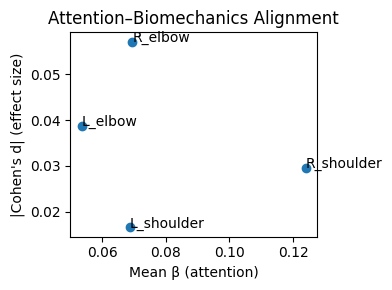

In [ ]:
# Build mapping from feature name -> abs Cohen's d
# stat_df feature values like 'jerk_L_shoulder', 'rom_R_elbow'...
d_map = {row["feature"]: abs(row["cohens_d (correct - incorrect)"]) for _, row in stat_df.iterrows()}

# pick the jerk features for joints we have in beta (most meaningful)
targets = [
    ("L_shoulder", "jerk_L_shoulder"),
    ("R_shoulder", "jerk_R_shoulder"),
    ("L_elbow", "jerk_L_elbow"),
    ("R_elbow", "jerk_R_elbow"),
]

# attention: use mean beta over ALL samples (or over incorrect only)
mean_beta_all = np.stack([r["beta"] for r in rows_all], axis=0).mean(axis=0)
beta_idx = {name:i for i,name in enumerate(ANGLE_NAMES_10)}

xs, ys, labels = [], [], []
for joint, feat in targets:
    xs.append(mean_beta_all[beta_idx[joint]])
    ys.append(d_map.get(feat, np.nan))
    labels.append(joint)

plt.figure(figsize=(4,3))
plt.scatter(xs, ys)
for i, lab in enumerate(labels):
    plt.text(xs[i], ys[i], lab)
plt.xlabel("Mean β (attention)")
plt.ylabel("|Cohen's d| (effect size)")
plt.title("Attention–Biomechanics Alignment")
plt.tight_layout()
plt.savefig("Fig_Attention_Effect_Alignment.png", dpi=200)
plt.show()

### B5) One correct + one incorrect example figure (α + β)

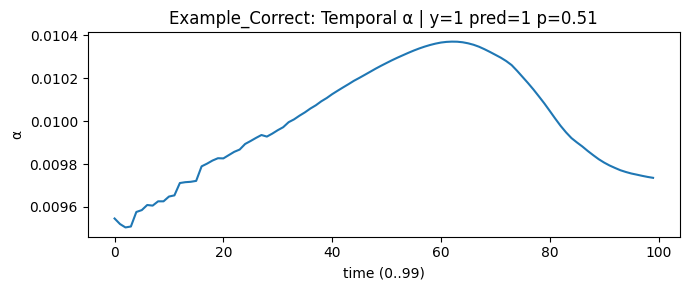

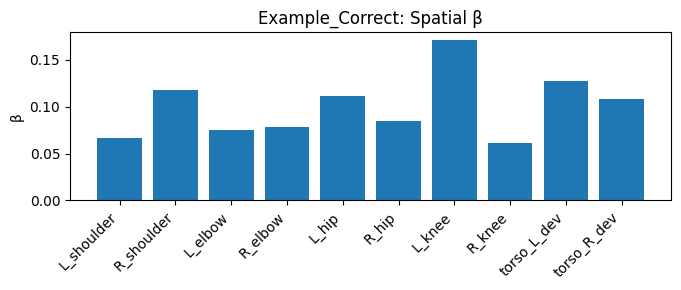

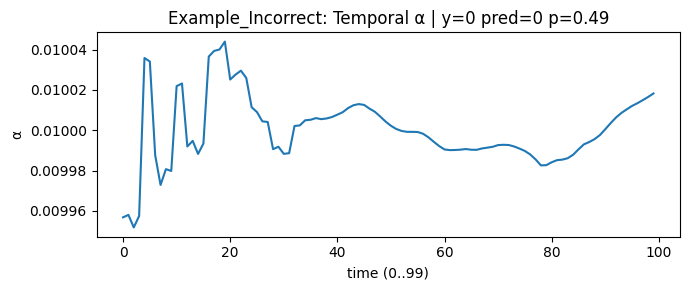

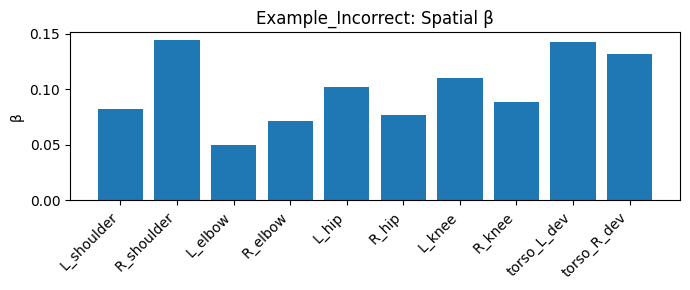

In [ ]:
# choose a high-confidence correct and incorrect from the ALL-data inference
correct_ex = max([r for r in rows_all if r["y_true"]==1], key=lambda r: r["p_correct"])
incorrect_ex = min([r for r in rows_all if r["y_true"]==0], key=lambda r: r["p_correct"])  # confident incorrect

def plot_example(r, name):
    alpha = r["alpha"]
    beta  = r["beta"]
    plt.figure(figsize=(7,3))
    plt.plot(alpha)
    plt.title(f"{name}: Temporal α | y={r['y_true']} pred={r['y_hat']} p={r['p_correct']:.2f}")
    plt.xlabel("time (0..99)")
    plt.ylabel("α")
    plt.tight_layout()
    plt.savefig(f"Fig_{name}_alpha.png", dpi=200)
    plt.show()

    plt.figure(figsize=(7,3))
    plt.bar(np.arange(len(ANGLE_NAMES_10)), beta)
    plt.xticks(np.arange(len(ANGLE_NAMES_10)), ANGLE_NAMES_10, rotation=45, ha="right")
    plt.ylabel("β")
    plt.title(f"{name}: Spatial β")
    plt.tight_layout()
    plt.savefig(f"Fig_{name}_beta.png", dpi=200)
    plt.show()

plot_example(correct_ex, "Example_Correct")
plot_example(incorrect_ex, "Example_Incorrect")

## Section B: Via Shallow Modeling

In [ ]:
# ============================================
# Generalized LR-on-angles with nested C tuning
# ============================================
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score, confusion_matrix

# -----------------------------
# Helpers
# -----------------------------
def _stack_angles(meta_sub, angles_cache):
    """meta_sub: DataFrame with trial_id, y. Returns X (N,1000), y (N,)"""
    tids = meta_sub["trial_id"].tolist()
    X = np.stack([angles_cache[tid].reshape(-1) for tid in tids], axis=0).astype(np.float32)
    y = meta_sub["y"].values.astype(int)
    return X, y, tids

def _make_lr(C=1.0):
    # liblinear is robust for small datasets; saga also ok but needs more iters.
    return Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(
            C=float(C),
            penalty="l2",
            solver="liblinear",
            class_weight="balanced",
            max_iter=4000
        ))
    ])

def _eval_metrics(y_true, y_pred, p1):
    bal = balanced_accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, p1) if len(np.unique(y_true)) == 2 else np.nan
    cm  = confusion_matrix(y_true, y_pred)
    return bal, f1, auc, cm

# -----------------------------
# Nested CV
# -----------------------------
def generalized_lr_nested_cv(meta_df, angles_cache,
                             n_outer=5, n_inner=4,
                             C_grid=(0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0),
                             seed=42):
    """
    Subject-disjoint generalized evaluation:
      Outer: GroupKFold over subject
      Inner: GroupKFold over subject (within outer-train) to pick C by mean balanced accuracy

    Returns:
      fold_df: per-fold test metrics + chosen C
      preds_df: per-trial predictions for all outer test folds
    """
    outer = GroupKFold(n_splits=n_outer)

    fold_rows = []
    pred_rows = []

    # sanity
    assert {"trial_id", "subject", "y"}.issubset(set(meta_df.columns)), \
        "meta_df must contain: trial_id, subject, y"

    for fold, (tr_idx, te_idx) in enumerate(outer.split(meta_df, groups=meta_df["subject"]), start=1):
        meta_tr = meta_df.iloc[tr_idx].reset_index(drop=True)
        meta_te = meta_df.iloc[te_idx].reset_index(drop=True)

        # -------- inner tuning on meta_tr --------
        inner = GroupKFold(n_splits=min(n_inner, meta_tr["subject"].nunique()))
        # If too few subjects for n_inner, GroupKFold will fail; guard:
        if meta_tr["subject"].nunique() < 2:
            raise ValueError("Not enough subjects in training fold for inner CV.")

        C_scores = []
        for C in C_grid:
            bals = []
            for itr_idx, iva_idx in inner.split(meta_tr, groups=meta_tr["subject"]):
                inner_tr = meta_tr.iloc[itr_idx]
                inner_va = meta_tr.iloc[iva_idx]

                Xtr, ytr, _ = _stack_angles(inner_tr, angles_cache)
                Xva, yva, _ = _stack_angles(inner_va, angles_cache)

                clf = _make_lr(C=C)
                clf.fit(Xtr, ytr)

                p1 = clf.predict_proba(Xva)[:, 1]
                yhat = (p1 >= 0.5).astype(int)
                bal = balanced_accuracy_score(yva, yhat)
                bals.append(bal)

            C_scores.append((float(C), float(np.mean(bals)), float(np.std(bals))))

        # pick best C by mean bal acc; tie-breaker: smaller C (more regularization)
        C_scores = sorted(C_scores, key=lambda x: (x[1], -x[0]), reverse=True)
        best_C, best_mean, best_std = C_scores[0]

        # -------- train on full meta_tr with best_C, test on meta_te --------
        Xtr, ytr, tr_ids = _stack_angles(meta_tr, angles_cache)
        Xte, yte, te_ids = _stack_angles(meta_te, angles_cache)

        clf = _make_lr(C=best_C)
        clf.fit(Xtr, ytr)

        p1 = clf.predict_proba(Xte)[:, 1]
        yhat = (p1 >= 0.5).astype(int)

        bal, f1, auc, cm = _eval_metrics(yte, yhat, p1)

        fold_rows.append({
            "fold": fold,
            "n_train": len(meta_tr),
            "n_test": len(meta_te),
            "n_train_subjects": int(meta_tr["subject"].nunique()),
            "n_test_subjects": int(meta_te["subject"].nunique()),
            "best_C": best_C,
            "inner_bal_mean": best_mean,
            "inner_bal_std": best_std,
            "bal_acc": float(bal),
            "f1": float(f1),
            "auc": float(auc),
            "cm_00": int(cm[0,0]), "cm_01": int(cm[0,1]),
            "cm_10": int(cm[1,0]), "cm_11": int(cm[1,1]),
        })

        # per-trial preds for later analyses/explanations
        for tid, yt, yh, prob in zip(te_ids, yte, yhat, p1):
            # attach exercise if available
            ex = None
            if "gesture" in meta_df.columns:
                ex = int(meta_df.loc[meta_df["trial_id"] == tid, "gesture"].iloc[0])
            pred_rows.append({
                "fold": fold,
                "trial_id": tid,
                "subject": int(meta_df.loc[meta_df["trial_id"] == tid, "subject"].iloc[0]),
                "exercise": ex,
                "y_true": int(yt),
                "y_hat": int(yh),
                "p_correct": float(prob),
                "best_C": best_C
            })

        print(f"[Fold {fold}] best_C={best_C} | inner_bal={best_mean:.3f}±{best_std:.3f} "
              f"| TEST bal={bal:.3f} f1={f1:.3f} auc={auc:.3f} | cm={cm.tolist()}")

    fold_df = pd.DataFrame(fold_rows)
    preds_df = pd.DataFrame(pred_rows)

    return fold_df, preds_df

In [ ]:
# -----------------------------
# Run
# -----------------------------
C_GRID = (0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0)

fold_lr_angles, preds_lr_angles = generalized_lr_nested_cv(
    meta_df=meta_df,
    angles_cache=angles_cache,
    n_outer=5,
    n_inner=4,
    C_grid=C_GRID,
    seed=42
)

print("\nPer-fold metrics:")
display(fold_lr_angles)

print("\nSummary:")
print(fold_lr_angles[["bal_acc","f1","auc"]].agg(["mean","std","min","max"]))


[Fold 1] best_C=0.3 | inner_bal=0.583±0.034 | TEST bal=0.483 f1=0.397 auc=0.529 | cm=[[38, 20], [53, 24]]
[Fold 2] best_C=10.0 | inner_bal=0.573±0.034 | TEST bal=0.498 f1=0.560 auc=0.508 | cm=[[45, 52], [66, 75]]
[Fold 3] best_C=0.01 | inner_bal=0.529±0.021 | TEST bal=0.602 f1=0.628 auc=0.565 | cm=[[52, 75], [21, 81]]
[Fold 4] best_C=0.01 | inner_bal=0.502±0.032 | TEST bal=0.614 f1=0.571 auc=0.647 | cm=[[82, 30], [63, 62]]
[Fold 5] best_C=0.1 | inner_bal=0.564±0.063 | TEST bal=0.507 f1=0.614 auc=0.554 | cm=[[32, 78], [34, 89]]

Per-fold metrics:


,fold,n_train,n_test,n_train_subjects,n_test_subjects,best_C,inner_bal_mean,inner_bal_std,bal_acc,f1,auc,cm_00,cm_01,cm_10,cm_11
0,1,937,135,8,2,0.30,0.583371,0.034362,0.483430,0.396694,0.528885,38,20,53,24
1,2,834,238,8,2,10.00,0.573364,0.034251,0.497916,0.559701,0.508152,45,52,66,75
2,3,843,229,8,2,0.01,0.529373,0.020579,0.601783,0.627907,0.565308,52,75,21,81
3,4,835,237,8,2,0.01,0.502337,0.031575,0.614071,0.571429,0.647357,82,30,63,62
4,5,839,233,8,2,0.10,0.563849,0.062598,0.507243,0.613793,0.553732,32,78,34,89



Summary:
       bal_acc        f1       auc
mean  0.540889  0.553905  0.560687
std   0.061935  0.092356  0.053275
min   0.483430  0.396694  0.508152
max   0.614071  0.627907  0.647357


In [ ]:
# optional save
# fold_lr_angles.to_csv("generalized_lr_angles_fold_reports.csv", index=False)
# preds_lr_angles.to_csv("generalized_lr_angles_preds.csv", index=False)

## Stats

In [ ]:
import numpy as np
from scipy.stats import wilcoxon

# DA (REHAB24-6 generalized) — from fold_df bal_acc
da = np.array([0.483654, 0.521788, 0.441948, 0.426464, 0.492129])

# LR (REHAB24-6 generalized) — from LR per-fold metrics bal_acc
lr = np.array([0.483430, 0.497916, 0.601783, 0.614071, 0.507243])

diff = lr - da
stat, p = wilcoxon(diff)

print("Wilcoxon p-value:", p)
print("Median difference (LR - DA):", np.median(diff))
print("Mean difference (LR - DA):", np.mean(diff))
print("% folds LR > DA:", np.mean(diff > 0))
print("Diff per fold (LR-DA):", diff)

Wilcoxon p-value: 0.4375
Median difference (LR - DA): 0.015114000000000016
Mean difference (LR - DA): 0.067692
% folds LR > DA: 0.6
Diff per fold (LR-DA): [-0.000224 -0.023872  0.159835  0.187607  0.015114]


# Per exercise modeling

## DA

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold

def run_per_exercise_cv(
    meta_df, angles_cache,
    n_splits_max=5,
    n_trials_optuna=25,
    seed_base=1000,
    epochs_final=60
):
    """
    Runs the same outer CV you already have, but separately for each exercise (gesture).
    Subject-disjoint within each exercise.
    Returns:
      ex_summary_df: per-exercise mean±std of metrics
      ex_fold_df: per-exercise, per-fold metrics
      ex_param_df: per-exercise, per-fold best params
      models_by_ex: dict[(ex, fold)] = trained model
      splits_by_ex: dict[(ex, fold)] = {train_meta, test_meta, ...}
    """
    ex_fold_rows = []
    ex_param_rows = []
    models_by_ex = {}
    splits_by_ex = {}

    for ex in sorted(meta_df["gesture"].unique()):
        meta_ex = meta_df[meta_df["gesture"] == ex].reset_index(drop=True)

        n_subj = meta_ex["subject"].nunique()
        n_trials = len(meta_ex)
        y_counts = meta_ex["y"].value_counts().to_dict()

        print("\n" + "="*60)
        print(f"Exercise {ex} | trials={n_trials} | subjects={n_subj} | y={y_counts}")

        # If too few subjects, GroupKFold can't run meaningfully
        if n_subj < 3:
            print(f"Skipping exercise {ex}: only {n_subj} subjects.")
            continue

        n_splits = min(n_splits_max, n_subj)
        gkf = GroupKFold(n_splits=n_splits)

        for fold, (tr_idx, te_idx) in enumerate(gkf.split(meta_ex, groups=meta_ex["subject"]), start=1):
            meta_train = meta_ex.iloc[tr_idx].reset_index(drop=True)
            meta_test  = meta_ex.iloc[te_idx].reset_index(drop=True)

            # (optional) sanity check: ensure both classes exist in train/test
            tr_classes = set(meta_train["y"].unique())
            te_classes = set(meta_test["y"].unique())
            if len(tr_classes) < 2 or len(te_classes) < 2:
                print(f"[Ex {ex} Fold {fold}] Skipping: class missing in train/test. "
                      f"train={tr_classes}, test={te_classes}")
                continue

            # Tune on meta_train (subject-disjoint inner split already inside tune_params_for_fold)
            best_params, best_val_bal = tune_params_for_fold(
                meta_train, angles_cache,
                n_trials=n_trials_optuna,
                seed=seed_base + ex*10 + fold
            )

            ex_param_rows.append({
                "exercise": ex,
                "fold": fold,
                "best_val_bal": float(best_val_bal),
                **best_params
            })

            rep, model = train_final_and_eval(
                meta_train, meta_test,
                angles_cache,
                best_params,
                epochs=epochs_final
            )

            rep_row = {
                "exercise": ex,
                "fold": fold,
                **rep
            }
            ex_fold_rows.append(rep_row)

            models_by_ex[(ex, fold)] = model
            splits_by_ex[(ex, fold)] = {
                "train_meta": meta_train,
                "test_meta": meta_test,
                "train_ids": meta_train["trial_id"].tolist(),
                "test_ids": meta_test["trial_id"].tolist(),
                "best_params": best_params,
                "best_val_bal": float(best_val_bal)
            }

            print(f"[Ex {ex} Fold {fold}] tuned_val_bal={best_val_bal:.3f} | "
                  f"TEST bal={rep['bal_acc']:.3f} f1={rep['f1']:.3f} auc={rep['auc']:.3f} n={rep['n_test']}")

    ex_fold_df = pd.DataFrame(ex_fold_rows)
    ex_param_df = pd.DataFrame(ex_param_rows)

    # summarize per exercise
    def mean_std(s):
        return pd.Series({"mean": float(np.mean(s)), "std": float(np.std(s))})

    ex_summary_df = (ex_fold_df
        .groupby("exercise")[["bal_acc","f1","auc"]]
        .agg(["mean","std","count"])
        .reset_index()
    )

    return ex_summary_df, ex_fold_df, ex_param_df, models_by_ex, splits_by_ex

In [ ]:
ex_summary_df, ex_fold_df, ex_param_df, models_by_ex, splits_by_ex = run_per_exercise_cv(
    meta_df=meta_df,
    angles_cache=angles_cache,
    n_splits_max=5,
    n_trials_optuna=25,
    seed_base=42,
    epochs_final=60
)

ex_summary_df

[I 2026-02-16 01:20:03,015] A new study created in memory with name: no-name-80be8211-15df-4008-8ca9-3c11df8ac62d



Exercise 1 | trials=178 | subjects=9 | y={1: 90, 0: 88}


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:20:03,359] Trial 0 finished with value: 0.5 and parameters: {'hidden': 32, 'levels': 5, 'kernel': 5, 'dropout': 0.09034349669269212, 'lr': 0.0002421129781963895, 'wd': 1.3896455099037473e-06, 'batch': 128}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:20:03,517] Trial 1 finished with value: 0.5 and parameters: {'hidden': 32, 'levels': 3, 'kernel': 3, 'dropout': 0.18235628586657748, 'lr': 0.0018764149902785864, 'wd': 0.000490856484862787, 'batch': 128}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:20:03,854] Trial 2 finished with value: 0.5333333333333333 and parameters: {'hidden': 64, 'levels': 5, 'kernel': 3, 'dropout': 0.13030547136587034, 'lr': 0.0019064019480886675, 'wd': 4.9932839152652334e-06, 'batch': 128}. Best is trial 2 with value: 0.5333333333333333.
[I 2026-02-16 01:20:04,137] Trial 3 finished with value: 0.5 and parameters: {'hidden': 128, 'levels': 5, 'kernel': 3, 'dropout': 0.2103396869143535, 'lr': 0.0001724766347209979, 'wd': 0.00066574672680

[I 2026-02-16 01:20:12,583] A new study created in memory with name: no-name-72c469a7-e3b7-47c5-ab6c-44db3c2957de


[Ex 1 Fold 1] tuned_val_bal=0.667 | TEST bal=0.457 f1=0.625 auc=0.379 n=24


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:20:13,003] Trial 0 finished with value: 0.6059523809523809 and parameters: {'hidden': 128, 'levels': 4, 'kernel': 3, 'dropout': 0.16746860899409943, 'lr': 0.00039621405634428496, 'wd': 3.705894427972908e-06, 'batch': 128}. Best is trial 0 with value: 0.6059523809523809.
[I 2026-02-16 01:20:13,211] Trial 1 finished with value: 0.638095238095238 and parameters: {'hidden': 128, 'levels': 3, 'kernel': 5, 'dropout': 0.1882270856678031, 'lr': 0.00022251074302258146, 'wd': 0.0003703834024405036, 'batch': 128}. Best is trial 1 with value: 0.638095238095238.
[I 2026-02-16 01:20:13,381] Trial 2 finished with value: 0.5 and parameters: {'hidden': 96, 'levels': 4, 'kernel': 3, 'dropout': 0.11511864541197028, 'lr': 0.00017274132825385876, 'wd': 0.0006933071525984874, 'batch': 128}. Best is trial 1 with value: 0.638095238095238.
[I 2026-02-16 01:20:13,792] Trial 3 finished with value: 0.5238095238095238 and parameters: {'hidden': 32, 'levels': 5, 'kernel': 3, 'dropout': 0.2633183830

[I 2026-02-16 01:20:21,962] A new study created in memory with name: no-name-333b1fd7-71da-4244-91f7-f359aa9f0234


[Ex 1 Fold 2] tuned_val_bal=0.638 | TEST bal=0.500 f1=0.667 auc=0.754 n=32


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:20:22,172] Trial 0 finished with value: 0.5 and parameters: {'hidden': 64, 'levels': 5, 'kernel': 7, 'dropout': 0.06542861266516528, 'lr': 0.0013990311581340402, 'wd': 1.0651648533989916e-06, 'batch': 128}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:20:22,361] Trial 1 finished with value: 0.6875 and parameters: {'hidden': 32, 'levels': 4, 'kernel': 3, 'dropout': 0.2837333870451184, 'lr': 0.0003932110224583157, 'wd': 0.000529644849944297, 'batch': 128}. Best is trial 1 with value: 0.6875.
[I 2026-02-16 01:20:22,644] Trial 2 finished with value: 0.8125 and parameters: {'hidden': 96, 'levels': 3, 'kernel': 3, 'dropout': 0.3265371073274681, 'lr': 0.0011100901200601122, 'wd': 1.6417546971364426e-06, 'batch': 64}. Best is trial 2 with value: 0.8125.
[I 2026-02-16 01:20:22,928] Trial 3 finished with value: 0.5 and parameters: {'hidden': 64, 'levels': 3, 'kernel': 7, 'dropout': 0.11083251839044414, 'lr': 0.0013773927374687747, 'wd': 0.0003113851213368618, 'batch': 32}. 

[I 2026-02-16 01:20:29,310] A new study created in memory with name: no-name-9ff699cb-9f1b-4948-8492-adcd82676043


[Ex 1 Fold 3] tuned_val_bal=0.844 | TEST bal=0.500 f1=0.656 auc=0.748 n=41


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:20:29,535] Trial 0 finished with value: 0.5 and parameters: {'hidden': 32, 'levels': 4, 'kernel': 5, 'dropout': 0.147840026105093, 'lr': 0.00013585680668716854, 'wd': 0.0003181656203325291, 'batch': 64}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:20:29,741] Trial 1 finished with value: 0.5 and parameters: {'hidden': 128, 'levels': 3, 'kernel': 7, 'dropout': 0.2737151141376187, 'lr': 0.0011958046389227166, 'wd': 0.0009344872042495526, 'batch': 128}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:20:30,052] Trial 2 finished with value: 0.7619047619047619 and parameters: {'hidden': 96, 'levels': 4, 'kernel': 3, 'dropout': 0.2858228084651469, 'lr': 0.00017547875290040347, 'wd': 0.00017100652895714693, 'batch': 64}. Best is trial 2 with value: 0.7619047619047619.
[I 2026-02-16 01:20:30,496] Trial 3 finished with value: 0.8809523809523809 and parameters: {'hidden': 96, 'levels': 3, 'kernel': 3, 'dropout': 0.18758624048499095, 'lr': 0.00011411203759905284, 'wd': 0.0

[I 2026-02-16 01:20:39,523] A new study created in memory with name: no-name-a54147fd-9ab9-4bfc-97bf-c285e4813004


[Ex 1 Fold 4] tuned_val_bal=0.881 | TEST bal=0.631 f1=0.571 auc=0.671 n=41


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:20:39,915] Trial 0 finished with value: 0.5 and parameters: {'hidden': 96, 'levels': 5, 'kernel': 3, 'dropout': 0.07154118636489135, 'lr': 0.0021243988741050713, 'wd': 1.8261711528833845e-05, 'batch': 32}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:20:40,306] Trial 1 finished with value: 0.5083333333333333 and parameters: {'hidden': 96, 'levels': 5, 'kernel': 5, 'dropout': 0.05575791131647323, 'lr': 0.001162702102200075, 'wd': 1.3316730034835486e-06, 'batch': 128}. Best is trial 1 with value: 0.5083333333333333.
[I 2026-02-16 01:20:41,175] Trial 2 finished with value: 0.5428571428571429 and parameters: {'hidden': 128, 'levels': 4, 'kernel': 3, 'dropout': 0.30580368437600436, 'lr': 0.0006369817555703516, 'wd': 3.912138516172479e-06, 'batch': 32}. Best is trial 2 with value: 0.5428571428571429.
[I 2026-02-16 01:20:41,510] Trial 3 finished with value: 0.5 and parameters: {'hidden': 64, 'levels': 4, 'kernel': 7, 'dropout': 0.28265650437404716, 'lr': 0.00088572861373

[I 2026-02-16 01:20:50,047] A new study created in memory with name: no-name-791bca4b-81d1-4bb7-8949-b498b8db2931


[Ex 1 Fold 5] tuned_val_bal=0.643 | TEST bal=0.500 f1=0.000 auc=0.417 n=40

Exercise 2 | trials=208 | subjects=9 | y={0: 114, 1: 94}


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:20:50,348] Trial 0 finished with value: 0.5 and parameters: {'hidden': 32, 'levels': 4, 'kernel': 5, 'dropout': 0.07677389328580853, 'lr': 0.0004650142136909094, 'wd': 0.0002090034870870426, 'batch': 64}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:20:50,618] Trial 1 finished with value: 0.5 and parameters: {'hidden': 96, 'levels': 3, 'kernel': 3, 'dropout': 0.057023137051422194, 'lr': 0.0022887670000193783, 'wd': 0.00010169816220379505, 'batch': 64}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:20:51,144] Trial 2 finished with value: 0.5 and parameters: {'hidden': 128, 'levels': 5, 'kernel': 7, 'dropout': 0.08307025225282419, 'lr': 0.0003920163290423204, 'wd': 6.103819960716893e-06, 'batch': 64}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:20:51,394] Trial 3 finished with value: 0.5 and parameters: {'hidden': 32, 'levels': 3, 'kernel': 5, 'dropout': 0.32373168992119417, 'lr': 0.0017833792149911255, 'wd': 0.000722773861102422, 'batch': 64}. Best is tri

[I 2026-02-16 01:21:02,085] A new study created in memory with name: no-name-28829531-7065-4a97-9edf-eac190c52821


[Ex 2 Fold 1] tuned_val_bal=0.564 | TEST bal=0.732 f1=0.741 auc=0.863 n=26


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:21:02,359] Trial 0 finished with value: 0.5 and parameters: {'hidden': 96, 'levels': 3, 'kernel': 5, 'dropout': 0.2656251116554878, 'lr': 0.0006450573650635512, 'wd': 5.574748099282604e-05, 'batch': 128}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:21:03,286] Trial 1 finished with value: 0.6666666666666667 and parameters: {'hidden': 64, 'levels': 3, 'kernel': 7, 'dropout': 0.309798240067208, 'lr': 0.00023863519694689302, 'wd': 6.372423604812201e-05, 'batch': 32}. Best is trial 1 with value: 0.6666666666666667.
[I 2026-02-16 01:21:03,534] Trial 2 finished with value: 0.5 and parameters: {'hidden': 32, 'levels': 5, 'kernel': 7, 'dropout': 0.23698484125254238, 'lr': 0.00023384895306809378, 'wd': 2.4707931584474723e-06, 'batch': 64}. Best is trial 1 with value: 0.6666666666666667.
[I 2026-02-16 01:21:03,964] Trial 3 finished with value: 0.625 and parameters: {'hidden': 128, 'levels': 5, 'kernel': 5, 'dropout': 0.3396665488658231, 'lr': 0.00023412861755967528, 'wd': 5

[I 2026-02-16 01:21:12,681] A new study created in memory with name: no-name-cd2e5c7c-915b-4986-8f21-2f8814210134


[Ex 2 Fold 2] tuned_val_bal=0.729 | TEST bal=0.379 f1=0.216 auc=0.299 n=46


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:21:13,075] Trial 0 finished with value: 0.6136363636363636 and parameters: {'hidden': 96, 'levels': 5, 'kernel': 3, 'dropout': 0.11901188797963226, 'lr': 0.0005584735652435903, 'wd': 2.526707031625365e-06, 'batch': 128}. Best is trial 0 with value: 0.6136363636363636.
[I 2026-02-16 01:21:13,632] Trial 1 finished with value: 0.5 and parameters: {'hidden': 128, 'levels': 5, 'kernel': 5, 'dropout': 0.20977177354602217, 'lr': 0.0004559388345396567, 'wd': 3.4606736945174726e-06, 'batch': 32}. Best is trial 0 with value: 0.6136363636363636.
[I 2026-02-16 01:21:13,966] Trial 2 finished with value: 0.5227272727272727 and parameters: {'hidden': 32, 'levels': 5, 'kernel': 5, 'dropout': 0.1732371662851585, 'lr': 0.0002054632337236625, 'wd': 1.7059617210545514e-05, 'batch': 64}. Best is trial 0 with value: 0.6136363636363636.
[I 2026-02-16 01:21:14,376] Trial 3 finished with value: 0.5 and parameters: {'hidden': 32, 'levels': 3, 'kernel': 5, 'dropout': 0.2935313308342066, 'lr': 0.

[I 2026-02-16 01:21:22,820] A new study created in memory with name: no-name-1fd74c24-eee3-4ded-9476-3b9edad13ac5


[Ex 2 Fold 3] tuned_val_bal=0.659 | TEST bal=0.584 f1=0.667 auc=0.646 n=45


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:21:23,078] Trial 0 finished with value: 0.5 and parameters: {'hidden': 128, 'levels': 5, 'kernel': 3, 'dropout': 0.07615280108268745, 'lr': 0.0016775462401956644, 'wd': 7.869038624929547e-06, 'batch': 128}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:21:23,247] Trial 1 finished with value: 0.5 and parameters: {'hidden': 96, 'levels': 3, 'kernel': 3, 'dropout': 0.08465017591580877, 'lr': 0.00013875163994131397, 'wd': 1.7836477616204572e-06, 'batch': 128}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:21:23,455] Trial 2 finished with value: 0.5 and parameters: {'hidden': 96, 'levels': 3, 'kernel': 7, 'dropout': 0.33340133054567755, 'lr': 0.00011392998042905713, 'wd': 0.0007432249361778695, 'batch': 128}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:21:23,714] Trial 3 finished with value: 0.640625 and parameters: {'hidden': 32, 'levels': 4, 'kernel': 3, 'dropout': 0.2449564362683896, 'lr': 0.00021904859879767261, 'wd': 0.00014144106960570308, 'batch': 128}.

[I 2026-02-16 01:21:31,526] A new study created in memory with name: no-name-173e6807-3eeb-4813-a1ad-57a670327f16


[Ex 2 Fold 4] tuned_val_bal=0.828 | TEST bal=0.614 f1=0.514 auc=0.448 n=46


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:21:31,732] Trial 0 finished with value: 0.5 and parameters: {'hidden': 64, 'levels': 4, 'kernel': 3, 'dropout': 0.29639325481534934, 'lr': 0.0007486227441546435, 'wd': 5.704459815946293e-06, 'batch': 128}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:21:32,334] Trial 1 finished with value: 0.5481818181818181 and parameters: {'hidden': 128, 'levels': 4, 'kernel': 3, 'dropout': 0.2155933517680263, 'lr': 0.0011130236949854991, 'wd': 0.000724892588772583, 'batch': 32}. Best is trial 1 with value: 0.5481818181818181.
[I 2026-02-16 01:21:32,660] Trial 2 finished with value: 0.5 and parameters: {'hidden': 128, 'levels': 5, 'kernel': 5, 'dropout': 0.26208327125643005, 'lr': 0.00025388021746936934, 'wd': 5.586440718918822e-06, 'batch': 128}. Best is trial 1 with value: 0.5481818181818181.
[I 2026-02-16 01:21:32,868] Trial 3 finished with value: 0.5 and parameters: {'hidden': 128, 'levels': 4, 'kernel': 3, 'dropout': 0.25290172497182106, 'lr': 0.00043048134209624833, 'wd': 

[I 2026-02-16 01:21:42,597] A new study created in memory with name: no-name-86c8801a-9a91-4ca5-bf0d-914d3e545bd2


[Ex 2 Fold 5] tuned_val_bal=0.615 | TEST bal=0.308 f1=0.302 auc=0.212 n=45

Exercise 3 | trials=107 | subjects=10 | y={0: 55, 1: 52}


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:21:42,977] Trial 0 finished with value: 0.75 and parameters: {'hidden': 32, 'levels': 3, 'kernel': 5, 'dropout': 0.17122495231776919, 'lr': 0.0007612828311752936, 'wd': 5.300346975208043e-06, 'batch': 32}. Best is trial 0 with value: 0.75.
[I 2026-02-16 01:21:43,259] Trial 1 finished with value: 1.0 and parameters: {'hidden': 96, 'levels': 3, 'kernel': 3, 'dropout': 0.10800078721342199, 'lr': 0.0002493865130504519, 'wd': 0.000852353410966321, 'batch': 32}. Best is trial 1 with value: 1.0.
[I 2026-02-16 01:21:43,415] Trial 2 finished with value: 0.5 and parameters: {'hidden': 64, 'levels': 5, 'kernel': 3, 'dropout': 0.269958824041859, 'lr': 0.0012022278259755533, 'wd': 2.2600734225062696e-06, 'batch': 128}. Best is trial 1 with value: 1.0.
[I 2026-02-16 01:21:43,797] Trial 3 finished with value: 1.0 and parameters: {'hidden': 32, 'levels': 4, 'kernel': 5, 'dropout': 0.25654587400088524, 'lr': 0.00212034075087955, 'wd': 0.00023934315123203367, 'batch': 64}. Best is trial

[I 2026-02-16 01:21:50,082] A new study created in memory with name: no-name-7ad0c9cf-81e9-47db-b4c9-f0d637120e19


[Ex 3 Fold 1] tuned_val_bal=1.000 | TEST bal=0.438 f1=0.625 auc=0.359 n=24


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:21:50,330] Trial 0 finished with value: 0.5 and parameters: {'hidden': 96, 'levels': 4, 'kernel': 5, 'dropout': 0.3109916010368217, 'lr': 0.0005055238563735127, 'wd': 1.7410556097477e-06, 'batch': 64}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:21:50,568] Trial 1 finished with value: 0.5 and parameters: {'hidden': 128, 'levels': 5, 'kernel': 3, 'dropout': 0.30869951077914676, 'lr': 0.00010072901461105074, 'wd': 3.212831933846424e-06, 'batch': 64}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:21:50,936] Trial 2 finished with value: 0.5 and parameters: {'hidden': 128, 'levels': 5, 'kernel': 7, 'dropout': 0.18273232615277551, 'lr': 0.00015973862060810837, 'wd': 4.08167085190484e-06, 'batch': 64}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:21:51,162] Trial 3 finished with value: 0.5 and parameters: {'hidden': 64, 'levels': 5, 'kernel': 3, 'dropout': 0.24376245107165373, 'lr': 0.00010667565980428307, 'wd': 0.0005486768147879102, 'batch': 64}. Best is tria

[I 2026-02-16 01:21:57,728] A new study created in memory with name: no-name-9137b3f2-d193-4dde-963c-3242efbc5077


[Ex 3 Fold 2] tuned_val_bal=0.900 | TEST bal=0.705 f1=0.625 auc=0.800 n=21


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:21:57,978] Trial 0 finished with value: 0.5 and parameters: {'hidden': 128, 'levels': 3, 'kernel': 7, 'dropout': 0.24444236072842024, 'lr': 0.0009824648622723934, 'wd': 0.0006233338380578977, 'batch': 32}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:21:58,151] Trial 1 finished with value: 0.5 and parameters: {'hidden': 128, 'levels': 3, 'kernel': 7, 'dropout': 0.28339852750157984, 'lr': 0.0010636781685989557, 'wd': 0.0007004301396165929, 'batch': 128}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:21:58,310] Trial 2 finished with value: 0.5 and parameters: {'hidden': 32, 'levels': 5, 'kernel': 7, 'dropout': 0.31754195234181815, 'lr': 0.00024646065249306375, 'wd': 0.0006224447015269513, 'batch': 64}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:21:58,590] Trial 3 finished with value: 0.8615384615384616 and parameters: {'hidden': 32, 'levels': 3, 'kernel': 3, 'dropout': 0.31452500192712957, 'lr': 0.0024522066575525087, 'wd': 6.388342546664356e-05, 'batch':

[I 2026-02-16 01:22:03,039] A new study created in memory with name: no-name-e5e28ecc-a402-417c-805c-6bc4c1587789


[Ex 3 Fold 3] tuned_val_bal=0.962 | TEST bal=0.341 f1=0.222 auc=0.518 n=21


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:22:03,202] Trial 0 finished with value: 0.5 and parameters: {'hidden': 64, 'levels': 4, 'kernel': 3, 'dropout': 0.3080579825434048, 'lr': 0.00017548654045586293, 'wd': 9.309311805907551e-05, 'batch': 128}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:22:03,423] Trial 1 finished with value: 0.5 and parameters: {'hidden': 128, 'levels': 5, 'kernel': 5, 'dropout': 0.3104981988123872, 'lr': 0.0016028058935406177, 'wd': 0.0005376717262234086, 'batch': 128}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:22:03,674] Trial 2 finished with value: 0.5 and parameters: {'hidden': 96, 'levels': 4, 'kernel': 3, 'dropout': 0.06134755740087129, 'lr': 0.0010204002185803924, 'wd': 6.30198418842259e-05, 'batch': 32}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:22:03,924] Trial 3 finished with value: 0.5 and parameters: {'hidden': 96, 'levels': 5, 'kernel': 7, 'dropout': 0.3297335692695293, 'lr': 0.00014073947648570682, 'wd': 8.812308548381508e-05, 'batch': 64}. Best is tria

[I 2026-02-16 01:22:09,455] A new study created in memory with name: no-name-003cae1f-adcf-48d3-9824-51ecc7d7460e


[Ex 3 Fold 4] tuned_val_bal=1.000 | TEST bal=0.800 f1=0.750 auc=0.982 n=21


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:22:09,846] Trial 0 finished with value: 0.8846153846153846 and parameters: {'hidden': 32, 'levels': 4, 'kernel': 7, 'dropout': 0.17016635110396677, 'lr': 0.001138741472862224, 'wd': 0.0003236233306657739, 'batch': 32}. Best is trial 0 with value: 0.8846153846153846.
[I 2026-02-16 01:22:10,536] Trial 1 finished with value: 0.916083916083916 and parameters: {'hidden': 128, 'levels': 3, 'kernel': 7, 'dropout': 0.06913145722419686, 'lr': 0.0004344911738235217, 'wd': 1.2374203112362011e-05, 'batch': 64}. Best is trial 1 with value: 0.916083916083916.
[I 2026-02-16 01:22:10,708] Trial 2 finished with value: 0.5 and parameters: {'hidden': 64, 'levels': 3, 'kernel': 7, 'dropout': 0.26881820271601553, 'lr': 0.00028920716026492236, 'wd': 0.0004833544462216693, 'batch': 32}. Best is trial 1 with value: 0.916083916083916.
[I 2026-02-16 01:22:11,139] Trial 3 finished with value: 0.6888111888111889 and parameters: {'hidden': 96, 'levels': 5, 'kernel': 5, 'dropout': 0.090423179186291

[I 2026-02-16 01:22:16,542] A new study created in memory with name: no-name-1b59f39b-9ef6-4a14-9b70-50453cfb1805


[Ex 3 Fold 5] tuned_val_bal=0.962 | TEST bal=0.767 f1=0.588 auc=0.667 n=20

Exercise 4 | trials=210 | subjects=9 | y={1: 120, 0: 90}


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:22:16,930] Trial 0 finished with value: 0.5 and parameters: {'hidden': 128, 'levels': 3, 'kernel': 3, 'dropout': 0.22219727443117765, 'lr': 0.00011738389843982857, 'wd': 1.4496141839424285e-05, 'batch': 32}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:22:17,393] Trial 1 finished with value: 0.5 and parameters: {'hidden': 128, 'levels': 5, 'kernel': 3, 'dropout': 0.2389904816681242, 'lr': 0.00020605388067825467, 'wd': 0.00016388115418552185, 'batch': 32}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:22:17,808] Trial 2 finished with value: 0.5 and parameters: {'hidden': 128, 'levels': 3, 'kernel': 3, 'dropout': 0.19996371021736548, 'lr': 0.0029924205504408114, 'wd': 0.00016532414067409353, 'batch': 32}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:22:18,073] Trial 3 finished with value: 0.5 and parameters: {'hidden': 96, 'levels': 3, 'kernel': 3, 'dropout': 0.09375920692624937, 'lr': 0.00023278827308060147, 'wd': 0.0004909389862950958, 'batch': 64}. Best 

[I 2026-02-16 01:22:31,318] A new study created in memory with name: no-name-4f61dae1-d3f4-4206-a91d-82546e25b4d5


[Ex 4 Fold 1] tuned_val_bal=0.529 | TEST bal=0.567 f1=0.698 auc=0.618 n=30


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:22:31,573] Trial 0 finished with value: 0.5 and parameters: {'hidden': 128, 'levels': 3, 'kernel': 5, 'dropout': 0.13713503762636325, 'lr': 0.0005390476538475619, 'wd': 0.0007961830793281341, 'batch': 64}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:22:31,785] Trial 1 finished with value: 0.5 and parameters: {'hidden': 96, 'levels': 3, 'kernel': 3, 'dropout': 0.2414214247269162, 'lr': 0.0002040045593887362, 'wd': 0.0008615506650609184, 'batch': 64}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:22:32,118] Trial 2 finished with value: 0.5 and parameters: {'hidden': 128, 'levels': 4, 'kernel': 7, 'dropout': 0.34838573063763817, 'lr': 0.0002634030098270621, 'wd': 4.99546368037524e-05, 'batch': 128}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:22:32,337] Trial 3 finished with value: 0.5 and parameters: {'hidden': 128, 'levels': 3, 'kernel': 5, 'dropout': 0.055303796645635395, 'lr': 0.0010755737443767016, 'wd': 0.00026425812044632556, 'batch': 128}. Best is 

[I 2026-02-16 01:22:41,220] A new study created in memory with name: no-name-ebd3081d-b3be-42e4-b255-d3d9361ec4c3


[Ex 4 Fold 2] tuned_val_bal=0.579 | TEST bal=0.657 f1=0.714 auc=0.461 n=47


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:22:42,283] Trial 0 finished with value: 0.6130604288499025 and parameters: {'hidden': 128, 'levels': 4, 'kernel': 5, 'dropout': 0.3277390202536464, 'lr': 0.0002165336271144881, 'wd': 1.646865990933404e-05, 'batch': 32}. Best is trial 0 with value: 0.6130604288499025.
[I 2026-02-16 01:22:42,479] Trial 1 finished with value: 0.5 and parameters: {'hidden': 64, 'levels': 5, 'kernel': 5, 'dropout': 0.16024765988216938, 'lr': 0.00018631823481505275, 'wd': 4.0735915625255244e-05, 'batch': 128}. Best is trial 0 with value: 0.6130604288499025.
[I 2026-02-16 01:22:42,661] Trial 2 finished with value: 0.5 and parameters: {'hidden': 64, 'levels': 4, 'kernel': 7, 'dropout': 0.17588972076549736, 'lr': 0.00021124937722508396, 'wd': 0.0009305922058537092, 'batch': 128}. Best is trial 0 with value: 0.6130604288499025.
[I 2026-02-16 01:22:42,912] Trial 3 finished with value: 0.5 and parameters: {'hidden': 32, 'levels': 5, 'kernel': 7, 'dropout': 0.3147941129061384, 'lr': 0.0006382789479

[I 2026-02-16 01:22:55,683] A new study created in memory with name: no-name-bb977252-d173-4fa9-a512-d3a50d9cd80b


[Ex 4 Fold 3] tuned_val_bal=0.734 | TEST bal=0.605 f1=0.776 auc=0.455 n=45


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:22:55,998] Trial 0 finished with value: 0.5 and parameters: {'hidden': 128, 'levels': 4, 'kernel': 5, 'dropout': 0.12510549110455357, 'lr': 0.0017553140795114992, 'wd': 0.00025089287493139324, 'batch': 64}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:22:56,677] Trial 1 finished with value: 0.5052447552447553 and parameters: {'hidden': 128, 'levels': 5, 'kernel': 7, 'dropout': 0.09838120932831693, 'lr': 0.0012316345858724342, 'wd': 6.395549821308822e-05, 'batch': 128}. Best is trial 1 with value: 0.5052447552447553.
[I 2026-02-16 01:22:56,899] Trial 2 finished with value: 0.5052447552447553 and parameters: {'hidden': 96, 'levels': 3, 'kernel': 7, 'dropout': 0.33463441399396693, 'lr': 0.0005310398704453518, 'wd': 0.000310290314631231, 'batch': 128}. Best is trial 1 with value: 0.5052447552447553.
[I 2026-02-16 01:22:57,330] Trial 3 finished with value: 0.5751748251748252 and parameters: {'hidden': 64, 'levels': 3, 'kernel': 3, 'dropout': 0.24031202280557346, 'lr': 

[I 2026-02-16 01:23:07,015] A new study created in memory with name: no-name-74dcbedd-0edc-4603-b8c5-9c762e2f1459


[Ex 4 Fold 4] tuned_val_bal=0.706 | TEST bal=0.517 f1=0.421 auc=0.469 n=44


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:23:07,259] Trial 0 finished with value: 0.5076923076923077 and parameters: {'hidden': 96, 'levels': 4, 'kernel': 5, 'dropout': 0.2500581075262009, 'lr': 0.00031132464872562793, 'wd': 3.5377976115968607e-06, 'batch': 128}. Best is trial 0 with value: 0.5076923076923077.
[I 2026-02-16 01:23:07,492] Trial 1 finished with value: 0.5 and parameters: {'hidden': 96, 'levels': 3, 'kernel': 5, 'dropout': 0.10583175816091916, 'lr': 0.0028555190415412556, 'wd': 1.0489480755211767e-05, 'batch': 64}. Best is trial 0 with value: 0.5076923076923077.
[I 2026-02-16 01:23:07,660] Trial 2 finished with value: 0.5 and parameters: {'hidden': 64, 'levels': 3, 'kernel': 3, 'dropout': 0.15751352652618644, 'lr': 0.00025203903836561143, 'wd': 3.1039448625786344e-06, 'batch': 128}. Best is trial 0 with value: 0.5076923076923077.
[I 2026-02-16 01:23:07,990] Trial 3 finished with value: 0.5 and parameters: {'hidden': 32, 'levels': 4, 'kernel': 3, 'dropout': 0.1724604182358185, 'lr': 0.000215291264

[I 2026-02-16 01:23:17,811] A new study created in memory with name: no-name-338f072a-73bc-4423-9961-2bc56f2563d5


[Ex 4 Fold 5] tuned_val_bal=0.644 | TEST bal=0.480 f1=0.706 auc=0.594 n=44

Exercise 5 | trials=174 | subjects=8 | y={0: 96, 1: 78}


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:23:18,162] Trial 0 finished with value: 0.5638528138528138 and parameters: {'hidden': 128, 'levels': 5, 'kernel': 3, 'dropout': 0.12067945840490167, 'lr': 0.00041209766989446715, 'wd': 0.00034281456902123946, 'batch': 128}. Best is trial 0 with value: 0.5638528138528138.
[I 2026-02-16 01:23:18,478] Trial 1 finished with value: 0.5 and parameters: {'hidden': 96, 'levels': 3, 'kernel': 5, 'dropout': 0.2836138352192373, 'lr': 0.00013698904844480536, 'wd': 0.0007542895907456885, 'batch': 32}. Best is trial 0 with value: 0.5638528138528138.
[I 2026-02-16 01:23:18,660] Trial 2 finished with value: 0.5 and parameters: {'hidden': 64, 'levels': 5, 'kernel': 5, 'dropout': 0.18971345046708382, 'lr': 0.002341229474275235, 'wd': 2.4135599437971543e-06, 'batch': 128}. Best is trial 0 with value: 0.5638528138528138.
[I 2026-02-16 01:23:18,876] Trial 3 finished with value: 0.5 and parameters: {'hidden': 32, 'levels': 4, 'kernel': 5, 'dropout': 0.2608552677638925, 'lr': 0.0002055852917

[I 2026-02-16 01:23:27,395] A new study created in memory with name: no-name-ba4656e3-841e-4512-822f-76f5ef594390


[Ex 5 Fold 1] tuned_val_bal=0.585 | TEST bal=0.500 f1=0.000 auc=0.987 n=25


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:23:27,694] Trial 0 finished with value: 0.5 and parameters: {'hidden': 32, 'levels': 5, 'kernel': 5, 'dropout': 0.3360844356125787, 'lr': 0.0002840703101007703, 'wd': 0.0002090596825037195, 'batch': 128}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:23:27,996] Trial 1 finished with value: 0.5 and parameters: {'hidden': 64, 'levels': 3, 'kernel': 3, 'dropout': 0.09309265197164085, 'lr': 0.0008735117496139259, 'wd': 0.0003416814825715595, 'batch': 64}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:23:28,588] Trial 2 finished with value: 0.7391774891774892 and parameters: {'hidden': 96, 'levels': 3, 'kernel': 7, 'dropout': 0.3224361262131146, 'lr': 0.0002778909555870592, 'wd': 2.114958949764087e-05, 'batch': 128}. Best is trial 2 with value: 0.7391774891774892.
[I 2026-02-16 01:23:28,839] Trial 3 finished with value: 0.5 and parameters: {'hidden': 96, 'levels': 3, 'kernel': 7, 'dropout': 0.20163960768379402, 'lr': 0.00011754516779570116, 'wd': 1.1252965476508372e

[I 2026-02-16 01:23:36,751] A new study created in memory with name: no-name-666d9a79-64a3-4445-a212-77c27d3214b0


[Ex 5 Fold 2] tuned_val_bal=0.739 | TEST bal=0.500 f1=0.000 auc=0.474 n=25


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:23:36,994] Trial 0 finished with value: 0.5 and parameters: {'hidden': 96, 'levels': 4, 'kernel': 7, 'dropout': 0.2025101302151005, 'lr': 0.0026050013305420677, 'wd': 3.039415564185476e-05, 'batch': 128}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:23:37,273] Trial 1 finished with value: 0.5 and parameters: {'hidden': 96, 'levels': 4, 'kernel': 7, 'dropout': 0.1291943537097373, 'lr': 0.0002068317186786105, 'wd': 2.0840513528437496e-05, 'batch': 32}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:23:37,546] Trial 2 finished with value: 0.5 and parameters: {'hidden': 96, 'levels': 3, 'kernel': 5, 'dropout': 0.12136065665741734, 'lr': 0.0005063136056426167, 'wd': 8.081506931609668e-05, 'batch': 32}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:23:37,844] Trial 3 finished with value: 0.6724941724941725 and parameters: {'hidden': 96, 'levels': 3, 'kernel': 5, 'dropout': 0.349039417621627, 'lr': 0.00014298700124695175, 'wd': 3.0602025144702905e-05, 'batch': 32}

[I 2026-02-16 01:23:45,957] A new study created in memory with name: no-name-0584cf89-64c1-46fc-be17-4c19fa243451


[Ex 5 Fold 3] tuned_val_bal=0.762 | TEST bal=0.500 f1=0.000 auc=0.427 n=43


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:23:46,250] Trial 0 finished with value: 0.7519762845849802 and parameters: {'hidden': 64, 'levels': 3, 'kernel': 5, 'dropout': 0.14796423970813263, 'lr': 0.0002688894240135629, 'wd': 3.401649260507393e-05, 'batch': 32}. Best is trial 0 with value: 0.7519762845849802.
[I 2026-02-16 01:23:46,713] Trial 1 finished with value: 0.5227272727272727 and parameters: {'hidden': 128, 'levels': 4, 'kernel': 5, 'dropout': 0.21000730187770505, 'lr': 0.0022917855648157052, 'wd': 3.5469216826434727e-06, 'batch': 32}. Best is trial 0 with value: 0.7519762845849802.
[I 2026-02-16 01:23:46,911] Trial 2 finished with value: 0.5 and parameters: {'hidden': 96, 'levels': 3, 'kernel': 7, 'dropout': 0.14791618575996948, 'lr': 0.00024141091710465788, 'wd': 0.00017514659794366747, 'batch': 64}. Best is trial 0 with value: 0.7519762845849802.
[I 2026-02-16 01:23:47,198] Trial 3 finished with value: 0.5 and parameters: {'hidden': 96, 'levels': 4, 'kernel': 3, 'dropout': 0.15174321270984903, 'lr': 

[I 2026-02-16 01:23:54,671] A new study created in memory with name: no-name-e63bf6ad-ca19-4db2-b4a7-deaafb4c3357


[Ex 5 Fold 4] tuned_val_bal=0.752 | TEST bal=0.484 f1=0.000 auc=0.806 n=41


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:23:55,116] Trial 0 finished with value: 0.5 and parameters: {'hidden': 64, 'levels': 5, 'kernel': 3, 'dropout': 0.1137200149616094, 'lr': 0.00027634563946394935, 'wd': 1.073868991479839e-05, 'batch': 32}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:23:55,603] Trial 1 finished with value: 0.5714285714285714 and parameters: {'hidden': 96, 'levels': 4, 'kernel': 7, 'dropout': 0.17171077834130402, 'lr': 0.00018117815507531977, 'wd': 3.292069920144617e-06, 'batch': 128}. Best is trial 1 with value: 0.5714285714285714.
[I 2026-02-16 01:23:55,860] Trial 2 finished with value: 0.5 and parameters: {'hidden': 96, 'levels': 3, 'kernel': 7, 'dropout': 0.10587374444457245, 'lr': 0.0009581601759217847, 'wd': 3.1013638044432775e-05, 'batch': 64}. Best is trial 1 with value: 0.5714285714285714.
[I 2026-02-16 01:23:56,284] Trial 3 finished with value: 0.5 and parameters: {'hidden': 64, 'levels': 5, 'kernel': 3, 'dropout': 0.23897483754544185, 'lr': 0.00024858476380590334, 'wd': 9

[I 2026-02-16 01:24:05,985] A new study created in memory with name: no-name-738dca0b-4208-4283-844f-9201c6ed71c1


[Ex 5 Fold 5] tuned_val_bal=0.635 | TEST bal=0.350 f1=0.458 auc=0.513 n=40

Exercise 6 | trials=195 | subjects=9 | y={1: 134, 0: 61}


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:24:06,369] Trial 0 finished with value: 0.842741935483871 and parameters: {'hidden': 128, 'levels': 5, 'kernel': 3, 'dropout': 0.17096973735906917, 'lr': 0.002512739575590809, 'wd': 0.0001078036068338587, 'batch': 64}. Best is trial 0 with value: 0.842741935483871.
[I 2026-02-16 01:24:06,769] Trial 1 finished with value: 0.635752688172043 and parameters: {'hidden': 128, 'levels': 3, 'kernel': 5, 'dropout': 0.07774388972841531, 'lr': 0.0003928284943668965, 'wd': 5.87569844830218e-05, 'batch': 64}. Best is trial 0 with value: 0.842741935483871.
[I 2026-02-16 01:24:07,251] Trial 2 finished with value: 0.5 and parameters: {'hidden': 32, 'levels': 4, 'kernel': 5, 'dropout': 0.26083886101816484, 'lr': 0.0007178754918099492, 'wd': 6.275573526677735e-05, 'batch': 32}. Best is trial 0 with value: 0.842741935483871.
[I 2026-02-16 01:24:07,588] Trial 3 finished with value: 0.5 and parameters: {'hidden': 32, 'levels': 5, 'kernel': 5, 'dropout': 0.29587074882769593, 'lr': 0.0001868

[I 2026-02-16 01:24:18,920] A new study created in memory with name: no-name-32d5ef7c-88b3-448f-ae6b-d13d2a1b9761


[Ex 6 Fold 1] tuned_val_bal=0.862 | TEST bal=0.619 f1=0.385 auc=0.802 n=27


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:24:19,279] Trial 0 finished with value: 0.5 and parameters: {'hidden': 96, 'levels': 4, 'kernel': 3, 'dropout': 0.23016373157979153, 'lr': 0.0001082925835244551, 'wd': 9.66885552748672e-06, 'batch': 32}. Best is trial 0 with value: 0.5.
[I 2026-02-16 01:24:19,758] Trial 1 finished with value: 0.7058823529411764 and parameters: {'hidden': 64, 'levels': 5, 'kernel': 7, 'dropout': 0.17880753707824937, 'lr': 0.00024639542210322585, 'wd': 4.349022584103825e-06, 'batch': 64}. Best is trial 1 with value: 0.7058823529411764.
[I 2026-02-16 01:24:20,779] Trial 2 finished with value: 0.6546489563567363 and parameters: {'hidden': 96, 'levels': 5, 'kernel': 7, 'dropout': 0.14570329180659317, 'lr': 0.00012885468236177795, 'wd': 0.00013022603455617454, 'batch': 32}. Best is trial 1 with value: 0.7058823529411764.
[I 2026-02-16 01:24:21,232] Trial 3 finished with value: 0.5 and parameters: {'hidden': 64, 'levels': 4, 'kernel': 5, 'dropout': 0.20942968535408435, 'lr': 0.000354648037902

[I 2026-02-16 01:24:32,889] A new study created in memory with name: no-name-950df96e-9dfe-4afe-9b40-21798a47a8ec


[Ex 6 Fold 2] tuned_val_bal=0.861 | TEST bal=0.559 f1=0.788 auc=0.718 n=43


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:24:33,313] Trial 0 finished with value: 0.65 and parameters: {'hidden': 96, 'levels': 3, 'kernel': 7, 'dropout': 0.2231172800667255, 'lr': 0.000233143100803477, 'wd': 1.0584227411247184e-05, 'batch': 64}. Best is trial 0 with value: 0.65.
[I 2026-02-16 01:24:33,570] Trial 1 finished with value: 0.5 and parameters: {'hidden': 32, 'levels': 3, 'kernel': 7, 'dropout': 0.21453111265131625, 'lr': 0.0002272653537703697, 'wd': 9.638529977236259e-06, 'batch': 64}. Best is trial 0 with value: 0.65.
[I 2026-02-16 01:24:34,273] Trial 2 finished with value: 0.675 and parameters: {'hidden': 96, 'levels': 3, 'kernel': 7, 'dropout': 0.2106461020947934, 'lr': 0.00018711844000559143, 'wd': 1.8796575647547089e-06, 'batch': 64}. Best is trial 2 with value: 0.675.
[I 2026-02-16 01:24:35,032] Trial 3 finished with value: 0.675 and parameters: {'hidden': 96, 'levels': 5, 'kernel': 3, 'dropout': 0.07932688136576338, 'lr': 0.0013018801791530703, 'wd': 3.7636341951299636e-05, 'batch': 32}. Bes

[I 2026-02-16 01:24:50,502] A new study created in memory with name: no-name-0d538a41-1714-4494-aea1-7b3f65dd0d90


[Ex 6 Fold 3] tuned_val_bal=0.825 | TEST bal=0.593 f1=0.312 auc=0.805 n=42


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:24:51,464] Trial 0 finished with value: 0.7666666666666666 and parameters: {'hidden': 64, 'levels': 5, 'kernel': 7, 'dropout': 0.1556836748265111, 'lr': 0.00020568217476386817, 'wd': 0.00021944876069481835, 'batch': 32}. Best is trial 0 with value: 0.7666666666666666.
[I 2026-02-16 01:24:51,992] Trial 1 finished with value: 0.7111111111111111 and parameters: {'hidden': 128, 'levels': 3, 'kernel': 3, 'dropout': 0.25884441136313824, 'lr': 0.0029576198118801134, 'wd': 6.643730543569514e-05, 'batch': 32}. Best is trial 0 with value: 0.7666666666666666.
[I 2026-02-16 01:24:52,173] Trial 2 finished with value: 0.5 and parameters: {'hidden': 32, 'levels': 5, 'kernel': 7, 'dropout': 0.29658873589263707, 'lr': 0.0002556322867459307, 'wd': 3.757875014352711e-05, 'batch': 128}. Best is trial 0 with value: 0.7666666666666666.
[I 2026-02-16 01:24:52,356] Trial 3 finished with value: 0.5 and parameters: {'hidden': 64, 'levels': 4, 'kernel': 5, 'dropout': 0.18407909887448126, 'lr': 0

[I 2026-02-16 01:25:04,410] A new study created in memory with name: no-name-d6a58ea1-505d-4249-9ea0-72475975bf12


[Ex 6 Fold 4] tuned_val_bal=0.833 | TEST bal=0.500 f1=0.849 auc=0.762 n=42


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2026-02-16 01:25:04,807] Trial 0 finished with value: 0.6888888888888889 and parameters: {'hidden': 64, 'levels': 5, 'kernel': 7, 'dropout': 0.3412914291922993, 'lr': 0.0010890142389634715, 'wd': 0.00014449299438253657, 'batch': 64}. Best is trial 0 with value: 0.6888888888888889.
[I 2026-02-16 01:25:05,213] Trial 1 finished with value: 0.7074074074074074 and parameters: {'hidden': 128, 'levels': 4, 'kernel': 7, 'dropout': 0.19217626300948482, 'lr': 0.00024046707610529715, 'wd': 0.0009717630693591658, 'batch': 128}. Best is trial 1 with value: 0.7074074074074074.
[I 2026-02-16 01:25:05,417] Trial 2 finished with value: 0.5 and parameters: {'hidden': 64, 'levels': 5, 'kernel': 3, 'dropout': 0.3307313408499423, 'lr': 0.00011734606417238748, 'wd': 4.31320822982134e-05, 'batch': 128}. Best is trial 1 with value: 0.7074074074074074.
[I 2026-02-16 01:25:05,753] Trial 3 finished with value: 0.5 and parameters: {'hidden': 64, 'levels': 4, 'kernel': 7, 'dropout': 0.2107939202959519, 'lr': 0.

exercise   bal_acc                        f1                       auc  \
                mean       std count      mean       std count      mean   
0        1  0.517619  0.066017     5  0.503767  0.284028     5  0.593805   
1        2  0.523380  0.175319     5  0.487959  0.226382     5  0.493548   
2        3  0.609924  0.207213     5  0.562092  0.199637     5  0.665208   
3        4  0.565092  0.070042     5  0.663003  0.138750     5  0.519292   
4        5  0.466774  0.065651     5  0.091667  0.204973     5  0.641596   
5        6  0.594114  0.074046     5  0.581148  0.237457     5  0.795464   

                   
        std count  
0  0.182158     5  
1  0.264232     5  
2  0.241642     5  
3  0.079506     5  
4  0.243455     5  
5  0.063770     5

In [ ]:
ex_summary_df

exercise   bal_acc                        f1                       auc  \
                mean       std count      mean       std count      mean   
0        1  0.525000  0.055902     5  0.292823  0.400979     5  0.524859   
1        2  0.527905  0.143428     5  0.584364  0.182090     5  0.549912   
2        3  0.672121  0.194062     5  0.423960  0.424148     5  0.708975   
3        4  0.591961  0.079782     5  0.721879  0.084979     5  0.623451   
4        5  0.553354  0.050226     5  0.340317  0.277967     5  0.649123   
5        6  0.591237  0.124484     5  0.630165  0.358610     5  0.662957   

                   
        std count  
0  0.148247     5  
1  0.239609     5  
2  0.176871     5  
3  0.096472     5  
4  0.122234     5  
5  0.168665     5

In [ ]:
OUT_DIR = "/content/drive/MyDrive/REHAB24-6/results_da_tcn"
import os
os.makedirs(OUT_DIR, exist_ok=True)

ex_summary_df.to_csv(f"{OUT_DIR}/per_exercise_summary.csv", index=False)
ex_fold_df.to_csv(f"{OUT_DIR}/per_exercise_fold_reports.csv", index=False)
ex_param_df.to_csv(f"{OUT_DIR}/per_exercise_best_params.csv", index=False)

print("Saved to:", OUT_DIR)

Saved to: /content/drive/MyDrive/REHAB24-6/results_da_tcn


In [ ]:
print(att_df.columns)
print(meta_df.columns)

Index(['trial_id', 'y_true', 'y_hat', 'p_correct', 'beta_L_elbow',
       'beta_R_elbow', 'beta_L_knee', 'beta_R_knee', 'beta_L_shoulder',
       'beta_R_shoulder',
       ...
       'alpha_t092', 'alpha_t093', 'alpha_t094', 'alpha_t095', 'alpha_t096',
       'alpha_t097', 'alpha_t098', 'alpha_t099', 'fold', 'seed'],
      dtype='object', length=116)
Index(['trial_id', 'subject', 'gesture', 'y'], dtype='object')


In [ ]:
# Merge exercise (gesture) into att_df
meta_small = meta_df[["trial_id", "gesture"]].copy()

att_df = att_df.merge(meta_small, on="trial_id", how="left")

print("Missing gesture after merge:", att_df["gesture"].isna().sum())
att_df[["trial_id", "gesture", "y_true", "fold"]].head()

Missing gesture after merge: 0


,trial_id,gesture,y_true,fold
0,PM_114_rep1,1,1,1
1,PM_114_rep2,1,1,1
2,PM_114_rep3,1,1,1
3,PM_114_rep4,1,1,1
4,PM_114_rep5,1,1,1


In [ ]:
# Do the labels match? (they should)
chk = att_df.merge(meta_df[["trial_id","y"]], on="trial_id", how="left")
print("y_true != meta y count:", (chk["y_true"] != chk["y"]).sum())

y_true != meta y count: 0


In [ ]:
import numpy as np
import pandas as pd

# columns
beta_cols  = [c for c in att_df.columns if c.startswith("beta_")]
alpha_cols = [c for c in att_df.columns if c.startswith("alpha_t")]

assert "gesture" in att_df.columns, "gesture missing in att_df (merge failed)."
assert len(beta_cols)  > 0, "No beta_* columns found."
assert len(alpha_cols) > 0, "No alpha_t* columns found."

print("beta cols:", len(beta_cols), "| alpha cols:", len(alpha_cols))

# -----------------------------
# A) β summaries per exercise
# -----------------------------
beta_rows = []
for ex in sorted(att_df["gesture"].dropna().unique()):
    sub = att_df[att_df["gesture"] == ex].copy()
    if sub["y_true"].nunique() < 2:
        continue

    g = sub.groupby("y_true")[beta_cols].mean()
    m0 = g.loc[0].values
    m1 = g.loc[1].values
    d  = m1 - m0

    for col, a0, a1, dd in zip(beta_cols, m0, m1, d):
        beta_rows.append({
            "exercise": int(ex),
            "angle": col.replace("beta_", ""),
            "mean_beta_incorrect": float(a0),
            "mean_beta_correct": float(a1),
            "delta_correct_minus_incorrect": float(dd),
            "n_trials": int(len(sub)),
            "n_incorrect": int((sub["y_true"]==0).sum()),
            "n_correct": int((sub["y_true"]==1).sum()),
        })

beta_ex_df = pd.DataFrame(beta_rows)
beta_ex_df = beta_ex_df.sort_values(["exercise","delta_correct_minus_incorrect"], ascending=[True, False]).reset_index(drop=True)
display(beta_ex_df.head(20))

# --------------------------------
# B) α phase summaries per exercise
# --------------------------------
def alpha_phase_bins_from_row(row, alpha_cols, n_bins=5):
    a = row[alpha_cols].values.astype(np.float32)
    bins = np.array_split(a, n_bins)
    return np.array([b.sum() for b in bins], dtype=np.float32)

phase_names = [f"phase_{i+1}" for i in range(5)]

phase_rows = []
for ex in sorted(att_df["gesture"].dropna().unique()):
    sub = att_df[att_df["gesture"] == ex].copy()
    if sub["y_true"].nunique() < 2:
        continue

    phase_mat = np.vstack(sub.apply(alpha_phase_bins_from_row, axis=1, args=(alpha_cols, 5)).values)  # (N,5)
    phase_df = pd.DataFrame(phase_mat, columns=phase_names)
    phase_df["y_true"] = sub["y_true"].values

    g = phase_df.groupby("y_true")[phase_names].mean()
    m0 = g.loc[0].values
    m1 = g.loc[1].values
    d  = m1 - m0

    for pn, a0, a1, dd in zip(phase_names, m0, m1, d):
        phase_rows.append({
            "exercise": int(ex),
            "phase": pn,
            "mean_alpha_incorrect": float(a0),
            "mean_alpha_correct": float(a1),
            "delta_correct_minus_incorrect": float(dd),
            "n_trials": int(len(sub)),
            "n_incorrect": int((sub["y_true"]==0).sum()),
            "n_correct": int((sub["y_true"]==1).sum()),
        })

phase_ex_df = pd.DataFrame(phase_rows).sort_values(["exercise","phase"]).reset_index(drop=True)
display(phase_ex_df.head(20))

# -------------------------------------------------------
# C) Failure signatures per exercise (incorrect trials)
# -------------------------------------------------------
def topk_beta_cols(row, k=3):
    vals = row[beta_cols].values.astype(np.float32)
    idx = np.argsort(vals)[::-1][:k]
    return [beta_cols[i].replace("beta_", "") for i in idx]

tmp = att_df.copy()
tmp["top3_angles"] = tmp.apply(topk_beta_cols, axis=1)

incorrect = tmp[tmp["y_true"] == 0].copy()
sig = (incorrect
       .explode("top3_angles")
       .groupby(["gesture","top3_angles"])
       .size()
       .reset_index(name="count"))

sig = sig.sort_values(["gesture","count"], ascending=[True, False]).reset_index(drop=True)

sig_top3 = sig.groupby("gesture").head(3).reset_index(drop=True)
sig_top3 = sig_top3.rename(columns={"gesture":"exercise","top3_angles":"angle"})
display(sig_top3)

# -------------------------------------------------------
# D) Fold-consistency: top-1 per fold per exercise
# -------------------------------------------------------
cons = (incorrect
        .explode("top3_angles")
        .groupby(["fold","gesture","top3_angles"])
        .size()
        .reset_index(name="count"))

cons["freq"] = cons.groupby(["fold","gesture"])["count"].transform(lambda x: x / (x.sum() + 1e-9))

top1 = (cons.sort_values(["fold","gesture","freq"], ascending=[True,True,False])
            .groupby(["fold","gesture"])
            .head(1)
            .reset_index(drop=True))

top1 = top1.rename(columns={"gesture":"exercise","top3_angles":"angle"})
display(top1.head(20))

# -----------------------------
# Save outputs
# -----------------------------
beta_ex_df.to_csv("beta_summary_by_exercise.csv", index=False)
phase_ex_df.to_csv("phase_summary_by_exercise.csv", index=False)
sig_top3.to_csv("failure_signatures_by_exercise.csv", index=False)
top1.to_csv("fold_consistency_top1_by_exercise.csv", index=False)

print("Saved:")
print(" - beta_summary_by_exercise.csv")
print(" - phase_summary_by_exercise.csv")
print(" - failure_signatures_by_exercise.csv")
print(" - fold_consistency_top1_by_exercise.csv")

beta cols: 10 | alpha cols: 100


,exercise,angle,mean_beta_incorrect,mean_beta_correct,delta_correct_minus_incorrect,n_trials,n_incorrect,n_correct
0,1,R_hip,0.129869,0.135076,0.005207,890,440,450
1,1,R_shoulder,0.155784,0.157783,0.001998,890,440,450
2,1,R_knee,0.085191,0.085255,0.000064,890,440,450
3,1,L_elbow,0.093990,0.093874,-0.000116,890,440,450
4,1,torso_R_dev,0.048716,0.048413,-0.000303,890,440,450
5,1,R_elbow,0.112486,0.111797,-0.000689,890,440,450
6,1,L_knee,0.108084,0.107024,-0.001061,890,440,450
7,1,torso_L_dev,0.043812,0.042482,-0.001330,890,440,450
8,1,L_shoulder,0.140390,0.138993,-0.001397,890,440,450
9,1,L_hip,0.081677,0.079304,-0.002373,890,440,450


,exercise,phase,mean_alpha_incorrect,mean_alpha_correct,delta_correct_minus_incorrect,n_trials,n_incorrect,n_correct
0,1,phase_1,0.179104,0.175514,-0.003590,890,440,450
1,1,phase_2,0.181095,0.190672,0.009577,890,440,450
2,1,phase_3,0.228573,0.232490,0.003917,890,440,450
3,1,phase_4,0.212763,0.207351,-0.005411,890,440,450
4,1,phase_5,0.198465,0.193973,-0.004492,890,440,450
5,2,phase_1,0.238342,0.255462,0.017120,1040,570,470
6,2,phase_2,0.209355,0.185700,-0.023655,1040,570,470
7,2,phase_3,0.164558,0.159380,-0.005178,1040,570,470
8,2,phase_4,0.158447,0.166044,0.007597,1040,570,470
9,2,phase_5,0.229299,0.233415,0.004116,1040,570,470


,exercise,angle,count
0,1,L_shoulder,239
1,1,R_shoulder,225
2,1,R_hip,221
3,2,L_shoulder,371
4,2,R_shoulder,282
5,2,R_hip,276
6,3,L_shoulder,165
7,3,R_hip,143
8,3,R_shoulder,131
9,4,L_shoulder,243


,fold,exercise,angle,count,freq
0,1,1,L_shoulder,44,0.266667
1,1,2,L_shoulder,48,0.266667
2,1,3,L_shoulder,28,0.207407
3,1,4,L_shoulder,34,0.226667
4,1,5,L_shoulder,36,0.218182
5,1,6,L_shoulder,20,0.266667
6,2,1,R_hip,80,0.266667
7,2,2,R_shoulder,100,0.266667
8,2,3,R_hip,40,0.266667
9,2,4,R_hip,64,0.266667


Saved:
 - beta_summary_by_exercise.csv
 - phase_summary_by_exercise.csv
 - failure_signatures_by_exercise.csv
 - fold_consistency_top1_by_exercise.csv


## Shallow

In [ ]:
# ============================================
# Per-Exercise LR-on-angles with nested tuning
# ============================================

def per_exercise_lr_nested(meta_df, angles_cache,
                           n_outer=5, n_inner=4,
                           C_grid=(0.01,0.03,0.1,0.3,1,3,10)):

    results = []

    exercises = sorted(meta_df["gesture"].unique())

    for ex in exercises:
        print(f"\n=== Exercise {ex} ===")

        meta_ex = meta_df[meta_df["gesture"] == ex].reset_index(drop=True)

        # need at least 3 subjects for group CV
        if meta_ex["subject"].nunique() < 3:
            print("Skipped (too few subjects)")
            continue

        fold_df, _ = generalized_lr_nested_cv(
            meta_df=meta_ex,
            angles_cache=angles_cache,
            n_outer=min(n_outer, meta_ex["subject"].nunique()),
            n_inner=min(n_inner, meta_ex["subject"].nunique()-1),
            C_grid=C_grid
        )

        summary = {
            "exercise": ex,
            "bal_acc_mean": fold_df["bal_acc"].mean(),
            "bal_acc_std": fold_df["bal_acc"].std(),
            "auc_mean": fold_df["auc"].mean(),
            "auc_std": fold_df["auc"].std(),
            "n_subjects": meta_ex["subject"].nunique(),
            "n_trials": len(meta_ex)
        }

        results.append(summary)

    return pd.DataFrame(results)

per_ex_lr = per_exercise_lr_nested(meta_df, angles_cache)
display(per_ex_lr)


=== Exercise 1 ===
[Fold 1] best_C=0.3 | inner_bal=0.536±0.083 | TEST bal=0.321 f1=0.545 auc=0.386 | cm=[[0, 10], [5, 9]]
[Fold 2] best_C=10.0 | inner_bal=0.578±0.091 | TEST bal=0.531 f1=0.651 auc=0.441 | cm=[[3, 13], [2, 14]]
[Fold 3] best_C=10.0 | inner_bal=0.620±0.090 | TEST bal=0.468 f1=0.542 auc=0.374 | cm=[[6, 15], [7, 13]]
[Fold 4] best_C=1.0 | inner_bal=0.512±0.054 | TEST bal=0.552 f1=0.308 auc=0.640 | cm=[[19, 2], [16, 4]]
[Fold 5] best_C=0.1 | inner_bal=0.513±0.026 | TEST bal=0.475 f1=0.323 auc=0.588 | cm=[[14, 6], [15, 5]]

=== Exercise 2 ===
[Fold 1] best_C=10.0 | inner_bal=0.490±0.063 | TEST bal=0.613 f1=0.643 auc=0.661 | cm=[[7, 5], [5, 9]]
[Fold 2] best_C=1.0 | inner_bal=0.671±0.133 | TEST bal=0.354 f1=0.250 auc=0.316 | cm=[[11, 11], [19, 5]]
[Fold 3] best_C=1.0 | inner_bal=0.468±0.120 | TEST bal=0.507 f1=0.389 auc=0.524 | cm=[[16, 7], [15, 7]]
[Fold 4] best_C=10.0 | inner_bal=0.549±0.082 | TEST bal=0.658 f1=0.571 auc=0.510 | cm=[[21, 4], [11, 10]]
[Fold 5] best_C=0.03 

,exercise,bal_acc_mean,bal_acc_std,auc_mean,auc_std,n_subjects,n_trials
0,1,0.469583,0.090333,0.485781,0.121241,9,178
1,2,0.531263,0.117037,0.456085,0.161139,9,208
2,3,0.731780,0.144411,0.770199,0.215920,10,107
3,4,0.544071,0.071272,0.556486,0.100273,9,210
4,5,0.549109,0.041597,0.513828,0.106479,8,174
5,6,0.676720,0.077669,0.926305,0.045269,9,195


In [ ]:
import shap

In [ ]:
X_flat = X.reshape(X.shape[0], -1)

In [ ]:
angle_names = [
    "L_elbow","R_elbow","L_knee","R_knee",
    "L_hip","R_hip","L_shoulder","R_shoulder",
    "torso_L_dev","torso_R_dev"
]

In [ ]:
feature_names = []
for t in range(100):
    for a in angle_names:
        feature_names.append(f"{a}_t{t}")

In [ ]:
import numpy as np

# Make sure meta_df is your full trial table (1072 rows)
print("meta_df:", meta_df.shape)

# Build X from cache in the same order as meta_df
trial_ids = meta_df["trial_id"].tolist()

X_list = []
for tid in trial_ids:
    X_list.append(angles_cache[tid])   # (100,10)

X_full = np.stack(X_list, axis=0)      # (N,100,10)
X_flat_full = X_full.reshape(X_full.shape[0], -1)  # (N,1000)

y_full = meta_df["y"].values.astype(int)
groups_full = meta_df["subject"].values

print("X_flat_full:", X_flat_full.shape)
print("y_full:", y_full.shape, "groups_full:", groups_full.shape)

meta_df: (1072, 4)
X_flat_full: (1072, 1000)
y_full: (1072,) groups_full: (1072,)


In [ ]:
import pandas as pd
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

angle_names = [
    "L_elbow","R_elbow","L_knee","R_knee",
    "L_hip","R_hip","L_shoulder","R_shoulder",
    "torso_L_dev","torso_R_dev"
]

N_SPLITS = 5
gkf = GroupKFold(n_splits=N_SPLITS)

all_shap_rows = []

for ex in sorted(meta_df["gesture"].unique()):
    print(f"\n=== Exercise {ex} ===")

    idx_ex = (meta_df["gesture"].values == ex)
    X_ex = X_flat_full[idx_ex]
    y_ex = y_full[idx_ex]
    groups_ex = groups_full[idx_ex]

    # need both classes
    if len(np.unique(y_ex)) < 2:
        print("  skipped (one class only)")
        continue

    # also need enough subjects for GroupKFold
    if len(np.unique(groups_ex)) < N_SPLITS:
        print("  skipped (too few subjects for 5-fold)")
        continue

    for fold, (tr_idx, te_idx) in enumerate(gkf.split(X_ex, y_ex, groups_ex), 1):
        X_tr, X_te = X_ex[tr_idx], X_ex[te_idx]
        y_tr, y_te = y_ex[tr_idx], y_ex[te_idx]

        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_te_s = scaler.transform(X_te)

        # TODO: plug in fold-specific best_C from your nested tuning table
        clf = LogisticRegression(C=1.0, max_iter=5000, solver="liblinear")
        clf.fit(X_tr_s, y_tr)

        # SHAP for linear models
        explainer = shap.LinearExplainer(clf, X_tr_s)
        shap_vals = explainer.shap_values(X_te_s)

        # shap returns list for binary sometimes
        if isinstance(shap_vals, list):
            shap_vals = shap_vals[1]

        # Aggregate per angle (collapse time)
        shap_abs = np.abs(shap_vals).reshape(shap_vals.shape[0], 100, 10)
        shap_angle = shap_abs.mean(axis=1)  # (n_test, 10)

        for i, ang in enumerate(angle_names):
            all_shap_rows.append({
                "exercise": int(ex),
                "fold": int(fold),
                "angle": ang,
                "mean_abs_shap": float(shap_angle[:, i].mean()),
                "n_test": int(len(te_idx)),
            })

shap_ex_df = pd.DataFrame(all_shap_rows)
print("shap_ex_df:", shap_ex_df.shape)
shap_ex_df.head()



=== Exercise 1 ===

=== Exercise 2 ===

=== Exercise 3 ===

=== Exercise 4 ===

=== Exercise 5 ===

=== Exercise 6 ===
shap_ex_df: (300, 5)


,exercise,fold,angle,mean_abs_shap,n_test
0,1,1,L_elbow,0.091014,24
1,1,1,R_elbow,0.107504,24
2,1,1,L_knee,0.072647,24
3,1,1,R_knee,0.117559,24
4,1,1,L_hip,0.102125,24


In [ ]:
shap_summary = (shap_ex_df
    .groupby(["exercise","angle"])["mean_abs_shap"]
    .mean()
    .reset_index()
    .sort_values(["exercise","mean_abs_shap"], ascending=[True, False])
)

display(shap_summary.groupby("exercise").head(3))

,exercise,angle,mean_abs_shap
5,1,R_hip,0.131889
4,1,R_elbow,0.128977
3,1,L_shoulder,0.124626
15,2,R_hip,0.176794
10,2,L_elbow,0.140429
14,2,R_elbow,0.129194
22,3,L_knee,0.094966
21,3,L_hip,0.072591
20,3,L_elbow,0.061059
30,4,L_elbow,0.132674


## Stats

In [ ]:
import re
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon

# -----------------------------
# 1) LR per-exercise logs here (exactly as you posted)
# -----------------------------
lr_text = r"""
=== Exercise 1 ===
[Fold 1] best_C=0.3 | inner_bal=0.536±0.083 | TEST bal=0.321 f1=0.545 auc=0.386 | cm=[[0, 10], [5, 9]]
[Fold 2] best_C=10.0 | inner_bal=0.578±0.091 | TEST bal=0.531 f1=0.651 auc=0.441 | cm=[[3, 13], [2, 14]]
[Fold 3] best_C=10.0 | inner_bal=0.620±0.090 | TEST bal=0.468 f1=0.542 auc=0.374 | cm=[[6, 15], [7, 13]]
[Fold 4] best_C=1.0 | inner_bal=0.512±0.054 | TEST bal=0.552 f1=0.308 auc=0.640 | cm=[[19, 2], [16, 4]]
[Fold 5] best_C=0.1 | inner_bal=0.513±0.026 | TEST bal=0.475 f1=0.323 auc=0.588 | cm=[[14, 6], [15, 5]]

=== Exercise 2 ===
[Fold 1] best_C=10.0 | inner_bal=0.490±0.063 | TEST bal=0.613 f1=0.643 auc=0.661 | cm=[[7, 5], [5, 9]]
[Fold 2] best_C=1.0 | inner_bal=0.671±0.133 | TEST bal=0.354 f1=0.250 auc=0.316 | cm=[[11, 11], [19, 5]]
[Fold 3] best_C=1.0 | inner_bal=0.468±0.120 | TEST bal=0.507 f1=0.389 auc=0.524 | cm=[[16, 7], [15, 7]]
[Fold 4] best_C=10.0 | inner_bal=0.549±0.082 | TEST bal=0.658 f1=0.571 auc=0.510 | cm=[[21, 4], [11, 10]]
[Fold 5] best_C=0.03 | inner_bal=0.557±0.088 | TEST bal=0.524 f1=0.453 auc=0.269 | cm=[[4, 28], [1, 12]]

=== Exercise 3 ===
[Fold 1] best_C=0.01 | inner_bal=0.731±0.078 | TEST bal=0.594 f1=0.643 auc=0.633 | cm=[[5, 3], [7, 9]]
[Fold 2] best_C=0.03 | inner_bal=0.768±0.168 | TEST bal=0.577 f1=0.609 auc=0.727 | cm=[[5, 6], [3, 7]]
[Fold 3] best_C=0.01 | inner_bal=0.610±0.187 | TEST bal=0.905 f1=0.909 auc=0.982 | cm=[[9, 1], [1, 10]]
[Fold 4] best_C=0.1 | inner_bal=0.745±0.179 | TEST bal=0.750 f1=0.667 auc=0.509 | cm=[[11, 0], [5, 5]]
[Fold 5] best_C=0.01 | inner_bal=0.606±0.120 | TEST bal=0.833 f1=0.667 auc=1.000 | cm=[[10, 5], [0, 5]]

=== Exercise 4 ===
[Fold 1] best_C=0.01 | inner_bal=0.596±0.112 | TEST bal=0.567 f1=0.698 auc=0.604 | cm=[[2, 13], [0, 15]]
[Fold 2] best_C=0.01 | inner_bal=0.588±0.047 | TEST bal=0.589 f1=0.730 auc=0.606 | cm=[[7, 10], [7, 23]]
[Fold 3] best_C=0.01 | inner_bal=0.579±0.051 | TEST bal=0.461 f1=0.520 auc=0.526 | cm=[[8, 11], [13, 13]]
[Fold 4] best_C=10.0 | inner_bal=0.551±0.083 | TEST bal=0.625 f1=0.585 auc=0.650 | cm=[[15, 5], [12, 12]]
[Fold 5] best_C=0.03 | inner_bal=0.590±0.051 | TEST bal=0.479 f1=0.656 auc=0.396 | cm=[[3, 16], [5, 20]]

=== Exercise 5 ===
[Fold 1] best_C=0.1 | inner_bal=0.590±0.079 | TEST bal=0.577 f1=0.267 auc=0.500 | cm=[[12, 0], [11, 2]]
[Fold 2] best_C=10.0 | inner_bal=0.513±0.071 | TEST bal=0.484 f1=0.435 auc=0.603 | cm=[[7, 5], [8, 5]]
[Fold 3] best_C=3.0 | inner_bal=0.446±0.049 | TEST bal=0.579 f1=0.625 auc=0.574 | cm=[[10, 11], [7, 15]]
[Fold 4] best_C=0.01 | inner_bal=0.514±0.063 | TEST bal=0.531 f1=0.400 auc=0.335 | cm=[[5, 26], [1, 9]]
[Fold 5] best_C=10.0 | inner_bal=0.571±0.066 | TEST bal=0.575 f1=0.514 auc=0.557 | cm=[[14, 6], [11, 9]]

=== Exercise 6 ===
[Fold 1] best_C=0.03 | inner_bal=0.672±0.147 | TEST bal=0.548 f1=0.174 auc=0.960 | cm=[[6, 0], [19, 2]]
[Fold 2] best_C=0.01 | inner_bal=0.739±0.180 | TEST bal=0.700 f1=0.571 auc=0.904 | cm=[[8, 0], [21, 14]]
[Fold 3] best_C=0.1 | inner_bal=0.780±0.093 | TEST bal=0.667 f1=0.844 auc=0.889 | cm=[[5, 10], [0, 27]]
[Fold 4] best_C=0.1 | inner_bal=0.639±0.093 | TEST bal=0.742 f1=0.652 auc=0.988 | cm=[[11, 0], [16, 15]]
[Fold 5] best_C=0.03 | inner_bal=0.774±0.058 | TEST bal=0.727 f1=0.667 auc=0.890 | cm=[[19, 2], [9, 11]]
"""

# -----------------------------
# 2) Parse LR logs -> DataFrame
# -----------------------------
ex_pat = re.compile(r"^===\s*Exercise\s*(\d+)\s*===", re.MULTILINE)
fold_pat = re.compile(r"\[Fold\s*(\d+)\].*?TEST\s+bal=([0-9]*\.?[0-9]+)", re.IGNORECASE)

lr_rows = []
current_ex = None
for line in lr_text.splitlines():
    m_ex = ex_pat.match(line.strip())
    if m_ex:
        current_ex = int(m_ex.group(1))
        continue
    m_f = fold_pat.search(line)
    if m_f and current_ex is not None:
        lr_rows.append({
            "exercise": current_ex,
            "fold": int(m_f.group(1)),
            "bal_acc": float(m_f.group(2)),
            "model": "LR"
        })

lr_df = pd.DataFrame(lr_rows)
assert len(lr_df) > 0, "LR parsing failed — check that lr_text contains the logs."

# -----------------------------
# 3) Load DA per-exercise fold results from uploaded CSV
# -----------------------------
csv_path = "/content/drive/MyDrive/REHAB24-6/results_da_tcn/per_exercise_fold_reports.csv"
da_raw = pd.read_csv(csv_path)

# Try to infer columns robustly
# Expected-ish columns: exercise/gesture, fold, model, bal_acc
cols = {c.lower(): c for c in da_raw.columns}

def pick_col(*cands):
    for c in cands:
        if c in cols:
            return cols[c]
    return None

col_ex = pick_col("exercise", "gesture", "ex", "g")
col_fold = pick_col("fold", "k")
col_model = pick_col("model", "clf", "method")
col_bal = pick_col("bal_acc", "balanced_accuracy", "ba", "bal")

if col_ex is None or col_fold is None or col_bal is None:
    raise ValueError(
        f"Couldn't infer needed columns from CSV. Found columns: {list(da_raw.columns)}\n"
        "Need at least: exercise/gesture, fold, bal_acc."
    )

da_df = da_raw.copy()
da_df = da_df.rename(columns={col_ex: "exercise", col_fold: "fold", col_bal: "bal_acc"})

# If there is a model column, filter to DA; otherwise assume CSV already contains DA
if col_model is not None:
    da_df = da_df.rename(columns={col_model: "model"})
    # Accept common spellings
    da_df["model"] = da_df["model"].astype(str).str.lower()
    da_df = da_df[da_df["model"].str.contains("da", na=False)]
else:
    da_df["model"] = "DA"

da_df["exercise"] = da_df["exercise"].astype(int)
da_df["fold"] = da_df["fold"].astype(int)
da_df["bal_acc"] = da_df["bal_acc"].astype(float)
da_df = da_df[["exercise", "fold", "bal_acc", "model"]]

# -----------------------------
# 4) Paired Wilcoxon per exercise + global test
# -----------------------------
results = []
for ex in sorted(set(lr_df["exercise"]).intersection(set(da_df["exercise"]))):
    lr_vals = lr_df[lr_df["exercise"] == ex].sort_values("fold")["bal_acc"].values
    da_vals = da_df[da_df["exercise"] == ex].sort_values("fold")["bal_acc"].values

    # Align by fold in case any are missing
    lr_map = dict(zip(lr_df[lr_df["exercise"]==ex]["fold"], lr_df[lr_df["exercise"]==ex]["bal_acc"]))
    da_map = dict(zip(da_df[da_df["exercise"]==ex]["fold"], da_df[da_df["exercise"]==ex]["bal_acc"]))
    common_folds = sorted(set(lr_map).intersection(set(da_map)))
    lr_vals = np.array([lr_map[f] for f in common_folds], dtype=float)
    da_vals = np.array([da_map[f] for f in common_folds], dtype=float)

    diff = lr_vals - da_vals
    # Wilcoxon requires at least one non-zero diff
    if np.allclose(diff, 0):
        p = 1.0
    else:
        _, p = wilcoxon(diff)

    results.append({
        "exercise": ex,
        "n_folds": len(common_folds),
        "median_delta_LR_minus_DA": float(np.median(diff)),
        "mean_delta_LR_minus_DA": float(np.mean(diff)),
        "pct_folds_LR_gt_DA": float(np.mean(diff > 0)),
        "p_value": float(p),
    })

per_ex_stats = pd.DataFrame(results).sort_values("exercise")

# Global test across exercises on per-exercise median deltas
deltas = per_ex_stats["median_delta_LR_minus_DA"].values
# If all deltas are 0, p=1; otherwise Wilcoxon vs 0
if np.allclose(deltas, 0):
    p_global = 1.0
else:
    _, p_global = wilcoxon(deltas)

print("Per-exercise Wilcoxon (paired across folds):")
print(per_ex_stats.to_string(index=False))
print("\nGlobal test on per-exercise median deltas:")
print("p_global =", p_global, "| median(median_delta) =", float(np.median(deltas)))

# -----------------------------
# 5) OPTIONAL: BH-FDR correction across the 6 per-exercise tests
# -----------------------------
def bh_fdr(pvals):
    pvals = np.asarray(pvals, dtype=float)
    m = len(pvals)
    order = np.argsort(pvals)
    ranked = pvals[order]
    q = ranked * m / (np.arange(1, m+1))
    q = np.minimum.accumulate(q[::-1])[::-1]
    out = np.empty_like(q)
    out[order] = np.clip(q, 0, 1)
    return out

per_ex_stats["p_value_fdr_bh"] = bh_fdr(per_ex_stats["p_value"].values)
print("\nWith BH-FDR corrected p-values:")
print(per_ex_stats[["exercise","p_value","p_value_fdr_bh"]].to_string(index=False))


Per-exercise Wilcoxon (paired across folds):
 exercise  n_folds  median_delta_LR_minus_DA  mean_delta_LR_minus_DA  pct_folds_LR_gt_DA  p_value
        1        5                 -0.032000               -0.055600                 0.4   0.4375
        2        5                 -0.041833                0.003295                 0.4   1.0000
        3        5                  0.132273                0.059679                 0.8   0.6250
        4        5                 -0.087471               -0.047761                 0.4   0.6250
        5        5                  0.014871               -0.004154                 0.6   1.0000
        6        5                  0.131333                0.085563                 0.8   0.1875

Global test on per-exercise median deltas:
p_global = 0.84375 | median(median_delta) = -0.008564516129032224

With BH-FDR corrected p-values:
 exercise  p_value  p_value_fdr_bh
        1   0.4375          0.9375
        2   1.0000          1.0000
        3   0.6250   

# Individualized Model

## DA On Angles

In [ ]:
GLOBAL_PARAMS = {
    "hidden": 64,
    "levels": 3,
    "kernel": 5,
    "dropout": 0.15,
    "lr": 5e-4,
    "wd": 1e-4,
    "batch": 16,   # small because tiny training sets
}
EPOCHS_PERSONAL = 80
PATIENCE = 10

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score, confusion_matrix

def make_loader_from_ids(meta_sub, trial_ids, batch, shuffle):
    ds = AngleDataset(meta_sub, angles_cache, trial_ids)
    return DataLoader(ds, batch_size=batch, shuffle=shuffle, drop_last=False), ds

def eval_loader(model, loader, device):
    model.eval()
    y_true, y_hat, p1 = [], [], []
    with torch.no_grad():
        for X, y, _ in loader:
            X = X.to(device)
            logits, alpha, beta = model(X)
            prob1 = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            pred  = torch.argmax(logits, dim=1).cpu().numpy()
            y_true.append(y.numpy())
            y_hat.append(pred)
            p1.append(prob1)
    y_true = np.concatenate(y_true)
    y_hat  = np.concatenate(y_hat)
    p1     = np.concatenate(p1)
    bal = balanced_accuracy_score(y_true, y_hat)
    f1  = f1_score(y_true, y_hat)
    auc = roc_auc_score(y_true, p1) if len(np.unique(y_true)) == 2 else np.nan
    cm  = confusion_matrix(y_true, y_hat)
    return bal, f1, auc, cm

def train_personalized_model(meta_train, params, device, epochs=80, patience=10, seed=0):
    # Split meta_train into train/val (stratified) for early stopping
    y = meta_train["y"].values
    ids = meta_train["trial_id"].values

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=seed)
    tr_i, va_i = next(sss.split(ids, y))
    tr_ids = ids[tr_i].tolist()
    va_ids = ids[va_i].tolist()

    train_loader, _ = make_loader_from_ids(meta_train, tr_ids, batch=params["batch"], shuffle=True)
    val_loader, _   = make_loader_from_ids(meta_train, va_ids, batch=params["batch"], shuffle=False)

    model = DualAttentionTCN(
        A=10, T=100,
        hidden=params["hidden"],
        levels=params["levels"],
        k=params["kernel"],
        dropout=params["dropout"]
    ).to(device)

    # class-weighted CE from training subset
    y_tr = meta_train[meta_train["trial_id"].isin(tr_ids)]["y"].values
    pos = (y_tr == 1).sum()
    neg = (y_tr == 0).sum()
    w0 = (pos + neg) / (2 * max(neg, 1))
    w1 = (pos + neg) / (2 * max(pos, 1))
    loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([w0, w1], dtype=torch.float32).to(device))

    opt = torch.optim.AdamW(model.parameters(), lr=params["lr"], weight_decay=params["wd"])

    best_state = None
    best_bal = -1
    bad = 0

    for ep in range(1, epochs + 1):
        model.train()
        for X, yb, _ in train_loader:
            X, yb = X.to(device), yb.to(device)
            opt.zero_grad()
            logits, _, _ = model(X)
            loss = loss_fn(logits, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        bal, f1, auc, cm = eval_loader(model, val_loader, device)

        if bal > best_bal + 1e-4:
            best_bal = bal
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model

In [ ]:
# Build counts table
counts = (meta_df
          .groupby(["subject","gesture","y"])
          .size()
          .unstack(fill_value=0)
          .rename(columns={0:"n0_incorrect", 1:"n1_correct"})
          .reset_index())
counts["min_class"] = counts[["n0_incorrect","n1_correct"]].min(axis=1)

# Keep only feasible groups for binary splits
valid_pairs = counts[counts["min_class"] >= 2][["subject","gesture"]]

# Filter meta_df to only those pairs
meta_valid = meta_df.merge(valid_pairs, on=["subject","gesture"], how="inner").reset_index(drop=True)

print("Original trials:", len(meta_df))
print("Valid trials:", len(meta_valid))
print("Valid pairs:", len(valid_pairs))

Original trials: 1072
Valid trials: 999
Valid pairs: 50


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import pandas as pd

def personalized_eval_robust(meta_df, angles_cache, params,
                             repeats=20, base_test_size=0.3,
                             min_class=3, min_total=8,
                             seed_base=42):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    rows = []
    skipped = []

    for (subj, gest), grp in meta_df.groupby(["subject", "gesture"]):
        grp = grp.reset_index(drop=True)

        # must have both classes
        if grp["y"].nunique() < 2:
            skipped.append((subj, gest, "one_class"))
            continue

        n0 = int((grp["y"] == 0).sum())
        n1 = int((grp["y"] == 1).sum())
        n_total = len(grp)

        # require enough samples
        if n_total < min_total:
            skipped.append((subj, gest, f"too_small_total={n_total}"))
            continue
        if min(n0, n1) < min_class:
            skipped.append((subj, gest, f"min_class={min(n0,n1)}"))
            continue

        ids = grp["trial_id"].values
        y   = grp["y"].values

        # choose a test_size that guarantees >=2 samples from minority in test
        # conservative: keep test size <= (min_class-1)/min_class? Actually we need at least 2 in BOTH splits.
        # simplest: ensure test count per class >=2 and train count per class >=2
        # Let n_min = min(n0,n1). choose n_test_min = max(2, int(round(base_test_size*n_min))) but <= n_min-2
        n_min = min(n0, n1)
        n_test_min = max(2, int(round(base_test_size * n_min)))
        n_test_min = min(n_test_min, n_min - 2)  # keep >=2 in train for minority
        if n_test_min < 2:
            skipped.append((subj, gest, "cannot_allocate_test"))
            continue

        # convert to fraction for StratifiedShuffleSplit
        # approximate: test_size fraction so minority expected ≈ n_test_min
        test_size = max(base_test_size, n_test_min / n_min)
        test_size = min(test_size, 0.49)  # keep at least ~half for training

        sss = StratifiedShuffleSplit(
            n_splits=repeats,
            test_size=test_size,
            random_state=seed_base + int(subj)*100 + int(gest)
        )

        bal_list, f1_list, auc_list = [], [], []

        for r, (tr_i, te_i) in enumerate(sss.split(ids, y), start=1):
            tr_ids = ids[tr_i].tolist()
            te_ids = ids[te_i].tolist()

            meta_train = grp[grp["trial_id"].isin(tr_ids)].reset_index(drop=True)

            model = train_personalized_model(
                meta_train,
                params=params,
                device=device,
                epochs=EPOCHS_PERSONAL,
                patience=PATIENCE,
                seed=seed_base + r
            )

            test_loader, _ = make_loader_from_ids(grp, te_ids, batch=params["batch"], shuffle=False)
            bal, f1, auc, cm = eval_loader(model, test_loader, device)

            bal_list.append(bal); f1_list.append(f1); auc_list.append(auc)

        rows.append({
            "subject": int(subj),
            "exercise": int(gest),
            "n_trials": int(n_total),
            "n_incorrect": int(n0),
            "n_correct": int(n1),
            "test_size_used": float(test_size),
            "bal_acc_mean": float(np.mean(bal_list)),
            "bal_acc_std": float(np.std(bal_list)),
            "f1_mean": float(np.mean(f1_list)),
            "f1_std": float(np.std(f1_list)),
            "auc_mean": float(np.nanmean(auc_list)),
            "auc_std": float(np.nanstd(auc_list)),
        })

    df_personal = pd.DataFrame(rows).sort_values(["exercise","subject"]).reset_index(drop=True)
    df_skipped = pd.DataFrame(skipped, columns=["subject","exercise","reason"])

    print("Personalized groups evaluated:", len(df_personal))
    print("Groups skipped:", len(df_skipped))
    if len(df_skipped):
        print(df_skipped["reason"].value_counts().head(10))

    return df_personal, df_skipped

df_personal, df_skipped = personalized_eval_robust(
    meta_valid, angles_cache, GLOBAL_PARAMS,
    repeats=30, base_test_size=0.3,
    min_class=2, min_total=6,
    seed_base=42
)

per_ex_personal = (df_personal
    .groupby("exercise")[["bal_acc_mean","auc_mean"]]
    .agg(["mean","std","count"])
    .reset_index()
)

print(df_personal[["bal_acc_mean","auc_mean"]].describe())
per_ex_personal

df_personal.head(), df_skipped.head()

Personalized groups evaluated: 46
Groups skipped: 4
reason
cannot_allocate_test    4
Name: count, dtype: int64
       bal_acc_mean   auc_mean
count     46.000000  46.000000
mean       0.563213   0.615113
std        0.063631   0.110871
min        0.485833   0.418519
25%        0.516944   0.537500
50%        0.547222   0.608102
75%        0.592361   0.676852
max        0.775000   0.891667


(   subject  exercise  n_trials  n_incorrect  n_correct  test_size_used  \
 0        1         1        24           10         14             0.3   
 1        2         1        20           10         10             0.3   
 2        3         1        20           10         10             0.3   
 3        4         1        21           11         10             0.3   
 4        5         1        21           11         10             0.3   
 
    bal_acc_mean  bal_acc_std   f1_mean    f1_std  auc_mean   auc_std  
 0      0.603333     0.152595  0.475819  0.347371  0.664444  0.285700  
 1      0.550000     0.097658  0.479365  0.319467  0.603704  0.287866  
 2      0.544444     0.121208  0.416746  0.346773  0.455556  0.327542  
 3      0.575000     0.126106  0.482937  0.303039  0.602778  0.331721  
 4      0.518056     0.066042  0.394127  0.286115  0.541667  0.286057  ,
    subject  exercise                reason
 0        2         3  cannot_allocate_test
 1        4         6  cann

In [ ]:
per_ex_personal = (df_personal
    .groupby("exercise")[["bal_acc_mean","auc_mean"]]
    .agg(["mean","std","count"])
    .reset_index()
)
per_ex_personal

exercise bal_acc_mean                  auc_mean                
                   mean       std count      mean       std count
0        1     0.552377  0.053290     9  0.567037  0.096431     9
1        2     0.536771  0.029680     8  0.591244  0.077447     8
2        3     0.622540  0.092333     7  0.747738  0.126934     7
3        4     0.535660  0.045623     8  0.557361  0.084850     8
4        5     0.543849  0.038738     7  0.593466  0.077685     7
5        6     0.598895  0.070344     7  0.659231  0.101183     7

In [ ]:
df_personal[["bal_acc_mean","auc_mean"]].describe()

,bal_acc_mean,auc_mean
count,46.000000,46.000000
mean,0.563213,0.615113
std,0.063631,0.110871
min,0.485833,0.418519
25%,0.516944,0.537500
50%,0.547222,0.608102
75%,0.592361,0.676852
max,0.775000,0.891667


In [ ]:
global_ex = ex_summary_df.copy()
# flatten columns if needed
# global_ex has multiindex columns; easiest:
global_flat = global_ex.copy()
global_flat.columns = ["_".join([c for c in col if c]) if isinstance(col, tuple) else col for col in global_flat.columns]
global_flat = global_flat.rename(columns={"exercise_": "exercise"}) if "exercise_" in global_flat.columns else global_flat
# check actual column name of exercise
global_flat

,exercise,bal_acc_mean,bal_acc_std,bal_acc_count,f1_mean,f1_std,f1_count,auc_mean,auc_std,auc_count
0,1,0.517619,0.066017,5,0.503767,0.284028,5,0.593805,0.182158,5
1,2,0.523380,0.175319,5,0.487959,0.226382,5,0.493548,0.264232,5
2,3,0.609924,0.207213,5,0.562092,0.199637,5,0.665208,0.241642,5
3,4,0.565092,0.070042,5,0.663003,0.138750,5,0.519292,0.079506,5
4,5,0.466774,0.065651,5,0.091667,0.204973,5,0.641596,0.243455,5
5,6,0.594114,0.074046,5,0.581148,0.237457,5,0.795464,0.063770,5


In [ ]:
import numpy as np
import pandas as pd
import torch

ANGLE_NAMES = [
    "L_elbow", "R_elbow",
    "L_knee", "R_knee",
    "L_shoulder", "R_shoulder",
    "L_hip", "R_hip",
    "torso_L_dev", "torso_R_dev"
]
beta_cols = [f"beta_{n}" for n in ANGLE_NAMES]

def entropy_rows(P, eps=1e-12):
    P = np.clip(P, eps, 1.0)
    return -np.sum(P * np.log(P), axis=1)

def alpha_to_phases(alpha, n_bins=5):
    # alpha: (N,T)
    bins = np.array_split(alpha, n_bins, axis=1)
    # sum of attention mass per bin (N,5)
    return np.stack([b.sum(axis=1) for b in bins], axis=1)

def infer_attention(model, loader, device):
    """
    Returns list of dicts with: trial_id, y_true, y_hat, p1, alpha(100,), beta(10,)
    """
    model.eval()
    rows = []
    with torch.no_grad():
        for X, y, tids in loader:
            X = X.to(device)
            logits, alpha, beta = model(X)  # alpha(B,T) beta(B,A)
            p1 = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            y_hat = torch.argmax(logits, dim=1).cpu().numpy()

            alpha = alpha.cpu().numpy()
            beta  = beta.cpu().numpy()
            y = y.numpy()
            tids = list(tids)

            for i in range(len(tids)):
                rows.append({
                    "trial_id": tids[i],
                    "y_true": int(y[i]),
                    "y_hat": int(y_hat[i]),
                    "p_correct": float(p1[i]),
                    "alpha": alpha[i].astype(np.float32),
                    "beta":  beta[i].astype(np.float32),
                })
    return rows

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

def personalized_eval_DA_with_attention(meta_df, angles_cache, params,
                                        repeats=30, base_test_size=0.3,
                                        min_class=2, min_total=6,
                                        seed_base=42):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    perf_rows = []
    skipped = []
    att_rows = []   # <-- NEW: store attention per test trial per repeat

    for (subj, gest), grp in meta_df.groupby(["subject", "gesture"]):
        grp = grp.reset_index(drop=True)

        # must have both classes
        if grp["y"].nunique() < 2:
            skipped.append((subj, gest, "one_class"))
            continue

        n0 = int((grp["y"] == 0).sum())
        n1 = int((grp["y"] == 1).sum())
        n_total = len(grp)

        if n_total < min_total:
            skipped.append((subj, gest, f"too_small_total={n_total}"))
            continue
        if min(n0, n1) < min_class:
            skipped.append((subj, gest, f"min_class={min(n0,n1)}"))
            continue

        ids = grp["trial_id"].values
        y   = grp["y"].values

        # pick a test_size that keeps >=2 of minority in BOTH splits
        n_min = min(n0, n1)
        n_test_min = max(2, int(round(base_test_size * n_min)))
        n_test_min = min(n_test_min, n_min - 2)  # keep >=2 in train for minority
        if n_test_min < 2:
            skipped.append((subj, gest, "cannot_allocate_test"))
            continue

        test_size = max(base_test_size, n_test_min / n_min)
        test_size = min(test_size, 0.49)

        sss = StratifiedShuffleSplit(
            n_splits=repeats,
            test_size=test_size,
            random_state=seed_base + int(subj)*100 + int(gest)
        )

        bal_list, f1_list, auc_list = [], [], []

        for r, (tr_i, te_i) in enumerate(sss.split(ids, y), start=1):
            tr_ids = ids[tr_i].tolist()
            te_ids = ids[te_i].tolist()

            meta_train = grp[grp["trial_id"].isin(tr_ids)].reset_index(drop=True)

            model = train_personalized_model(
                meta_train,
                params=params,
                device=device,
                epochs=EPOCHS_PERSONAL,
                patience=PATIENCE,
                seed=seed_base + r
            )

            # eval perf
            test_loader, _ = make_loader_from_ids(grp, te_ids, batch=params["batch"], shuffle=False)
            bal, f1, auc, cm = eval_loader(model, test_loader, device)
            bal_list.append(bal); f1_list.append(f1); auc_list.append(auc)

            # ---- NEW: attention on TEST split ----
            att = infer_attention(model, test_loader, device)
            for row in att:
                row.update({
                    "subject": int(subj),
                    "exercise": int(gest),
                    "repeat": int(r),
                    "test_size_used": float(test_size),
                })
                att_rows.append(row)

        perf_rows.append({
            "subject": int(subj),
            "exercise": int(gest),
            "n_trials": int(n_total),
            "n_incorrect": int(n0),
            "n_correct": int(n1),
            "test_size_used": float(test_size),
            "bal_acc_mean": float(np.mean(bal_list)),
            "bal_acc_std": float(np.std(bal_list)),
            "f1_mean": float(np.mean(f1_list)),
            "f1_std": float(np.std(f1_list)),
            "auc_mean": float(np.nanmean(auc_list)),
            "auc_std": float(np.nanstd(auc_list)),
        })

    df_perf = pd.DataFrame(perf_rows).sort_values(["exercise","subject"]).reset_index(drop=True)
    df_skipped = pd.DataFrame(skipped, columns=["subject","exercise","reason"])
    att_df = pd.DataFrame(att_rows)

    print("Personalized groups evaluated:", len(df_perf))
    print("Groups skipped:", len(df_skipped))
    if len(df_skipped):
        print(df_skipped["reason"].value_counts().head(10))

    print("Attention rows:", len(att_df), " (test trials across repeats)")
    return df_perf, df_skipped, att_df

In [ ]:
df_personal_DA, df_skipped_DA, att_personal = personalized_eval_DA_with_attention(
    meta_valid, angles_cache, GLOBAL_PARAMS,
    repeats=30, base_test_size=0.3,
    min_class=2, min_total=6,
    seed_base=42
)

Personalized groups evaluated: 46
Groups skipped: 4
reason
cannot_allocate_test    4
Name: count, dtype: int64
Attention rows: 9540  (test trials across repeats)


In [ ]:
import numpy as np
import pandas as pd

ANGLE_NAMES = [
    "L_elbow", "R_elbow",
    "L_knee", "R_knee",
    "L_shoulder", "R_shoulder",
    "L_hip", "R_hip",
    "torso_L_dev", "torso_R_dev"
]
beta_cols = [f"beta_{n}" for n in ANGLE_NAMES]

# 1) ensure beta columns exist in att_personal (if you haven't expanded them yet)
if not set(beta_cols).issubset(att_personal.columns):
    B = np.stack(att_personal["beta"].values, axis=0)  # (N,10)
    for i, name in enumerate(ANGLE_NAMES):
        att_personal[f"beta_{name}"] = B[:, i]

# 2) mean beta per (subject, exercise, class)
beta_means = (att_personal
             .groupby(["subject", "exercise", "y_true"])[beta_cols]
             .mean()
             .reset_index())

# 3) melt -> pivot into correct/incorrect per angle
long = beta_means.melt(
    id_vars=["subject","exercise","y_true"],
    value_vars=beta_cols,
    var_name="angle",
    value_name="mean_beta"
)
long["angle"] = long["angle"].str.replace("beta_", "", regex=False)

wide = (long.pivot_table(
            index=["subject","exercise","angle"],
            columns="y_true",
            values="mean_beta"
        )
        .reset_index()
        .rename(columns={0:"mean_beta_incorrect", 1:"mean_beta_correct"}))

# 4) keep only rows where both classes exist
wide = wide.dropna(subset=["mean_beta_incorrect", "mean_beta_correct"]).copy()
wide["delta_correct_minus_incorrect"] = wide["mean_beta_correct"] - wide["mean_beta_incorrect"]

beta_why_individual = wide.sort_values(
    ["exercise","subject","delta_correct_minus_incorrect"],
    ascending=[True, True, False]
).reset_index(drop=True)

beta_why_individual.head(30)

y_true,subject,exercise,angle,mean_beta_incorrect,mean_beta_correct,delta_correct_minus_incorrect
0,1,1,R_elbow,0.105358,0.106556,0.001198
1,1,1,torso_R_dev,0.119792,0.120624,0.000832
2,1,1,L_hip,0.083215,0.083649,0.000434
3,1,1,L_elbow,0.084741,0.085094,0.000354
4,1,1,R_knee,0.095210,0.095059,-0.000151
5,1,1,R_shoulder,0.091297,0.090993,-0.000304
6,1,1,torso_L_dev,0.110268,0.109942,-0.000327
7,1,1,R_hip,0.102039,0.101681,-0.000357
8,1,1,L_shoulder,0.107458,0.106952,-0.000506
9,1,1,L_knee,0.100622,0.099449,-0.001173


In [ ]:
def alpha_to_phases(alpha, n_bins=5):
    bins = np.array_split(alpha, n_bins, axis=1)
    return np.stack([b.sum(axis=1) for b in bins], axis=1)

phase_names = [f"phase_{i+1}" for i in range(5)]

A = np.stack(att_personal["alpha"].values, axis=0)  # (N,100)
ph = alpha_to_phases(A, n_bins=5)                   # (N,5)

phase_df = att_personal[["subject","exercise","y_true"]].copy()
for j, pn in enumerate(phase_names):
    phase_df[pn] = ph[:, j]

phase_means = (phase_df
               .groupby(["subject","exercise","y_true"])[phase_names]
               .mean()
               .reset_index())

longp = phase_means.melt(
    id_vars=["subject","exercise","y_true"],
    value_vars=phase_names,
    var_name="phase",
    value_name="mean_alpha"
)

widep = (longp.pivot_table(
            index=["subject","exercise","phase"],
            columns="y_true",
            values="mean_alpha"
        )
        .reset_index()
        .rename(columns={0:"mean_alpha_incorrect", 1:"mean_alpha_correct"}))

widep = widep.dropna(subset=["mean_alpha_incorrect","mean_alpha_correct"]).copy()
widep["delta_correct_minus_incorrect"] = widep["mean_alpha_correct"] - widep["mean_alpha_incorrect"]

phase_why_individual = widep.sort_values(["exercise","subject","phase"]).reset_index(drop=True)
phase_why_individual.head(30)

y_true,subject,exercise,phase,mean_alpha_incorrect,mean_alpha_correct,delta_correct_minus_incorrect
0,1,1,phase_1,0.200296,0.200241,-5.505979e-05
1,1,1,phase_2,0.200008,0.200050,4.239380e-05
2,1,1,phase_3,0.200438,0.200375,-6.312132e-05
3,1,1,phase_4,0.199949,0.199948,-1.326203e-06
4,1,1,phase_5,0.199310,0.199387,7.711351e-05
5,2,1,phase_1,0.199540,0.199457,-8.228421e-05
6,2,1,phase_2,0.200040,0.200237,1.966804e-04
7,2,1,phase_3,0.200051,0.200009,-4.240870e-05
8,2,1,phase_4,0.200121,0.200116,-5.543232e-06
9,2,1,phase_5,0.200247,0.200181,-6.639957e-05


In [ ]:
def dominant_top1_by_repeat(att_personal):
    rows = []
    for (subj, ex, rep), g in att_personal.groupby(["subject","exercise","repeat"]):
        mean_beta = np.mean(np.stack(g["beta"].values, axis=0), axis=0)  # (10,)
        top1 = ANGLE_NAMES[int(np.argmax(mean_beta))]
        rows.append({"subject": subj, "exercise": ex, "repeat": rep, "top1": top1})
    top1_df = pd.DataFrame(rows)

    stab = (top1_df.groupby(["subject","exercise","top1"])
            .size().reset_index(name="count"))
    stab["freq"] = stab.groupby(["subject","exercise"])["count"].transform(lambda x: x / x.sum())

    dominant = (stab.sort_values(["subject","exercise","freq"], ascending=[True,True,False])
                .groupby(["subject","exercise"]).head(1).reset_index(drop=True))
    return top1_df, stab, dominant

top1_df, stability_top1, dominant_top1 = dominant_top1_by_repeat(att_personal)
dominant_top1.head(20)

,subject,exercise,top1,count,freq
0,1,1,torso_R_dev,8,0.266667
1,1,2,L_hip,5,0.166667
2,1,3,R_elbow,5,0.166667
3,1,4,L_knee,6,0.200000
4,1,6,R_hip,6,0.200000
5,2,1,R_hip,6,0.200000
6,2,2,R_hip,7,0.233333
7,2,4,L_elbow,5,0.166667
8,2,5,torso_R_dev,8,0.266667
9,3,1,L_knee,5,0.166667


## LR On Angles

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score

def personalized_eval_lr_angles(meta_df, angles_cache,
                                repeats=50, test_size=0.3,
                                min_class=2, seed_base=42,
                                C=1.0):
    """
    Individualized evaluation: subject × exercise (gesture)
    LR on RAW angles (flattened 100×10 -> 1000 features).
    """
    rows = []
    skipped = []

    for (subj, gest), grp in meta_df.groupby(["subject", "gesture"]):
        grp = grp.reset_index(drop=True)

        if grp["y"].nunique() < 2:
            skipped.append((int(subj), int(gest), "one_class"))
            continue

        n0 = int((grp["y"] == 0).sum())
        n1 = int((grp["y"] == 1).sum())
        if min(n0, n1) < min_class:
            skipped.append((int(subj), int(gest), f"min_class={min(n0,n1)}"))
            continue

        # Build X (N, 1000) and y
        trial_ids = grp["trial_id"].tolist()
        X = np.stack([angles_cache[tid].reshape(-1) for tid in trial_ids], axis=0).astype(np.float32)
        y = grp["y"].values.astype(int)

        sss = StratifiedShuffleSplit(
            n_splits=repeats,
            test_size=test_size,
            random_state=seed_base + int(subj)*100 + int(gest)
        )

        bals, f1s, aucs = [], [], []

        for tr_i, te_i in sss.split(X, y):
            Xtr, Xte = X[tr_i], X[te_i]
            ytr, yte = y[tr_i], y[te_i]

            clf = Pipeline([
                ("scaler", StandardScaler()),
                ("lr", LogisticRegression(
                    max_iter=3000,
                    class_weight="balanced",
                    solver="liblinear",   # stable for small N
                    C=C
                ))
            ])

            clf.fit(Xtr, ytr)
            p1 = clf.predict_proba(Xte)[:, 1]
            yhat = (p1 >= 0.5).astype(int)

            bals.append(balanced_accuracy_score(yte, yhat))
            f1s.append(f1_score(yte, yhat))
            aucs.append(roc_auc_score(yte, p1) if len(np.unique(yte)) == 2 else np.nan)

        rows.append({
            "subject": int(subj),
            "exercise": int(gest),
            "n_trials": int(len(grp)),
            "n_incorrect": int(n0),
            "n_correct": int(n1),
            "bal_acc_mean": float(np.mean(bals)),
            "bal_acc_std": float(np.std(bals)),
            "f1_mean": float(np.mean(f1s)),
            "f1_std": float(np.std(f1s)),
            "auc_mean": float(np.nanmean(aucs)),
            "auc_std": float(np.nanstd(aucs)),
        })

    df_lr_angles = pd.DataFrame(rows).sort_values(["exercise","subject"]).reset_index(drop=True)
    df_skipped = pd.DataFrame(skipped, columns=["subject","exercise","reason"])

    print("Evaluated groups:", len(df_lr_angles))
    print("Skipped groups:", len(df_skipped))
    if len(df_skipped):
        print(df_skipped["reason"].value_counts())

    return df_lr_angles, df_skipped

In [ ]:
df_lr_angles, df_lr_angles_skipped = personalized_eval_lr_angles(
    meta_df, angles_cache,
    repeats=50, test_size=0.3,
    min_class=2, seed_base=42,
    C=1.0
)

print(df_lr_angles[["bal_acc_mean","auc_mean"]].describe())

per_ex_lr_angles = (df_lr_angles
    .groupby("exercise")[["bal_acc_mean","auc_mean"]]
    .agg(["mean","std","count"])
    .reset_index()
)

per_ex_lr_angles

Evaluated groups: 50
Skipped groups: 4
reason
min_class=1    2
one_class      2
Name: count, dtype: int64
       bal_acc_mean   auc_mean
count     50.000000  50.000000
mean       0.920241   0.962121
std        0.070485   0.049951
min        0.709000   0.806000
25%        0.874375   0.935794
50%        0.923750   0.985111
75%        0.997500   1.000000
max        1.000000   1.000000


exercise bal_acc_mean                  auc_mean                
                   mean       std count      mean       std count
0        1     0.944444  0.060698     9  0.955247  0.062595     9
1        2     0.883148  0.049686     9  0.945756  0.044309     9
2        3     0.968704  0.062969     9  0.988889  0.033333     9
3        4     0.916521  0.062358     8  0.965333  0.038330     8
4        5     0.928929  0.048626     7  0.980179  0.036468     7
5        6     0.876339  0.097277     8  0.939137  0.067804     8

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score

def personalized_eval_logreg(feat_df, repeats=50, test_size=0.3, min_class=2, seed_base=42):
    feat_cols = [c for c in feat_df.columns if c.startswith("f")]

    rows = []
    skipped = []

    for (subj, gest), grp in feat_df.groupby(["subject","gesture"]):
        grp = grp.reset_index(drop=True)

        if grp["y"].nunique() < 2:
            skipped.append((subj, gest, "one_class"))
            continue

        n0 = int((grp["y"]==0).sum())
        n1 = int((grp["y"]==1).sum())
        n_min = min(n0, n1)
        if n_min < min_class:
            skipped.append((subj, gest, f"min_class={n_min}"))
            continue

        X = grp[feat_cols].values
        y = grp["y"].values

        # ensure both train and test get at least 1 sample per class
        # (sklearn needs >=2 overall for stratification; we already enforced)
        sss = StratifiedShuffleSplit(n_splits=repeats, test_size=test_size,
                                     random_state=seed_base + subj*100 + gest)

        bals, f1s, aucs = [], [], []

        for tr_i, te_i in sss.split(X, y):
            Xtr, Xte = X[tr_i], X[te_i]
            ytr, yte = y[tr_i], y[te_i]

            # Logistic Regression baseline
            clf = LogisticRegression(
                max_iter=2000,
                class_weight="balanced",
                solver="liblinear"
            )
            clf.fit(Xtr, ytr)

            p1 = clf.predict_proba(Xte)[:, 1]
            yhat = (p1 >= 0.5).astype(int)

            bal = balanced_accuracy_score(yte, yhat)
            f1  = f1_score(yte, yhat)
            auc = roc_auc_score(yte, p1) if len(np.unique(yte)) == 2 else np.nan

            bals.append(bal); f1s.append(f1); aucs.append(auc)

        rows.append({
            "subject": int(subj),
            "exercise": int(gest),
            "n_trials": int(len(grp)),
            "n_incorrect": int(n0),
            "n_correct": int(n1),
            "bal_acc_mean": float(np.mean(bals)),
            "bal_acc_std": float(np.std(bals)),
            "f1_mean": float(np.mean(f1s)),
            "f1_std": float(np.std(f1s)),
            "auc_mean": float(np.nanmean(aucs)),
            "auc_std": float(np.nanstd(aucs)),
        })

    df_res = pd.DataFrame(rows).sort_values(["exercise","subject"]).reset_index(drop=True)
    df_skip = pd.DataFrame(skipped, columns=["subject","exercise","reason"])

    print("Evaluated groups:", len(df_res))
    print("Skipped groups:", len(df_skip))
    if len(df_skip):
        print(df_skip["reason"].value_counts())

    return df_res, df_skip

df_lr, df_lr_skipped = personalized_eval_logreg(
    feat_df,
    repeats=50,      # increase for stability (cheap)
    test_size=0.3,
    min_class=2,
    seed_base=42
)

df_lr[["bal_acc_mean","auc_mean"]].describe(), df_lr.head()

Evaluated groups: 50
Skipped groups: 4
reason
min_class=1    2
one_class      2
Name: count, dtype: int64


(       bal_acc_mean   auc_mean
 count     50.000000  50.000000
 mean       0.742176   0.844546
 std        0.141834   0.156147
 min        0.413333   0.388889
 25%        0.659375   0.735833
 50%        0.758333   0.901833
 75%        0.849167   0.978750
 max        1.000000   1.000000,
    subject  exercise  n_trials  n_incorrect  n_correct  bal_acc_mean  \
 0        1         1        24           10         14      0.537333   
 1        2         1        20           10         10      0.413333   
 2        3         1        20           10         10      0.753333   
 3        4         1        21           11         10      0.807500   
 4        5         1        21           11         10      0.714167   
 
    bal_acc_std   f1_mean    f1_std  auc_mean   auc_std  
 0     0.108452  0.241306  0.213230  0.614667  0.186328  
 1     0.116619  0.338667  0.213969  0.388889  0.232273  
 2     0.138404  0.812381  0.093088  0.771111  0.156205  
 3     0.153860  0.750000  0.259404  0.

In [ ]:
cmp = df_lr_angles.merge(df_lr, on=["subject","exercise"], suffixes=("_lr_angles","_lr_feat"))
cmp = cmp.merge(df_personal, on=["subject","exercise"], suffixes=("", "_da"))

cmp["delta_feat_minus_angles"] = cmp["bal_acc_mean_lr_feat"] - cmp["bal_acc_mean_lr_angles"]
cmp["delta_angles_minus_da"]   = cmp["bal_acc_mean_lr_angles"] - cmp["bal_acc_mean"]  # df_personal bal_acc_mean

cmp.sort_values("delta_feat_minus_angles", ascending=False).head(15)[
    ["subject","exercise",
     "bal_acc_mean_lr_angles","bal_acc_mean_lr_feat","delta_feat_minus_angles",
     "bal_acc_mean","delta_angles_minus_da",
     "auc_mean_lr_angles","auc_mean_lr_feat","auc_mean"]
]

,subject,exercise,bal_acc_mean_lr_angles,bal_acc_mean_lr_feat,delta_feat_minus_angles,bal_acc_mean,delta_angles_minus_da,auc_mean_lr_angles,auc_mean_lr_feat,auc_mean
45,9,6,0.709000,0.854000,0.145000,0.620833,0.088167,0.806000,0.964000,0.654167
17,1,3,0.838333,0.895000,0.056667,0.521667,0.316667,0.900000,0.986667,0.546667
34,5,5,0.892500,0.932500,0.040000,0.565833,0.326667,0.966250,1.000000,0.693333
10,2,2,0.777500,0.805000,0.027500,0.509167,0.268333,0.846250,0.906250,0.548333
44,8,6,0.869000,0.896000,0.027000,0.703571,0.165429,0.988000,0.992000,0.797619
19,4,3,1.000000,1.000000,0.000000,0.650000,0.350000,1.000000,1.000000,0.866667
36,7,5,0.880000,0.863333,-0.016667,0.500000,0.380000,0.997778,0.964444,0.551852
20,6,3,1.000000,0.980000,-0.020000,0.775000,0.225000,1.000000,1.000000,0.891667
40,3,6,0.803333,0.756667,-0.046667,0.511111,0.292222,0.871111,0.913333,0.537037
35,6,5,1.000000,0.946667,-0.053333,0.600000,0.400000,1.000000,0.995556,0.677778


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

import shap


ANGLE_NAMES_10 = [
    "L_elbow", "R_elbow",
    "L_knee", "R_knee",
    "L_shoulder", "R_shoulder",
    "L_hip", "R_hip",
    "torso_L_dev", "torso_R_dev"
]

def _angles_to_flat(angles_100x10):
    # angles: (100,10) -> (1000,)
    return angles_100x10.reshape(-1).astype(np.float32)

def _aggregate_shap_to_angles(shap_vals_flat):
    """
    shap_vals_flat: (n_samples, 1000)
    returns angle_importance: (10,) = mean over samples of mean abs SHAP over time for each angle
    """
    # reshape back to (n_samples, 100, 10)
    S = shap_vals_flat.reshape(shap_vals_flat.shape[0], 100, 10)
    # abs -> mean over time -> mean over samples
    angle_imp = np.mean(np.mean(np.abs(S), axis=1), axis=0)  # (10,)
    return angle_imp

def individualized_lr_shap_angles(
    meta_df, angles_cache,
    repeats=30, test_size=0.3,
    min_class=2, min_total=6,
    seed_base=42,
    C=1.0,
    max_test_samples_for_shap=64  # keep SHAP light per split
):
    """
    For each (subject, gesture/exercise):
      - fit LR on flattened angles
      - compute SHAP on held-out test samples
      - aggregate SHAP to 10 angles
    Returns:
      shap_df: rows per (subject, exercise, angle) with mean_abs_shap + performance
      skipped_df
    """
    rows = []
    skipped = []

    for (subj, gest), grp in meta_df.groupby(["subject", "gesture"]):
        grp = grp.reset_index(drop=True)

        # feasibility checks
        if grp["y"].nunique() < 2:
            skipped.append((int(subj), int(gest), "one_class"))
            continue

        n0 = int((grp["y"] == 0).sum())
        n1 = int((grp["y"] == 1).sum())
        n_total = len(grp)

        if n_total < min_total:
            skipped.append((int(subj), int(gest), f"too_small_total={n_total}"))
            continue
        if min(n0, n1) < min_class:
            skipped.append((int(subj), int(gest), f"min_class={min(n0,n1)}"))
            continue

        trial_ids = grp["trial_id"].tolist()
        X = np.stack([_angles_to_flat(angles_cache[tid]) for tid in trial_ids], axis=0)  # (N,1000)
        y = grp["y"].values.astype(int)

        sss = StratifiedShuffleSplit(
            n_splits=repeats,
            test_size=test_size,
            random_state=seed_base + int(subj)*100 + int(gest)
        )

        # accumulate angle importances across repeats
        angle_imps = []
        bal_list = []
        auc_list = []

        for r, (tr_i, te_i) in enumerate(sss.split(X, y), start=1):
            Xtr, Xte = X[tr_i], X[te_i]
            ytr, yte = y[tr_i], y[te_i]

            clf = Pipeline([
                ("scaler", StandardScaler()),
                ("lr", LogisticRegression(
                    max_iter=3000,
                    class_weight="balanced",
                    solver="liblinear",
                    C=C
                ))
            ])
            clf.fit(Xtr, ytr)

            # performance on this split
            p1 = clf.predict_proba(Xte)[:, 1]
            yhat = (p1 >= 0.5).astype(int)
            bal = balanced_accuracy_score(yte, yhat)
            bal_list.append(bal)
            auc_list.append(roc_auc_score(yte, p1) if len(np.unique(yte)) == 2 else np.nan)

            # --- SHAP on ANGLES ---
            # Use a small background from TRAIN (after scaling)
            scaler = clf.named_steps["scaler"]
            lr = clf.named_steps["lr"]

            Xtr_s = scaler.transform(Xtr)
            Xte_s = scaler.transform(Xte)

            # sub-sample background + test for speed/stability
            rng = np.random.RandomState(seed_base + r)
            bg_idx = rng.choice(len(Xtr_s), size=min(64, len(Xtr_s)), replace=False)
            te_idx = rng.choice(len(Xte_s), size=min(max_test_samples_for_shap, len(Xte_s)), replace=False)

            background = Xtr_s[bg_idx]
            Xexpl = Xte_s[te_idx]

            # New SHAP API: prefer masker over deprecated feature_perturbation
            masker = shap.maskers.Independent(background)
            explainer = shap.LinearExplainer(lr, masker=masker)

            shap_vals = explainer(Xexpl).values  # (n_expl, 1000)

            # Aggregate to angles (10,)
            angle_imp = _aggregate_shap_to_angles(shap_vals)
            angle_imps.append(angle_imp)

        # average across repeats
        angle_imps = np.stack(angle_imps, axis=0)  # (repeats, 10)
        mean_angle_imp = angle_imps.mean(axis=0)   # (10,)

        for a, name in enumerate(ANGLE_NAMES_10):
            rows.append({
                "subject": int(subj),
                "exercise": int(gest),
                "angle": name,
                "mean_abs_shap": float(mean_angle_imp[a]),
                "n_trials": int(n_total),
                "n_incorrect": int(n0),
                "n_correct": int(n1),
                "test_size_used": float(test_size),
                "bal_acc_mean": float(np.mean(bal_list)),
                "auc_mean": float(np.nanmean(auc_list)),
            })

    shap_df = pd.DataFrame(rows).sort_values(
        ["exercise", "subject", "mean_abs_shap"],
        ascending=[True, True, False]
    ).reset_index(drop=True)

    skipped_df = pd.DataFrame(skipped, columns=["subject", "exercise", "reason"])

    print("Evaluated pairs:", shap_df[["subject","exercise"]].drop_duplicates().shape[0])
    print("Skipped pairs:", len(skipped_df))
    if len(skipped_df):
        print(skipped_df["reason"].value_counts())

    return shap_df, skipped_df


# ---- RUN ----
shap_individual_df, shap_skipped = individualized_lr_shap_angles(
    meta_df=meta_valid,          # use your filtered feasible pairs
    angles_cache=angles_cache,
    repeats=30,
    test_size=0.3,
    min_class=2,
    min_total=6,
    seed_base=42,
    C=1.0
)

# Example: top-5 angles per subject×exercise
top5 = (shap_individual_df
        .groupby(["subject","exercise"])
        .head(5)
        .reset_index(drop=True))
top5.head(20)

# Per-exercise aggregate importance (mean over subjects)
ex_shap_summary = (shap_individual_df
    .groupby(["exercise","angle"])["mean_abs_shap"]
    .mean()
    .reset_index()
    .sort_values(["exercise","mean_abs_shap"], ascending=[True, False])
)
ex_shap_summary.groupby("exercise").head(5)

Evaluated pairs: 50
Skipped pairs: 0


,exercise,angle,mean_abs_shap
4,1,R_elbow,0.027781
7,1,R_shoulder,0.027250
5,1,R_hip,0.017415
1,1,L_hip,0.015546
6,1,R_knee,0.014311
15,2,R_hip,0.028016
10,2,L_elbow,0.025735
17,2,R_shoulder,0.020610
14,2,R_elbow,0.020467
13,2,L_shoulder,0.020241


## LR On Engineered Features

In [ ]:
import numpy as np
import pandas as pd

def biomech_features_from_angles(X):  # X: (T, A=10)
    # ROM
    rom = X.max(axis=0) - X.min(axis=0)                      # (10,)
    # velocity and jerk (absolute)
    vel = np.diff(X, axis=0)                                 # (T-1,10)
    jerk = np.diff(X, n=2, axis=0)                            # (T-2,10)
    mvel = np.mean(np.abs(vel), axis=0) if vel.shape[0] else np.zeros(X.shape[1])
    mjerk = np.mean(np.abs(jerk), axis=0) if jerk.shape[0] else np.zeros(X.shape[1])

    feat = np.concatenate([rom, mvel, mjerk], axis=0).astype(np.float32)  # (30,)
    feat = np.nan_to_num(feat, nan=0.0, posinf=0.0, neginf=0.0)
    return feat

def build_feature_table(meta_df, angles_cache):
    rows = []
    for _, r in meta_df.iterrows():
        tid = r["trial_id"]
        X = angles_cache[tid]  # (100,10)
        feat = biomech_features_from_angles(X)
        rows.append({
            "trial_id": tid,
            "subject": int(r["subject"]),
            "gesture": int(r["gesture"]),
            "y": int(r["y"]),
            **{f"f{i:02d}": float(feat[i]) for i in range(len(feat))}
        })
    return pd.DataFrame(rows)

feat_df = build_feature_table(meta_df, angles_cache)
feat_df.shape, feat_df.head()

((1072, 34),
       trial_id  subject  gesture  y       f00       f01       f02       f03  \
 0  PM_000_rep1        1        1  1  0.031277  0.675288  0.002980  0.004687   
 1  PM_000_rep2        1        1  1  0.025000  0.909839  0.005502  0.012407   
 2  PM_000_rep3        1        1  1  0.027354  0.750309  0.005864  0.011240   
 3  PM_000_rep4        1        1  1  0.031223  0.809316  0.005598  0.010095   
 4  PM_000_rep5        1        1  1  0.035311  0.899176  0.004874  0.010785   
 
         f04       f05  ...       f20       f21       f22       f23       f24  \
 0  0.033209  1.569270  ...  0.000863  0.003779  0.000217  0.000210  0.000532   
 1  0.028467  1.964728  ...  0.001179  0.007326  0.000271  0.000239  0.000647   
 2  0.028328  1.918258  ...  0.001279  0.007359  0.000338  0.000272  0.000765   
 3  0.043413  1.904412  ...  0.001166  0.005899  0.000381  0.000204  0.000662   
 4  0.027436  1.899118  ...  0.000859  0.006850  0.000321  0.000245  0.000437   
 
         f25     

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score

def personalized_eval_logreg(feat_df, repeats=50, test_size=0.3, min_class=2, seed_base=42):
    feat_cols = [c for c in feat_df.columns if c.startswith("f")]

    rows = []
    skipped = []

    for (subj, gest), grp in feat_df.groupby(["subject","gesture"]):
        grp = grp.reset_index(drop=True)

        if grp["y"].nunique() < 2:
            skipped.append((subj, gest, "one_class"))
            continue

        n0 = int((grp["y"]==0).sum())
        n1 = int((grp["y"]==1).sum())
        n_min = min(n0, n1)
        if n_min < min_class:
            skipped.append((subj, gest, f"min_class={n_min}"))
            continue

        X = grp[feat_cols].values
        y = grp["y"].values

        # ensure both train and test get at least 1 sample per class
        # (sklearn needs >=2 overall for stratification; we already enforced)
        sss = StratifiedShuffleSplit(n_splits=repeats, test_size=test_size,
                                     random_state=seed_base + subj*100 + gest)

        bals, f1s, aucs = [], [], []

        for tr_i, te_i in sss.split(X, y):
            Xtr, Xte = X[tr_i], X[te_i]
            ytr, yte = y[tr_i], y[te_i]

            # Logistic Regression baseline
            clf = LogisticRegression(
                max_iter=2000,
                class_weight="balanced",
                solver="liblinear"
            )
            clf.fit(Xtr, ytr)

            p1 = clf.predict_proba(Xte)[:, 1]
            yhat = (p1 >= 0.5).astype(int)

            bal = balanced_accuracy_score(yte, yhat)
            f1  = f1_score(yte, yhat)
            auc = roc_auc_score(yte, p1) if len(np.unique(yte)) == 2 else np.nan

            bals.append(bal); f1s.append(f1); aucs.append(auc)

        rows.append({
            "subject": int(subj),
            "exercise": int(gest),
            "n_trials": int(len(grp)),
            "n_incorrect": int(n0),
            "n_correct": int(n1),
            "bal_acc_mean": float(np.mean(bals)),
            "bal_acc_std": float(np.std(bals)),
            "f1_mean": float(np.mean(f1s)),
            "f1_std": float(np.std(f1s)),
            "auc_mean": float(np.nanmean(aucs)),
            "auc_std": float(np.nanstd(aucs)),
        })

    df_res = pd.DataFrame(rows).sort_values(["exercise","subject"]).reset_index(drop=True)
    df_skip = pd.DataFrame(skipped, columns=["subject","exercise","reason"])

    print("Evaluated groups:", len(df_res))
    print("Skipped groups:", len(df_skip))
    if len(df_skip):
        print(df_skip["reason"].value_counts())

    return df_res, df_skip

df_lr, df_lr_skipped = personalized_eval_logreg(
    feat_df,
    repeats=50,      # increase for stability (cheap)
    test_size=0.3,
    min_class=2,
    seed_base=42
)

df_lr[["bal_acc_mean","auc_mean"]].describe(), df_lr.head()

Evaluated groups: 50
Skipped groups: 4
reason
min_class=1    2
one_class      2
Name: count, dtype: int64


(       bal_acc_mean   auc_mean
 count     50.000000  50.000000
 mean       0.742176   0.844546
 std        0.141834   0.156147
 min        0.413333   0.388889
 25%        0.659375   0.735833
 50%        0.758333   0.901833
 75%        0.849167   0.978750
 max        1.000000   1.000000,
    subject  exercise  n_trials  n_incorrect  n_correct  bal_acc_mean  \
 0        1         1        24           10         14      0.537333   
 1        2         1        20           10         10      0.413333   
 2        3         1        20           10         10      0.753333   
 3        4         1        21           11         10      0.807500   
 4        5         1        21           11         10      0.714167   
 
    bal_acc_std   f1_mean    f1_std  auc_mean   auc_std  
 0     0.108452  0.241306  0.213230  0.614667  0.186328  
 1     0.116619  0.338667  0.213969  0.388889  0.232273  
 2     0.138404  0.812381  0.093088  0.771111  0.156205  
 3     0.153860  0.750000  0.259404  0.

In [ ]:
per_ex_lr = (df_lr
    .groupby("exercise")[["bal_acc_mean","auc_mean"]]
    .agg(["mean","std","count"])
    .reset_index()
)
per_ex_lr

exercise bal_acc_mean                  auc_mean                
                   mean       std count      mean       std count
0        1     0.645537  0.161531     9  0.760827  0.203380     9
1        2     0.697222  0.132218     9  0.797176  0.143385     9
2        3     0.835556  0.122817     9  0.945741  0.119429     9
3        4     0.707958  0.101927     8  0.802458  0.137767     8
4        5     0.795952  0.155500     7  0.868730  0.149325     7
5        6     0.783580  0.103243     8  0.899101  0.120160     8

In [ ]:
cmp = df_lr.merge(df_personal, on=["subject","exercise"], suffixes=("_lr","_da"), how="inner")
cmp["delta_bal"] = cmp["bal_acc_mean_lr"] - cmp["bal_acc_mean_da"]
cmp[["subject","exercise","bal_acc_mean_lr","bal_acc_mean_da","delta_bal","auc_mean_lr","auc_mean_da"]].sort_values("delta_bal", ascending=False).head(20)

,subject,exercise,bal_acc_mean_lr,bal_acc_mean_da,delta_bal,auc_mean_lr,auc_mean_da
17,1,3,0.895000,0.521667,0.373333,0.986667,0.546667
34,5,5,0.932500,0.565833,0.366667,1.000000,0.693333
36,7,5,0.863333,0.500000,0.363333,0.964444,0.551852
19,4,3,1.000000,0.650000,0.350000,1.000000,0.866667
35,6,5,0.946667,0.600000,0.346667,0.995556,0.677778
42,6,6,0.844167,0.505556,0.338611,0.991667,0.530556
14,6,2,0.846667,0.509722,0.336944,0.946667,0.538889
37,8,5,0.850000,0.534167,0.315833,0.905000,0.518333
10,2,2,0.805000,0.509167,0.295833,0.906250,0.548333
43,7,6,0.890000,0.594444,0.295556,0.962222,0.659259


In [ ]:
df_lr.groupby("exercise")[["bal_acc_mean","auc_mean"]].mean()

,bal_acc_mean,auc_mean
exercise,,
1,0.645537,0.760827
2,0.697222,0.797176
3,0.835556,0.945741
4,0.707958,0.802458
5,0.795952,0.868730
6,0.783580,0.899101


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
import shap

ANGLE_NAMES = ["L_elbow","R_elbow","L_knee","R_knee","L_shoulder","R_shoulder","L_hip","R_hip","torso_L_dev","torso_R_dev"]

def flatten_angles(X_seq):
    # X_seq: (N,100,10) -> (N,1000)
    return X_seq.reshape(X_seq.shape[0], -1)

def shap_to_angle_importance(shap_vals, T=100, A=10):
    """
    shap_vals: (n_test, T*A) for the positive class
    returns: (A,) mean absolute SHAP per angle aggregated across time
    """
    sv = np.abs(shap_vals)                         # (n, T*A)
    sv = sv.reshape(sv.shape[0], T, A)             # (n, T, A)
    return sv.mean(axis=(0,1))                     # (A,)

def individualized_lr_shap(meta_sub, angles_cache, repeats=30, base_test_size=0.3, seed_base=42,
                           min_class=2, min_total=6, bg_max=50):
    rows = []
    skipped = []

    for (subj, gest), grp in meta_sub.groupby(["subject","gesture"]):
        grp = grp.reset_index(drop=True)

        # hard guards (prevents your crash)
        if grp["y"].nunique() < 2:
            skipped.append((subj, gest, "one_class"))
            continue

        n0 = int((grp["y"] == 0).sum())
        n1 = int((grp["y"] == 1).sum())
        n_total = len(grp)

        if n_total < min_total:
            skipped.append((subj, gest, f"too_small_total={n_total}"))
            continue
        if min(n0, n1) < min_class:
            skipped.append((subj, gest, f"min_class={min(n0,n1)}"))
            continue

        # build X,y
        trial_ids = grp["trial_id"].tolist()
        X_seq = np.stack([angles_cache[t] for t in trial_ids], axis=0).astype(np.float32)  # (N,100,10)
        y = grp["y"].values.astype(int)

        X_flat = flatten_angles(X_seq)  # (N,1000)

        # choose a feasible test_size (ensure at least 1 per class in test AND train)
        n_min = min(n0, n1)
        # want >=1 per class in test and >=1 per class in train, so test_min <= n_min-1
        test_min = max(1, int(round(base_test_size * n_min)))
        test_min = min(test_min, n_min - 1)
        if test_min < 1:
            skipped.append((subj, gest, "cannot_allocate_test"))
            continue
        test_size = max(base_test_size, test_min / n_min)
        test_size = min(test_size, 0.49)

        sss = StratifiedShuffleSplit(
            n_splits=repeats,
            test_size=test_size,
            random_state=seed_base + int(subj)*100 + int(gest)
        )

        imp_list = []
        bal_list, auc_list = [], []

        for r, (tr_i, te_i) in enumerate(sss.split(X_flat, y), start=1):
            X_tr, X_te = X_flat[tr_i], X_flat[te_i]
            y_tr, y_te = y[tr_i], y[te_i]

            # extra safety (rare, but can happen with tiny sets)
            if len(np.unique(y_tr)) < 2 or len(np.unique(y_te)) < 2:
                continue

            model = Pipeline([
                ("scaler", StandardScaler()),
                ("lr", LogisticRegression(
                    C=1.0,
                    max_iter=5000,
                    class_weight="balanced",
                    solver="liblinear",
                    random_state=seed_base + r
                ))
            ])
            model.fit(X_tr, y_tr)

            # eval
            p1 = model.predict_proba(X_te)[:, 1]
            y_hat = (p1 >= 0.5).astype(int)
            bal_list.append(balanced_accuracy_score(y_te, y_hat))
            auc_list.append(roc_auc_score(y_te, p1) if len(np.unique(y_te)) == 2 else np.nan)

            # --- SHAP (new masker API) ---
            scaler = model.named_steps["scaler"]
            lr = model.named_steps["lr"]

            # background from TRAIN only
            n_bg = min(bg_max, len(X_tr))
            bg_idx = np.random.RandomState(seed_base + r).choice(len(X_tr), size=n_bg, replace=False)
            X_bg_s = scaler.transform(X_tr[bg_idx])
            X_te_s = scaler.transform(X_te)

            masker = shap.maskers.Independent(X_bg_s)
            explainer = shap.LinearExplainer(lr, masker)
            sv = explainer.shap_values(X_te_s)

            sv_pos = sv[1] if isinstance(sv, list) else sv
            imp_list.append(shap_to_angle_importance(sv_pos, T=100, A=10))

        if len(imp_list) == 0:
            skipped.append((subj, gest, "no_valid_splits"))
            continue

        imp_mean = np.mean(np.stack(imp_list, axis=0), axis=0)  # (10,)

        for a, name in enumerate(ANGLE_NAMES):
            rows.append({
                "subject": int(subj),
                "exercise": int(gest),
                "angle": name,
                "mean_abs_shap": float(imp_mean[a]),
                "n_trials": int(n_total),
                "n_incorrect": int(n0),
                "n_correct": int(n1),
                "test_size_used": float(test_size),
                "bal_acc_mean": float(np.mean(bal_list)) if len(bal_list) else np.nan,
                "auc_mean": float(np.nanmean(auc_list)) if len(auc_list) else np.nan,
            })

    shap_df = pd.DataFrame(rows).sort_values(["exercise","subject","mean_abs_shap"], ascending=[True, True, False])
    skip_df = pd.DataFrame(skipped, columns=["subject","exercise","reason"])

    print("Evaluated pairs:", shap_df[["subject","exercise"]].drop_duplicates().shape[0])
    print("Skipped pairs:", len(skip_df))
    if len(skip_df):
        print(skip_df["reason"].value_counts())

    return shap_df, skip_df

In [ ]:
shap_individual_df, shap_skipped = individualized_lr_shap(
    meta_valid, angles_cache,
    repeats=30, base_test_size=0.3,
    min_class=2, min_total=6
)

shap_individual_df.head()

Evaluated pairs: 50
Skipped pairs: 0


,subject,exercise,angle,mean_abs_shap,n_trials,n_incorrect,n_correct,test_size_used,bal_acc_mean,auc_mean
7,1,1,R_hip,0.023003,24,10,14,0.3,1.0,1.0
6,1,1,L_hip,0.020740,24,10,14,0.3,1.0,1.0
3,1,1,R_knee,0.012527,24,10,14,0.3,1.0,1.0
2,1,1,L_knee,0.011966,24,10,14,0.3,1.0,1.0
1,1,1,R_elbow,0.006452,24,10,14,0.3,1.0,1.0


In [ ]:
topk = (shap_individual_df
        .groupby(["subject","exercise"])
        .apply(lambda d: d.sort_values("mean_abs_shap", ascending=False).head(3))
        .reset_index(drop=True))

topk

/tmp/ipython-input-2461807174.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d.sort_values("mean_abs_shap", ascending=False).head(3))


,subject,exercise,angle,mean_abs_shap,n_trials,n_incorrect,n_correct,test_size_used,bal_acc_mean,auc_mean
0,1,1,R_hip,0.023003,24,10,14,0.300000,1.000000,1.000000
1,1,1,L_hip,0.020740,24,10,14,0.300000,1.000000,1.000000
2,1,1,R_knee,0.012527,24,10,14,0.300000,1.000000,1.000000
3,1,2,R_hip,0.025721,26,12,14,0.333333,0.907500,0.958333
4,1,2,L_elbow,0.023991,26,12,14,0.333333,0.907500,0.958333
...,...,...,...,...,...,...,...,...,...,...
145,9,6,R_shoulder,0.025977,23,5,18,0.400000,0.727083,0.760417
146,9,6,L_shoulder,0.023312,23,5,18,0.400000,0.727083,0.760417
147,10,3,L_hip,0.009243,8,3,5,0.333333,1.000000,1.000000
148,10,3,R_hip,0.009211,8,3,5,0.333333,1.000000,1.000000


## Stats

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon

# LR: df_lr_angles with columns: subject, exercise, bal_acc_mean
# DA: df_personal_DA (or df_personal) with columns: subject, exercise, bal_acc_mean

lr = df_lr_angles[["subject","exercise","bal_acc_mean"]].rename(columns={"bal_acc_mean":"bal_lr"})
da = df_personal_DA[["subject","exercise","bal_acc_mean"]].rename(columns={"bal_acc_mean":"bal_da"})

paired = lr.merge(da, on=["subject","exercise"], how="inner")
paired["delta"] = paired["bal_lr"] - paired["bal_da"]

diff = paired["delta"].values
stat, p = wilcoxon(diff)

print("n_pairs:", len(diff))
print("Wilcoxon p:", p)
print("median Δ (LR-DA):", float(np.median(diff)))
print("mean Δ (LR-DA):", float(np.mean(diff)))
print("% pairs LR > DA:", float(np.mean(diff > 0)))

n_pairs: 46
Wilcoxon p: 2.842170943040401e-14
median Δ (LR-DA): 0.35750000000000004
mean Δ (LR-DA): 0.35597627674258114
% pairs LR > DA: 1.0


In [ ]:
import numpy as np

def bootstrap_ci(data, n_boot=5000, alpha=0.05):
    rng = np.random.default_rng(42)
    meds = []
    for _ in range(n_boot):
        sample = rng.choice(data, size=len(data), replace=True)
        meds.append(np.median(sample))
    lo = np.percentile(meds, 100 * (alpha/2))
    hi = np.percentile(meds, 100 * (1-alpha/2))
    return lo, hi

ci_lo, ci_hi = bootstrap_ci(diff)

print("95% CI median Δ:", (ci_lo, ci_hi))

95% CI median Δ: (np.float64(0.3402777777777779), np.float64(0.3799999999999999))


In [ ]:
paired.describe()

,subject,exercise,bal_lr,bal_da,delta
count,46.000000,46.000000,46.000000,46.000000,46.000000
mean,5.173913,3.369565,0.920073,0.564097,0.355976
std,2.610273,1.743033,0.069774,0.064004,0.071516
min,1.000000,1.000000,0.709000,0.481944,0.148583
25%,3.000000,2.000000,0.880000,0.518333,0.321250
50%,5.000000,3.000000,0.923750,0.545417,0.357500
75%,7.000000,5.000000,0.986667,0.585833,0.402847
max,9.000000,6.000000,1.000000,0.750000,0.483333


# Robustness Checks

In [ ]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import torch
import torch.nn as nn
from sklearn.metrics import balanced_accuracy_score

def log(msg):
    print(msg, flush=True)

TARGET_LEN = 100

# -------------------------------------------------------
# 1) Corruptions (operate on COCO17 sequences: (T,17,2))
# -------------------------------------------------------
def body_scale(seq):
    # COCO: L/R shoulder indices 5/6
    LS, RS = 5, 6
    S = seq.astype(float)
    if np.isnan(S).any():
        med = np.nanmedian(S, axis=0, keepdims=True)
        S = np.where(np.isnan(S), med, S)
    sw = np.linalg.norm(S[:, RS, :] - S[:, LS, :], axis=1)
    s = float(np.median(sw))
    return s if np.isfinite(s) and s > 1e-8 else max(float(np.nanstd(S)), 1e-6)

def _interp1d_nan(x):
    x = x.astype(float)
    n = len(x)
    idx = np.arange(n)
    mask = ~np.isnan(x)
    if mask.sum() == 0:
        return np.zeros_like(x)
    if mask.sum() == 1:
        return np.full_like(x, x[mask][0])
    x[~mask] = np.interp(idx[~mask], idx[mask], x[mask])
    return x

def interpolate_missing(seq):
    out = seq.astype(float).copy()
    T, J, D = out.shape
    for j in range(J):
        for d in range(D):
            out[:, j, d] = _interp1d_nan(out[:, j, d])
    return out.astype(np.float32)

def resample_sequence(seq, target_T=100):
    T = seq.shape[0]
    if T == target_T:
        return seq.astype(np.float32)
    x_old = np.linspace(0.0, 1.0, T)
    x_new = np.linspace(0.0, 1.0, target_T)
    flat = seq.reshape(T, -1).astype(float)
    out = np.zeros((target_T, flat.shape[1]), dtype=float)
    for k in range(flat.shape[1]):
        out[:, k] = np.interp(x_new, x_old, flat[:, k])
    return out.reshape((target_T,) + seq.shape[1:]).astype(np.float32)

def add_jitter(seq, alpha, rng):
    if alpha <= 0:
        return seq.astype(np.float32)
    s = body_scale(seq)
    noise = rng.normal(0.0, alpha * s, size=seq.shape)
    return (seq + noise).astype(np.float32)

def joint_dropout(seq, p, rng, extremity_biased=False, extremity_mult=2.0):
    if p <= 0:
        return seq.astype(np.float32)
    T, J, D = seq.shape
    drop_prob = np.full((J,), p, dtype=float)
    if extremity_biased:
        for j in [9, 10, 15, 16]:  # wrists/ankles in COCO
            if j < J:
                drop_prob[j] = min(1.0, p * extremity_mult)
    mask = rng.random((T, J)) < drop_prob[None, :]
    out = seq.astype(float).copy()
    out[mask, :] = np.nan
    return interpolate_missing(out)

def burst_occlusion(seq, frac, rng, joints_pool=None):
    if frac <= 0:
        return seq.astype(np.float32)
    T, J, D = seq.shape
    L = max(1, min(int(round(frac * T)), T))
    if joints_pool is None:
        joints_pool = [7,8,9,10,13,14,15,16]
        joints_pool = [j for j in joints_pool if j < J] or list(range(J))
    joint = int(rng.choice(joints_pool))
    start = int(rng.integers(0, T - L + 1))
    end = start + L
    out = seq.astype(float).copy()
    out[start:end, joint, :] = np.nan
    return interpolate_missing(out)

def frame_drop(seq, q, rng, target_T=100):
    if q <= 0:
        return resample_sequence(seq, target_T)
    T = seq.shape[0]
    n_drop = int(round(q * T))
    n_drop = min(max(n_drop, 1), T - 2)
    idx_all = np.arange(T)
    drop_idx = rng.choice(idx_all, size=n_drop, replace=False)
    keep_idx = np.sort(np.setdiff1d(idx_all, drop_idx))
    kept = seq[keep_idx]
    return resample_sequence(kept, target_T)

def apply_condition(seq, family, params, rng):
    if family == "jitter":
        return add_jitter(seq, params["alpha"], rng)
    if family == "dropout":
        return joint_dropout(seq, params["p"], rng, extremity_biased=params.get("extremity_biased", False))
    if family == "burst":
        return burst_occlusion(seq, params["frac"], rng)
    if family == "framedrop":
        return frame_drop(seq, params["q"], rng, target_T=TARGET_LEN)
    raise ValueError(f"Unknown family: {family}")

def get_level(family, params):
    return float(params.get("alpha", params.get("p", params.get("frac", params.get("q", np.nan)))))

def build_conditions():
    conds = []
    for a in [0.00, 0.01, 0.02, 0.05]:
        conds.append(("jitter", {"alpha": a}))
    for p in [0.05, 0.10, 0.20]:
        conds.append(("dropout", {"p": p, "extremity_biased": False}))
    for f in [0.10, 0.25, 0.40]:
        conds.append(("burst", {"frac": f}))
    for q in [0.05, 0.10, 0.20]:
        conds.append(("framedrop", {"q": q}))
    return conds

# -------------------------------------------------------
# 2) Build CLEAN COCO cache using your REHAB loader
#    (trial_id -> (100,17,2))
# -------------------------------------------------------
log("\n[STEP] Building clean COCO cache (REHAB24-6 reps)...")
t0 = time.perf_counter()

# df may have multiple rows per trial_id; keep the first occurrence
df_tid = df.drop_duplicates("trial_id").set_index("trial_id")

coco_clean = {}
for tid, row in tqdm(df_tid.iterrows(), total=len(df_tid), desc="COCO clean cache"):
    coco = load_rehab24_rep_as_coco(row)          # (Tr,17,2)
    coco = normalize_length(coco, TARGET_LEN)     # (100,17,2)
    coco_clean[tid] = coco.astype(np.float32)

log(f"[DONE] coco_clean: {len(coco_clean)} trials in {time.perf_counter()-t0:.1f}s")

# -------------------------------------------------------
# 3) Clean angles cache (reuse existing angles_cache if you want)
# -------------------------------------------------------
log("\n[STEP] Building angles_clean from coco_clean...")
t0 = time.perf_counter()
angles_clean = {tid: compute_angle_timeseries(seq).astype(np.float32) for tid, seq in coco_clean.items()}
log(f"[DONE] angles_clean in {time.perf_counter()-t0:.1f}s")

# -------------------------------------------------------
# 4) Train DA model on CLEAN train split and RETURN the model
#    (matches your style: class-weighted CE, AdamW, clip)
# -------------------------------------------------------
def train_da_return_model(meta_train, angles_cache, params, epochs=60):
    tr_ids = meta_train["trial_id"].tolist()
    train_loader, _ = make_loaders_from_meta(meta_df, angles_cache, tr_ids, batch=params["batch"], shuffle=True)

    model = DualAttentionTCN(A=10, T=100, hidden=params["hidden"], levels=params["levels"],
                             k=params["kernel"], dropout=params["dropout"]).to(device)

    # class weights from TRAIN labels
    y_tr = meta_train["y"].values
    pos = (y_tr == 1).sum()
    neg = (y_tr == 0).sum()
    w0 = (pos + neg) / (2 * max(neg, 1))
    w1 = (pos + neg) / (2 * max(pos, 1))
    loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([w0, w1], dtype=torch.float32).to(device))

    opt = torch.optim.AdamW(model.parameters(), lr=params["lr"], weight_decay=params["wd"])

    for ep in range(epochs):
        model.train()
        for X, y, _ in train_loader:
            X, y = X.to(device), y.to(device)
            opt.zero_grad()
            logits, _, _ = model(X)
            loss = loss_fn(logits, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

    return model

def eval_da_model(model, meta_test, angles_cache, batch):
    te_ids = meta_test["trial_id"].tolist()
    test_loader, _ = make_loaders_from_meta(meta_df, angles_cache, te_ids, batch=batch, shuffle=False)

    model.eval()
    y_true, y_hat = [], []
    with torch.no_grad():
        for X, y, _ in test_loader:
            X = X.to(device)
            logits, _, _ = model(X)
            pred = torch.argmax(logits, dim=1).cpu().numpy()
            y_true.append(y.numpy())
            y_hat.append(pred)

    y_true = np.concatenate(y_true)
    y_hat  = np.concatenate(y_hat)
    return float(balanced_accuracy_score(y_true, y_hat))

def eval_lr_prefit(clf, meta_test, angles_cache):
    Xte, yte, _ = _stack_angles(meta_test, angles_cache)
    if len(np.unique(yte)) < 2:
        return np.nan
    p1 = clf.predict_proba(Xte)[:, 1]
    yhat = (p1 >= 0.5).astype(int)
    return float(balanced_accuracy_score(yte, yhat))

# -------------------------------------------------------
# 5) Pretrain models once per fold on CLEAN
# -------------------------------------------------------
log("\n[STEP] Pretraining CLEAN models per fold (DA + LR)...")
bestC_map = fold_lr_angles.set_index("fold")["best_C"].to_dict()

da_models = {}
lr_models = {}

for fold in sorted(fold_splits.keys()):
    meta_tr = fold_splits[fold]["train_meta"]
    params  = fold_splits[fold]["best_params"]

    log(f"  Fold {fold}: training DA clean...")
    da_models[fold] = train_da_return_model(meta_tr, angles_clean, params, epochs=60)
    log(f"  Fold {fold}: DA trained.")

    log(f"  Fold {fold}: fitting LR clean (C={bestC_map[fold]})...")
    clf = _make_lr(C=float(bestC_map[fold]))
    Xtr, ytr, _ = _stack_angles(meta_tr, angles_clean)
    clf.fit(Xtr, ytr)
    lr_models[fold] = clf
    log(f"  Fold {fold}: LR fitted.")

# -------------------------------------------------------
# 6) Robustness run (test corruption only)
# -------------------------------------------------------
def run_robustness(conditions, M=10, BASE_SEED=2024, tag="base"):
    long_rows, sum_rows = [], []

    for ci, (family, params) in enumerate(conditions, start=1):
        level = get_level(family, params)
        cond_name = f"{family}:{params}"
        log(f"\n=== [{tag}] {ci}/{len(conditions)} | {cond_name} | level={level} ===")

        lr_seed_means, da_seed_means = [], []

        for rep in range(M):
            rng = np.random.default_rng(BASE_SEED + 1000*(ci-1) + rep)

            # Build corrupted ANGLES cache once per seed (for all trials)
            angles_cor = {}
            for tid, seq in coco_clean.items():
                seq_cor = apply_condition(seq, family, params, rng)
                angles_cor[tid] = compute_angle_timeseries(seq_cor).astype(np.float32)

            lr_fold_ba, da_fold_ba = [], []
            for fold in sorted(fold_splits.keys()):
                meta_te = fold_splits[fold]["test_meta"]
                # LR
                lr_fold_ba.append(eval_lr_prefit(lr_models[fold], meta_te, angles_cor))
                # DA
                batch = fold_splits[fold]["best_params"]["batch"]
                da_fold_ba.append(eval_da_model(da_models[fold], meta_te, angles_cor, batch=batch))

            lr_mean = float(np.nanmean(lr_fold_ba))
            da_mean = float(np.nanmean(da_fold_ba))

            lr_seed_means.append(lr_mean)
            da_seed_means.append(da_mean)

            long_rows.append({"dataset":"REHAB24-6","tag":tag,"condition":cond_name,"family":family,"level":level,"seed_rep":rep,"model":"LR","ba_mean":lr_mean})
            long_rows.append({"dataset":"REHAB24-6","tag":tag,"condition":cond_name,"family":family,"level":level,"seed_rep":rep,"model":"DA","ba_mean":da_mean})

            log(f"    seed {rep+1}/{M}: LR={lr_mean:.4f} | DA={da_mean:.4f} | gap={lr_mean-da_mean:+.4f}")

        lr_seed_means = np.array(lr_seed_means)
        da_seed_means = np.array(da_seed_means)
        gap = lr_seed_means - da_seed_means

        sum_rows.append({
            "dataset":"REHAB24-6","tag":tag,"condition":cond_name,"family":family,"level":level,"params":str(params),
            "lr_mean_over_seeds": float(lr_seed_means.mean()),
            "lr_std_over_seeds":  float(lr_seed_means.std(ddof=1)),
            "da_mean_over_seeds": float(da_seed_means.mean()),
            "da_std_over_seeds":  float(da_seed_means.std(ddof=1)),
            "gap_mean_over_seeds": float(gap.mean()),
            "gap_std_over_seeds":  float(gap.std(ddof=1)),
        })

        log(f"--- SUMMARY {cond_name}: LR={lr_seed_means.mean():.4f}±{lr_seed_means.std(ddof=1):.4f} "
            f"| DA={da_seed_means.mean():.4f}±{da_seed_means.std(ddof=1):.4f} | gap={gap.mean():+.4f}")

    return pd.DataFrame(long_rows), pd.DataFrame(sum_rows)

base_conditions = build_conditions()
extreme_conditions = [
    ("jitter",   {"alpha": 0.10}),
    ("dropout",  {"p": 0.40, "extremity_biased": False}),
    ("burst",    {"frac": 0.60}),
    ("framedrop",{"q": 0.40}),
]

df_long_base, robust_df_base = run_robustness(base_conditions, M=10, BASE_SEED=2024, tag="base")
df_long_ext,  robust_df_ext  = run_robustness(extreme_conditions, M=10, BASE_SEED=9999, tag="extreme")

df_long  = pd.concat([df_long_base, df_long_ext], ignore_index=True)
robust_df = pd.concat([robust_df_base, robust_df_ext], ignore_index=True)

display(robust_df)


[STEP] Building clean COCO cache (REHAB24-6 reps)...


COCO clean cache: 100%|██████████| 1072/1072 [01:20<00:00, 13.36it/s]

[DONE] coco_clean: 1072 trials in 80.3s

[STEP] Building angles_clean from coco_clean...


[DONE] angles_clean in 0.5s

[STEP] Pretraining CLEAN models per fold (DA + LR)...
  Fold 1: training DA clean...
  Fold 1: DA trained.
  Fold 1: fitting LR clean (C=0.3)...
  Fold 1: LR fitted.
  Fold 2: training DA clean...
  Fold 2: DA trained.
  Fold 2: fitting LR clean (C=10.0)...
  Fold 2: LR fitted.
  Fold 3: training DA clean...
  Fold 3: DA trained.
  Fold 3: fitting LR clean (C=0.01)...
  Fold 3: LR fitted.
  Fold 4: training DA clean...
  Fold 4: DA trained.
  Fold 4: fitting LR clean (C=0.01)...
  Fold 4: LR fitted.
  Fold 5: training DA clean...
  Fold 5: DA trained.
  Fold 5: fitting LR clean (C=0.1)...
  Fold 5: LR fitted.

=== [base] 1/13 | jitter:{'alpha': 0.0} | level=0.0 ===
    seed 1/10: LR=0.5409 | DA=0.5028 | gap=+0.0381
    seed 2/10: LR=0.5409 | DA=0.5028 | gap=+0.0381
    seed 3/10: LR=0.5409 | DA=0.5028 | gap=+0.0381
    seed 4/10: LR=0.5409 | DA=0.5028 | gap=+0.0381
    seed 5/10: LR=0.5409 | DA=0.5028 | gap=+0.0381
    seed 6/10: LR=0.5409 | DA=0.5028 | gap

,dataset,tag,condition,family,level,params,lr_mean_over_seeds,lr_std_over_seeds,da_mean_over_seeds,da_std_over_seeds,gap_mean_over_seeds,gap_std_over_seeds
0,REHAB24-6,base,jitter:{'alpha': 0.0},jitter,0.00,{'alpha': 0.0},0.540889,0.000000,0.502795,0.000000,0.038094,0.000000
1,REHAB24-6,base,jitter:{'alpha': 0.01},jitter,0.01,{'alpha': 0.01},0.540415,0.002499,0.502764,0.000509,0.037651,0.002712
2,REHAB24-6,base,jitter:{'alpha': 0.02},jitter,0.02,{'alpha': 0.02},0.543327,0.005475,0.502976,0.000513,0.040350,0.005421
3,REHAB24-6,base,jitter:{'alpha': 0.05},jitter,0.05,{'alpha': 0.05},0.545640,0.004457,0.503438,0.000815,0.042201,0.004876
4,REHAB24-6,base,"dropout:{'p': 0.05, 'extremity_biased': False}",dropout,0.05,"{'p': 0.05, 'extremity_biased': False}",0.540682,0.000863,0.502795,0.000000,0.037887,0.000863
5,REHAB24-6,base,"dropout:{'p': 0.1, 'extremity_biased': False}",dropout,0.10,"{'p': 0.1, 'extremity_biased': False}",0.540996,0.001831,0.502795,0.000000,0.038201,0.001831
6,REHAB24-6,base,"dropout:{'p': 0.2, 'extremity_biased': False}",dropout,0.20,"{'p': 0.2, 'extremity_biased': False}",0.543099,0.002229,0.502855,0.000426,0.040244,0.002094
7,REHAB24-6,base,burst:{'frac': 0.1},burst,0.10,{'frac': 0.1},0.542064,0.003014,0.502671,0.000640,0.039393,0.002915
8,REHAB24-6,base,burst:{'frac': 0.25},burst,0.25,{'frac': 0.25},0.540282,0.004090,0.504251,0.001327,0.036031,0.004895
9,REHAB24-6,base,burst:{'frac': 0.4},burst,0.40,{'frac': 0.4},0.543589,0.006856,0.505991,0.002980,0.037598,0.007792


In [ ]:
# -------------------------
# 5) Evaluation (NO retuning)
# -------------------------
def eval_lr_generalized_fixedC(angles_cache_corrupted, fold_lr_angles, meta_df):
    # use outer splits exactly as in DA (fold_splits) OR recompute with GroupKFold
    # Here we reuse fold_splits to guarantee identical outer folds across models.
    bals = []
    bestCs = []

    # fold_lr_angles has rows for folds 1..5 with best_C
    bestC_map = fold_lr_angles.set_index("fold")["best_C"].to_dict()

    for fold in sorted(fold_splits.keys()):
        meta_tr = fold_splits[fold]["train_meta"]
        meta_te = fold_splits[fold]["test_meta"]

        C = float(bestC_map[fold])
        clf = _make_lr(C=C)

        Xtr, ytr, _ = _stack_angles(meta_tr, angles_cache_corrupted)
        Xte, yte, _ = _stack_angles(meta_te, angles_cache_corrupted)

        # guard: skip degenerate test
        if len(np.unique(yte)) < 2:
            bals.append(np.nan); bestCs.append(C); continue

        clf.fit(Xtr, ytr)
        p1 = clf.predict_proba(Xte)[:, 1]
        yhat = (p1 >= 0.5).astype(int)

        from sklearn.metrics import balanced_accuracy_score
        bal = balanced_accuracy_score(yte, yhat)
        bals.append(float(bal))
        bestCs.append(C)

    return np.array(bals, dtype=float), np.array(bestCs, dtype=float)

def eval_da_generalized_fixedParams(angles_cache_corrupted):
    bals = []
    params_used = []

    for fold in sorted(fold_splits.keys()):
        meta_tr = fold_splits[fold]["train_meta"]
        meta_te = fold_splits[fold]["test_meta"]
        params  = fold_splits[fold]["best_params"]  # from clean tuning

        rep, _ = train_final_and_eval(meta_tr, meta_te, angles_cache_corrupted, params, epochs=60)
        bals.append(float(rep["bal_acc"]))
        params_used.append(params)

    return np.array(bals, dtype=float), params_used

# -------------------------
# 6) Run robustness grid
# -------------------------
conditions = build_conditions()

robust_rows = []

In [ ]:
# -------------------------
# 5) Evaluation (NO retuning)
# -------------------------
def eval_lr_generalized_fixedC(angles_cache_corrupted, fold_lr_angles, meta_df):
    # use outer splits exactly as in DA (fold_splits) OR recompute with GroupKFold
    # Here we reuse fold_splits to guarantee identical outer folds across models.
    bals = []
    bestCs = []

    # fold_lr_angles has rows for folds 1..5 with best_C
    bestC_map = fold_lr_angles.set_index("fold")["best_C"].to_dict()

    for fold in sorted(fold_splits.keys()):
        meta_tr = fold_splits[fold]["train_meta"]
        meta_te = fold_splits[fold]["test_meta"]

        C = float(bestC_map[fold])
        clf = _make_lr(C=C)

        Xtr, ytr, _ = _stack_angles(meta_tr, angles_cache_corrupted)
        Xte, yte, _ = _stack_angles(meta_te, angles_cache_corrupted)

        # guard: skip degenerate test
        if len(np.unique(yte)) < 2:
            bals.append(np.nan); bestCs.append(C); continue

        clf.fit(Xtr, ytr)
        p1 = clf.predict_proba(Xte)[:, 1]
        yhat = (p1 >= 0.5).astype(int)

        from sklearn.metrics import balanced_accuracy_score
        bal = balanced_accuracy_score(yte, yhat)
        bals.append(float(bal))
        bestCs.append(C)

    return np.array(bals, dtype=float), np.array(bestCs, dtype=float)

def eval_da_generalized_fixedParams(angles_cache_corrupted):
    bals = []
    params_used = []

    for fold in sorted(fold_splits.keys()):
        meta_tr = fold_splits[fold]["train_meta"]
        meta_te = fold_splits[fold]["test_meta"]
        params  = fold_splits[fold]["best_params"]  # from clean tuning

        rep, _ = train_final_and_eval(meta_tr, meta_te, angles_cache_corrupted, params, epochs=60)
        bals.append(float(rep["bal_acc"]))
        params_used.append(params)

    return np.array(bals, dtype=float), params_used

# -------------------------
# 6) Run robustness grid
# -------------------------
conditions = build_conditions()

robust_rows = []

In [ ]:
import time

def _fmt_s(x):
    return f"{x:.1f}s"

def log(msg):
    print(msg, flush=True)

In [ ]:
from tqdm import tqdm

def log(msg):
    print(msg, flush=True)

TARGET_LEN = 100

log("[STEP] Building coco_cache for REHAB24-6...")
df_tid = df.drop_duplicates("trial_id").set_index("trial_id")

coco_cache = {}
for tid, row in tqdm(df_tid.iterrows(), total=len(df_tid), desc="COCO cache"):
    seq = load_rehab24_rep_as_coco(row)      # (T,17,2) in your notebook
    seq = normalize_length(seq, TARGET_LEN)  # (100,17,2)
    coco_cache[tid] = seq.astype(np.float32)

log(f"[DONE] coco_cache has {len(coco_cache)} trials")

[STEP] Building coco_cache for REHAB24-6...


COCO cache: 100%|██████████| 1072/1072 [01:35<00:00, 11.20it/s]

[DONE] coco_cache has 1072 trials


In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics import balanced_accuracy_score

def log(msg):
    print(msg, flush=True)

TARGET_LEN = 100

log("\n[INIT] Building clean angles cache for all trials...")
t0 = time.perf_counter()

angles_clean = {tid: compute_angle_timeseries(seq).astype(np.float32)
                for tid, seq in coco_cache.items()}

log(f"[DONE] angles_clean built for {len(angles_clean)} trials in {time.perf_counter()-t0:.1f}s")


[INIT] Building clean angles cache for all trials...
[DONE] angles_clean built for 1072 trials in 0.4s


In [ ]:
import torch

# --- fold maps
bestC_map = fold_lr_angles.set_index("fold")["best_C"].to_dict()

da_models = {}     # fold -> torch model
da_params = {}     # fold -> params dict (batch etc.)
lr_models = {}     # fold -> fitted sklearn pipeline

# Optionally store clean baseline fold scores
baseline_rows = []

log("\n[TRAIN] Training DA & LR once per fold on CLEAN data...")
t0 = time.perf_counter()

for fold in sorted(fold_splits.keys()):
    meta_tr = fold_splits[fold]["train_meta"]
    meta_te = fold_splits[fold]["test_meta"]
    params  = fold_splits[fold]["best_params"]

    log(f"\n  [Fold {fold}/5] DA: training on clean train split...")
    rep_clean, model = train_final_and_eval(meta_tr, meta_te, angles_clean, params, epochs=60)
    da_models[fold] = model
    da_params[fold] = params
    log(f"  [Fold {fold}/5] DA clean bal_acc={rep_clean['bal_acc']:.4f}")

    log(f"  [Fold {fold}/5] LR: fitting on clean train split (C={bestC_map[fold]})...")
    clf = _make_lr(C=float(bestC_map[fold]))
    Xtr, ytr, _ = _stack_angles(meta_tr, angles_clean)
    clf.fit(Xtr, ytr)
    lr_models[fold] = clf

    # LR clean test (optional baseline)
    Xte, yte, _ = _stack_angles(meta_te, angles_clean)
    p1 = clf.predict_proba(Xte)[:, 1]
    yhat = (p1 >= 0.5).astype(int)
    lr_bal = balanced_accuracy_score(yte, yhat)
    log(f"  [Fold {fold}/5] LR clean bal_acc={lr_bal:.4f}")

    baseline_rows.append({
        "fold": fold,
        "da_bal_clean": rep_clean["bal_acc"],
        "lr_bal_clean": lr_bal
    })

t1 = time.perf_counter()
log(f"\n[DONE] Pretraining completed in {t1-t0:.1f}s")
baseline_df = pd.DataFrame(baseline_rows)
display(baseline_df)


[TRAIN] Training DA & LR once per fold on CLEAN data...

  [Fold 1/5] DA: training on clean train split...
  [Fold 1/5] DA clean bal_acc=0.4451
  [Fold 1/5] LR: fitting on clean train split (C=0.3)...
  [Fold 1/5] LR clean bal_acc=0.4834

  [Fold 2/5] DA: training on clean train split...
  [Fold 2/5] DA clean bal_acc=0.5422
  [Fold 2/5] LR: fitting on clean train split (C=10.0)...
  [Fold 2/5] LR clean bal_acc=0.4979

  [Fold 3/5] DA: training on clean train split...
  [Fold 3/5] DA clean bal_acc=0.4760
  [Fold 3/5] LR: fitting on clean train split (C=0.01)...
  [Fold 3/5] LR clean bal_acc=0.6018

  [Fold 4/5] DA: training on clean train split...
  [Fold 4/5] DA clean bal_acc=0.5278
  [Fold 4/5] LR: fitting on clean train split (C=0.01)...
  [Fold 4/5] LR clean bal_acc=0.6141

  [Fold 5/5] DA: training on clean train split...
  [Fold 5/5] DA clean bal_acc=0.5209
  [Fold 5/5] LR: fitting on clean train split (C=0.1)...
  [Fold 5/5] LR clean bal_acc=0.5072

[DONE] Pretraining completed 

,fold,da_bal_clean,lr_bal_clean
0,1,0.445141,0.483430
1,2,0.542151,0.497916
2,3,0.475953,0.601783
3,4,0.527786,0.614071
4,5,0.520916,0.507243


In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

def eval_da_pretrained_on_meta(model, meta_test, angles_cache_for_test, batch):
    """
    Evaluates a pretrained DA model on a given meta_test, using angles_cache_for_test (only needs test tids).
    """
    model.eval()
    test_loader, test_ds = make_loaders_from_meta(meta_df, angles_cache_for_test,
                                                  meta_test["trial_id"].tolist(),
                                                  batch=batch, shuffle=False)
    y_true, y_hat, p1 = [], [], []
    with torch.no_grad():
        for X, y, _ in test_loader:
            X = X.to(device)
            logits, _, _ = model(X)
            prob1 = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            pred = torch.argmax(logits, dim=1).cpu().numpy()
            y_true.append(y.numpy()); y_hat.append(pred); p1.append(prob1)

    y_true = np.concatenate(y_true)
    y_hat  = np.concatenate(y_hat)
    p1     = np.concatenate(p1)

    bal = balanced_accuracy_score(y_true, y_hat)
    return bal

In [ ]:
def eval_lr_prefit_on_meta(clf, meta_test, angles_cache_for_test):
    Xte, yte, _ = _stack_angles(meta_test, angles_cache_for_test)
    if len(np.unique(yte)) < 2:
        return np.nan
    p1 = clf.predict_proba(Xte)[:, 1]
    yhat = (p1 >= 0.5).astype(int)
    return balanced_accuracy_score(yte, yhat)

In [ ]:
import time

M = 10
BASE_SEED = 2024
PRINT_EVERY_TRIALS = 700  # set None to disable trial progress

def get_level(family, params):
    if family == "jitter":    return float(params["alpha"])
    if family == "dropout":   return float(params["p"])
    if family == "burst":     return float(params["frac"])
    if family == "framedrop": return float(params["q"])
    return np.nan

conditions = build_conditions()

long_rows = []
sum_rows  = []

log("\n[ROBUST] Starting robustness (train clean, corrupt TEST at inference)...")

t_global0 = time.perf_counter()
for ci, (family, params) in enumerate(conditions, start=1):
    level = get_level(family, params)
    cond_name = f"{family}:{params}"
    log(f"\n=== Condition {ci}/{len(conditions)}: {cond_name} | level={level} ===")

    lr_seed_means = []
    da_seed_means = []

    for rep in range(M):
        log(f"  [Seed {rep+1}/{M}] Building corrupted angles (all trials, once)...")
        t0 = time.perf_counter()
        rng = np.random.default_rng(BASE_SEED + 1000*(ci-1) + rep)

        # Build corrupted angles for all trials ONCE (cheap) — reused across all folds
        angles_cor = {}
        n_trials = len(coco_cache)
        for k, (tid, seq) in enumerate(coco_cache.items(), start=1):
            seq_cor = apply_condition(seq, family, params, rng)
            angles_cor[tid] = compute_angle_timeseries(seq_cor).astype(np.float32)
            if PRINT_EVERY_TRIALS and (k % PRINT_EVERY_TRIALS == 0):
                log(f"    ... corrupted angles for {k}/{n_trials} trials")

        t1 = time.perf_counter()
        log(f"  [Seed {rep+1}/{M}] Done corruption+angles in {t1-t0:.1f}s")

        # Evaluate all folds with pretrained models (fast)
        lr_fold_ba = []
        da_fold_ba = []

        log(f"  [Seed {rep+1}/{M}] Evaluating folds (no retraining)...")
        t2 = time.perf_counter()

        for fold in sorted(fold_splits.keys()):
            meta_te = fold_splits[fold]["test_meta"]

            # LR
            lr_b = eval_lr_prefit_on_meta(lr_models[fold], meta_te, angles_cor)
            lr_fold_ba.append(lr_b)

            # DA
            batch = da_params[fold]["batch"]
            da_b = eval_da_pretrained_on_meta(da_models[fold], meta_te, angles_cor, batch=batch)
            da_fold_ba.append(da_b)

        lr_mean = float(np.nanmean(lr_fold_ba))
        da_mean = float(np.nanmean(da_fold_ba))

        t3 = time.perf_counter()
        log(f"  [Seed {rep+1}/{M}] LR mean BA={lr_mean:.4f} | DA mean BA={da_mean:.4f} | time={t3-t2:.1f}s")

        lr_seed_means.append(lr_mean)
        da_seed_means.append(da_mean)

        long_rows.append({"condition": cond_name, "family": family, "level": level, "seed_rep": rep, "model": "LR", "ba_mean": lr_mean})
        long_rows.append({"condition": cond_name, "family": family, "level": level, "seed_rep": rep, "model": "DA", "ba_mean": da_mean})

    # summarize per condition
    lr_seed_means = np.array(lr_seed_means, dtype=float)
    da_seed_means = np.array(da_seed_means, dtype=float)
    gap = lr_seed_means - da_seed_means

    sum_rows.append({
        "condition": cond_name,
        "family": family,
        "level": level,
        "params": str(params),
        "lr_mean_over_seeds": float(lr_seed_means.mean()),
        "lr_std_over_seeds":  float(lr_seed_means.std(ddof=1)),
        "da_mean_over_seeds": float(da_seed_means.mean()),
        "da_std_over_seeds":  float(da_seed_means.std(ddof=1)),
        "gap_mean_over_seeds": float(gap.mean()),
        "gap_std_over_seeds":  float(gap.std(ddof=1)),
    })

    log(f"--- Summary {cond_name}: LR={lr_seed_means.mean():.4f}±{lr_seed_means.std(ddof=1):.4f} "
        f"| DA={da_seed_means.mean():.4f}±{da_seed_means.std(ddof=1):.4f} | gap={gap.mean():+.4f} ---")

t_global1 = time.perf_counter()
log(f"\n[DONE] Robustness finished in {(t_global1-t_global0)/60:.1f} minutes")

df_long  = pd.DataFrame(long_rows)
robust_df = pd.DataFrame(sum_rows)

display(robust_df)


[ROBUST] Starting robustness (train clean, corrupt TEST at inference)...

=== Condition 1/13: jitter:{'alpha': 0.0} | level=0.0 ===
  [Seed 1/10] Building corrupted angles (all trials, once)...
    ... corrupted angles for 700/1072 trials
  [Seed 1/10] Done corruption+angles in 0.4s
  [Seed 1/10] Evaluating folds (no retraining)...
  [Seed 1/10] LR mean BA=0.5409 | DA mean BA=0.5024 | time=0.2s
  [Seed 2/10] Building corrupted angles (all trials, once)...
    ... corrupted angles for 700/1072 trials
  [Seed 2/10] Done corruption+angles in 0.5s
  [Seed 2/10] Evaluating folds (no retraining)...
  [Seed 2/10] LR mean BA=0.5409 | DA mean BA=0.5024 | time=0.2s
  [Seed 3/10] Building corrupted angles (all trials, once)...
    ... corrupted angles for 700/1072 trials
  [Seed 3/10] Done corruption+angles in 0.5s
  [Seed 3/10] Evaluating folds (no retraining)...
  [Seed 3/10] LR mean BA=0.5409 | DA mean BA=0.5024 | time=0.2s
  [Seed 4/10] Building corrupted angles (all trials, once)...
    ...

,condition,family,level,params,lr_mean_over_seeds,lr_std_over_seeds,da_mean_over_seeds,da_std_over_seeds,gap_mean_over_seeds,gap_std_over_seeds
0,jitter:{'alpha': 0.0},jitter,0.00,{'alpha': 0.0},0.540889,0.000000,0.502390,1.170278e-16,0.038499,0.000000
1,jitter:{'alpha': 0.01},jitter,0.01,{'alpha': 0.01},0.540415,0.002499,0.501844,4.694525e-04,0.038571,0.002455
2,jitter:{'alpha': 0.02},jitter,0.02,{'alpha': 0.02},0.543327,0.005475,0.502129,6.402923e-04,0.041198,0.005390
3,jitter:{'alpha': 0.05},jitter,0.05,{'alpha': 0.05},0.545640,0.004457,0.502331,9.938741e-04,0.043309,0.005026
4,"dropout:{'p': 0.05, 'extremity_biased': False}",dropout,0.05,"{'p': 0.05, 'extremity_biased': False}",0.540682,0.000863,0.502202,3.954542e-04,0.038480,0.000950
5,"dropout:{'p': 0.1, 'extremity_biased': False}",dropout,0.10,"{'p': 0.1, 'extremity_biased': False}",0.540996,0.001831,0.502390,1.170278e-16,0.038606,0.001831
6,"dropout:{'p': 0.2, 'extremity_biased': False}",dropout,0.20,"{'p': 0.2, 'extremity_biased': False}",0.543099,0.002229,0.501997,5.062723e-04,0.041102,0.002391
7,burst:{'frac': 0.1},burst,0.10,{'frac': 0.1},0.542064,0.003014,0.501690,8.259152e-04,0.040374,0.003435
8,burst:{'frac': 0.25},burst,0.25,{'frac': 0.25},0.540282,0.004090,0.499152,2.769167e-03,0.041130,0.004997
9,burst:{'frac': 0.4},burst,0.40,{'frac': 0.4},0.543589,0.006856,0.496986,3.953997e-03,0.046603,0.008019


In [ ]:
df_long  = pd.DataFrame(long_rows)
robust_df = pd.DataFrame(sum_rows)
display(robust_df)

,condition,family,level,params,lr_mean_over_seeds,lr_std_over_seeds,da_mean_over_seeds,da_std_over_seeds,gap_mean_over_seeds,gap_std_over_seeds
0,jitter:{'alpha': 0.0},jitter,0.00,{'alpha': 0.0},0.540889,0.000000,0.502390,1.170278e-16,0.038499,0.000000
1,jitter:{'alpha': 0.01},jitter,0.01,{'alpha': 0.01},0.540415,0.002499,0.501844,4.694525e-04,0.038571,0.002455
2,jitter:{'alpha': 0.02},jitter,0.02,{'alpha': 0.02},0.543327,0.005475,0.502129,6.402923e-04,0.041198,0.005390
3,jitter:{'alpha': 0.05},jitter,0.05,{'alpha': 0.05},0.545640,0.004457,0.502331,9.938741e-04,0.043309,0.005026
4,"dropout:{'p': 0.05, 'extremity_biased': False}",dropout,0.05,"{'p': 0.05, 'extremity_biased': False}",0.540682,0.000863,0.502202,3.954542e-04,0.038480,0.000950
5,"dropout:{'p': 0.1, 'extremity_biased': False}",dropout,0.10,"{'p': 0.1, 'extremity_biased': False}",0.540996,0.001831,0.502390,1.170278e-16,0.038606,0.001831
6,"dropout:{'p': 0.2, 'extremity_biased': False}",dropout,0.20,"{'p': 0.2, 'extremity_biased': False}",0.543099,0.002229,0.501997,5.062723e-04,0.041102,0.002391
7,burst:{'frac': 0.1},burst,0.10,{'frac': 0.1},0.542064,0.003014,0.501690,8.259152e-04,0.040374,0.003435
8,burst:{'frac': 0.25},burst,0.25,{'frac': 0.25},0.540282,0.004090,0.499152,2.769167e-03,0.041130,0.004997
9,burst:{'frac': 0.4},burst,0.40,{'frac': 0.4},0.543589,0.006856,0.496986,3.953997e-03,0.046603,0.008019


In [ ]:
print("df_long shape:", df_long.shape)
print("df_long columns:", df_long.columns.tolist())

print("\nunique family values:", df_long["family"].unique() if "family" in df_long else "NO family col")
print("\nhead:\n", df_long.head())

# is the filter empty?
for fam in ["jitter","dropout","burst","framedrop"]:
    n = (df_long["family"] == fam).sum() if "family" in df_long else 0
    print(fam, "rows =", n)

# check level dtype
if "level" in df_long:
    print("\nlevel dtype:", df_long["level"].dtype)
    print("level unique sample:", df_long["level"].dropna().unique()[:10])

df_long shape: (340, 6)
df_long columns: ['condition', 'family', 'level', 'seed_rep', 'model', 'ba_mean']

unique family values: ['jitter' 'dropout' 'burst' 'framedrop']

head:
                condition  family  level  seed_rep model   ba_mean
0  jitter:{'alpha': 0.0}  jitter    0.0         0    LR  0.540889
1  jitter:{'alpha': 0.0}  jitter    0.0         0    DA  0.502390
2  jitter:{'alpha': 0.0}  jitter    0.0         1    LR  0.540889
3  jitter:{'alpha': 0.0}  jitter    0.0         1    DA  0.502390
4  jitter:{'alpha': 0.0}  jitter    0.0         2    LR  0.540889
jitter rows = 100
dropout rows = 80
burst rows = 80
framedrop rows = 80

level dtype: float64
level unique sample: [0.   0.01 0.02 0.05 0.1  0.2  0.25 0.4  0.6 ]


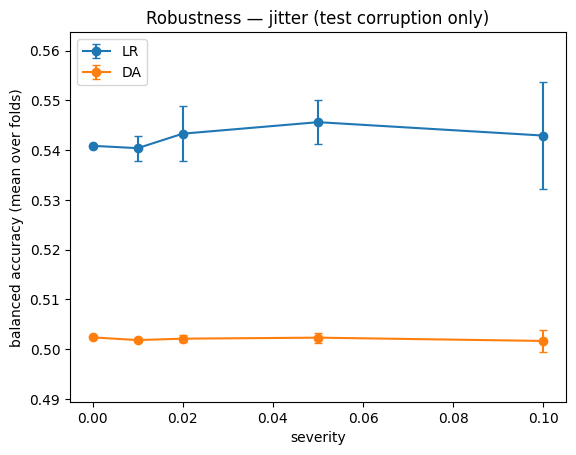

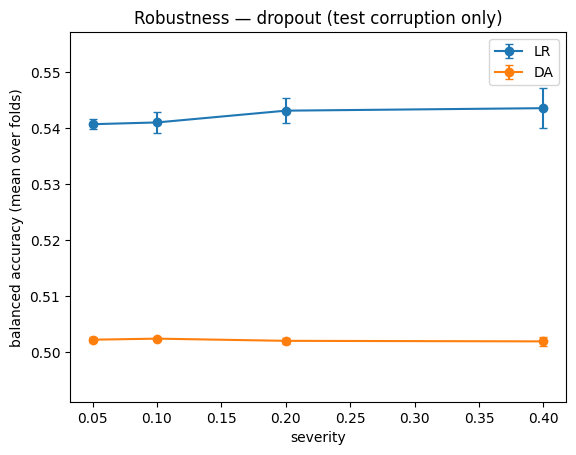

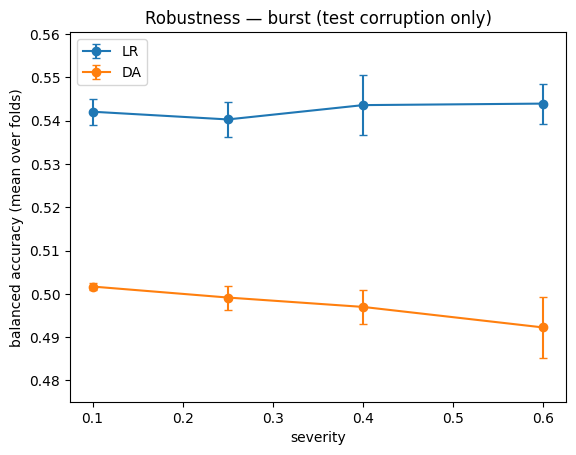

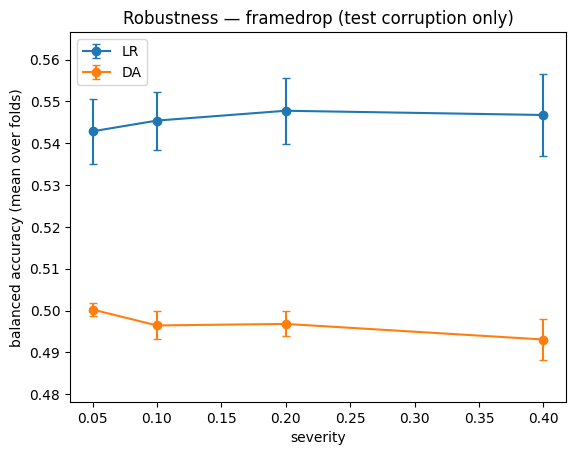

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_family_auto(df_long, family, pad=0.01):
    sub = df_long[df_long["family"] == family].copy()
    agg = (sub.groupby(["level","model"])["ba_mean"]
             .agg(["mean","std"])
             .reset_index()
             .sort_values("level"))

    y_min = float((agg["mean"] - agg["std"]).min())
    y_max = float((agg["mean"] + agg["std"]).max())

    plt.figure()
    for model in ["LR","DA"]:
        m = agg[agg["model"] == model]
        plt.errorbar(m["level"], m["mean"], yerr=m["std"], marker="o", capsize=3, label=model)

    plt.xlabel("severity")
    plt.ylabel("balanced accuracy (mean over folds)")
    plt.title(f"Robustness — {family} (test corruption only)")
    plt.ylim(y_min - pad, y_max + pad)
    plt.legend()
    plt.show()

for fam in ["jitter","dropout","burst","framedrop"]:
    plot_family_auto(df_long, fam, pad=0.01)

In [ ]:
import numpy as np
import pandas as pd

def compute_slope_table(df_long):
    rows = []
    for fam in df_long["family"].unique():
        sub = df_long[df_long["family"] == fam].copy()

        # aggregate over seeds at each level
        agg = (sub.groupby(["level", "model"])["ba_mean"]
                  .mean()
                  .reset_index())

        for model in ["LR", "DA"]:
            m = agg[agg["model"] == model].sort_values("level")
            x = m["level"].values.astype(float)
            y = m["ba_mean"].values.astype(float)

            # linear fit y = a + b x
            b, a = np.polyfit(x, y, 1)

            rows.append({
                "family": fam,
                "model": model,
                "slope_ba_per_severity": float(b),
                "intercept": float(a),
                "levels": len(x),
                "ba_at_min": float(y[0]),
                "ba_at_max": float(y[-1]),
                "delta_max_minus_min": float(y[-1] - y[0])
            })

    slope_df = pd.DataFrame(rows).sort_values(["family", "model"])
    # pivot view: LR vs DA slopes side by side
    slope_pivot = slope_df.pivot(index="family", columns="model", values="slope_ba_per_severity")
    slope_pivot["slope_gap_LR_minus_DA"] = slope_pivot["LR"] - slope_pivot["DA"]
    slope_pivot = slope_pivot.reset_index()

    return slope_df, slope_pivot

slope_df, slope_pivot = compute_slope_table(df_long)
display(slope_df)
display(slope_pivot)

,family,model,slope_ba_per_severity,intercept,levels,ba_at_min,ba_at_max,delta_max_minus_min
5,burst,DA,-0.015680,0.503196,3,0.501690,0.496986,-0.004704
4,burst,LR,0.005085,0.540707,3,0.542064,0.543589,0.001526
3,dropout,DA,-0.001731,0.502398,3,0.502202,0.501997,-0.000205
2,dropout,LR,0.016815,0.539630,3,0.540682,0.543099,0.002417
7,framedrop,DA,-0.019075,0.500066,3,0.500248,0.496819,-0.003429
6,framedrop,LR,0.031431,0.541688,3,0.542864,0.547777,0.004913
1,jitter,DA,0.002636,0.502121,4,0.502390,0.502331,-0.000059
0,jitter,LR,0.105188,0.540464,4,0.540889,0.545640,0.004751


model,family,DA,LR,slope_gap_LR_minus_DA
0,burst,-0.015680,0.005085,0.020765
1,dropout,-0.001731,0.016815,0.018546
2,framedrop,-0.019075,0.031431,0.050506
3,jitter,0.002636,0.105188,0.102552


In [ ]:
def bootstrap_slope(df_long, family, model, B=1000, seed=0):
    rng = np.random.default_rng(seed)
    sub = df_long[(df_long["family"]==family) & (df_long["model"]==model)].copy()

    # matrix of shape (n_seeds, n_levels)
    piv = sub.pivot_table(index="seed_rep", columns="level", values="ba_mean")
    levels = piv.columns.values.astype(float)
    Y = piv.values  # (S, L)

    slopes = []
    S = Y.shape[0]
    for _ in range(B):
        idx = rng.integers(0, S, size=S)
        y = np.nanmean(Y[idx], axis=0)
        b, a = np.polyfit(levels, y, 1)
        slopes.append(b)

    slopes = np.array(slopes)
    return float(np.mean(slopes)), tuple(np.quantile(slopes, [0.025, 0.975]))

# Example:
mean_b, ci = bootstrap_slope(df_long, "jitter", "LR", B=1000)
print(mean_b, ci)

0.10596234235234428 (np.float64(0.04872898604902794), np.float64(0.16078159448656734))


In [ ]:
mean_b, ci = bootstrap_slope(df_long, "jitter", "DA", B=1000)
print(mean_b, ci)

0.0024917223369284986 (np.float64(-0.011170288616448136), np.float64(0.01448446015059493))


In [ ]:
extreme_conditions = [
    ("jitter",   {"alpha": 0.10}),
    ("dropout",  {"p": 0.40, "extremity_biased": False}),
    ("burst",    {"frac": 0.60}),
    ("framedrop",{"q": 0.40}),
]

In [ ]:
M_EXT = 10
BASE_SEED_EXT = 9999  # separate seed range to avoid overlap

def run_extra_conditions(ext_conds):
    new_long = []
    new_sum  = []

    for ci, (family, params) in enumerate(ext_conds, start=1):
        level = get_level(family, params)
        cond_name = f"{family}:{params}"
        log(f"\n=== EXTREME {ci}/{len(ext_conds)}: {cond_name} | level={level} ===")

        lr_seed_means, da_seed_means = [], []

        for rep in range(M_EXT):
            rng = np.random.default_rng(BASE_SEED_EXT + 1000*(ci-1) + rep)

            # corrupt all trials once
            angles_cor = {}
            for tid, seq in coco_cache.items():
                seq_cor = apply_condition(seq, family, params, rng)
                angles_cor[tid] = compute_angle_timeseries(seq_cor).astype(np.float32)

            # eval pretrained models
            lr_fold_ba, da_fold_ba = [], []
            for fold in sorted(fold_splits.keys()):
                meta_te = fold_splits[fold]["test_meta"]
                lr_fold_ba.append(eval_lr_prefit_on_meta(lr_models[fold], meta_te, angles_cor))
                da_fold_ba.append(eval_da_pretrained_on_meta(da_models[fold], meta_te, angles_cor, batch=da_params[fold]["batch"]))

            lr_mean = float(np.nanmean(lr_fold_ba))
            da_mean = float(np.nanmean(da_fold_ba))

            lr_seed_means.append(lr_mean)
            da_seed_means.append(da_mean)

            new_long.append({"condition": cond_name, "family": family, "level": level, "seed_rep": rep, "model": "LR", "ba_mean": lr_mean})
            new_long.append({"condition": cond_name, "family": family, "level": level, "seed_rep": rep, "model": "DA", "ba_mean": da_mean})

        lr_seed_means = np.array(lr_seed_means)
        da_seed_means = np.array(da_seed_means)
        gap = lr_seed_means - da_seed_means

        new_sum.append({
            "condition": cond_name,
            "family": family,
            "level": level,
            "params": str(params),
            "lr_mean_over_seeds": float(lr_seed_means.mean()),
            "lr_std_over_seeds":  float(lr_seed_means.std(ddof=1)),
            "da_mean_over_seeds": float(da_seed_means.mean()),
            "da_std_over_seeds":  float(da_seed_means.std(ddof=1)),
            "gap_mean_over_seeds": float(gap.mean()),
            "gap_std_over_seeds":  float(gap.std(ddof=1)),
        })

        log(f"--- EXTREME summary {cond_name}: LR={lr_seed_means.mean():.4f}±{lr_seed_means.std(ddof=1):.4f} "
            f"| DA={da_seed_means.mean():.4f}±{da_seed_means.std(ddof=1):.4f} | gap={gap.mean():+.4f}")

    return pd.DataFrame(new_long), pd.DataFrame(new_sum)

df_long_ext, robust_df_ext = run_extra_conditions(extreme_conditions)

# append
df_long = pd.concat([df_long, df_long_ext], ignore_index=True)
robust_df = pd.concat([robust_df, robust_df_ext], ignore_index=True)

display(robust_df_ext)


=== EXTREME 1/4: jitter:{'alpha': 0.1} | level=0.1 ===
--- EXTREME summary jitter:{'alpha': 0.1}: LR=0.5429±0.0108 | DA=0.5017±0.0022 | gap=+0.0413

=== EXTREME 2/4: dropout:{'p': 0.4, 'extremity_biased': False} | level=0.4 ===
--- EXTREME summary dropout:{'p': 0.4, 'extremity_biased': False}: LR=0.5435±0.0036 | DA=0.5019±0.0008 | gap=+0.0416

=== EXTREME 3/4: burst:{'frac': 0.6} | level=0.6 ===
--- EXTREME summary burst:{'frac': 0.6}: LR=0.5439±0.0046 | DA=0.4922±0.0071 | gap=+0.0517

=== EXTREME 4/4: framedrop:{'q': 0.4} | level=0.4 ===
--- EXTREME summary framedrop:{'q': 0.4}: LR=0.5468±0.0098 | DA=0.4931±0.0049 | gap=+0.0537


,condition,family,level,params,lr_mean_over_seeds,lr_std_over_seeds,da_mean_over_seeds,da_std_over_seeds,gap_mean_over_seeds,gap_std_over_seeds
0,jitter:{'alpha': 0.1},jitter,0.1,{'alpha': 0.1},0.542946,0.010791,0.501670,0.002214,0.041276,0.011941
1,"dropout:{'p': 0.4, 'extremity_biased': False}",dropout,0.4,"{'p': 0.4, 'extremity_biased': False}",0.543544,0.003580,0.501900,0.000775,0.041643,0.003545
2,burst:{'frac': 0.6},burst,0.6,{'frac': 0.6},0.543939,0.004622,0.492237,0.007143,0.051702,0.009463
3,framedrop:{'q': 0.4},framedrop,0.4,{'q': 0.4},0.546760,0.009811,0.493094,0.004873,0.053666,0.008635
